In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import splitfolders
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix
import math
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras import layers, models

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
BATCH_SIZE = 8
IMAGE_SHAPE = (224, 224)
TRAIN_PATH = "output/train"
VAL_PATH = "output/val"

In [4]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_gen = datagen.flow_from_directory(directory = TRAIN_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

val_gen = datagen.flow_from_directory(directory = VAL_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

Found 833 images belonging to 4 classes.
Found 95 images belonging to 4 classes.


In [5]:
class_map = dict([(v, k) for k, v in train_gen.class_indices.items()])
print(class_map)

{0: 'Abnormal', 1: 'HMI', 2: 'MI', 3: 'Normal'}


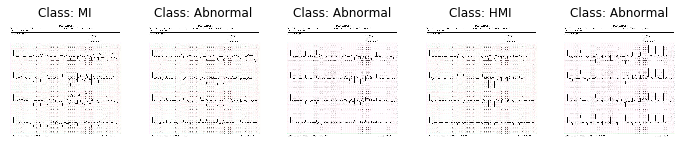

In [6]:
class_names = list(train_gen.class_indices.keys())


sample_images, sample_labels = train_gen.next()


num_images_to_display = 5


plt.figure(figsize=(12, 8))
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(sample_images[i])
    
    
    label_index = np.argmax(sample_labels[i])
    class_name = class_names[label_index]
    
    plt.title(f'Class: {class_name}')
    plt.axis('off')

plt.show()

In [7]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

# mobilenet-ADAM

In [8]:
inc = tf.keras.applications.mobilenet.MobileNet(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='max')


x31 = Flatten()(inc.output)
predictionss = Dense(4, activation='softmax')(x31)


model = Model(inputs = inc.inputs, outputs = predictionss)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

conv_pw_9_relu (ReLU)        (None, 14, 14, 512)       0         
_________________________________________________________________
conv_dw_10 (DepthwiseConv2D) (None, 14, 14, 512)       4608      
_________________________________________________________________
conv_dw_10_bn (BatchNormaliz (None, 14, 14, 512)       2048      
_________________________________________________________________
conv_dw_10_relu (ReLU)       (None, 14, 14, 512)       0         
_________________________________________________________________
conv_pw_10 (Conv2D)          (None, 14, 14, 512)       262144    
_________________________________________________________________
conv_pw_10_bn (BatchNormaliz (None, 14, 14, 512)       2048      
_________________________________________________________________
conv_pw_10_relu (ReLU)       (None, 14, 14, 512)       0         
_________________________________________________________________
conv_dw_11 (DepthwiseConv2D) (None, 14, 14, 512)       4608      
__________

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])

history = model.fit(train_gen, epochs=25, batch_size=20, validation_data=val_gen)

Epoch 1/25


 46/105 [============>.................] - ETA: 6:59 - loss: 7.0743 - accuracy: 0.1250 - f1_score: 0.1250 - recall_m: 0.1250 - precision_m: 0.1250 - specificity_m: 0.7083 - sensitivity_m: 0.1250 - mae: 0.4332 - mse: 0.42 - ETA: 1:16 - loss: 6.5061 - accuracy: 0.1875 - f1_score: 0.1875 - recall_m: 0.1875 - precision_m: 0.1875 - specificity_m: 0.7292 - sensitivity_m: 0.1875 - mae: 0.4006 - mse: 0.38 - ETA: 1:19 - loss: 8.3986 - accuracy: 0.2083 - f1_score: 0.2083 - recall_m: 0.2083 - precision_m: 0.2083 - specificity_m: 0.7361 - sensitivity_m: 0.2083 - mae: 0.3955 - mse: 0.37 - ETA: 1:16 - loss: 8.5022 - accuracy: 0.1562 - f1_score: 0.1562 - recall_m: 0.1562 - precision_m: 0.1562 - specificity_m: 0.7188 - sensitivity_m: 0.1562 - mae: 0.4174 - mse: 0.39 - ETA: 1:13 - loss: 7.6838 - accuracy: 0.2000 - f1_score: 0.2000 - recall_m: 0.2000 - precision_m: 0.2000 - specificity_m: 0.7333 - sensitivity_m: 0.2000 - mae: 0.3926 - mse: 0.36 - ETA: 1:12 - loss: 7.3542 - accuracy: 0.2083 - f1_score: 0

 92/105 [=========================>....] - ETA: 42s - loss: 2.3767 - accuracy: 0.4229 - f1_score: 0.4125 - recall_m: 0.3936 - precision_m: 0.4413 - specificity_m: 0.8289 - sensitivity_m: 0.3936 - mae: 0.2956 - mse: 0.213 - ETA: 41s - loss: 2.3556 - accuracy: 0.4219 - f1_score: 0.4122 - recall_m: 0.3932 - precision_m: 0.4410 - specificity_m: 0.8290 - sensitivity_m: 0.3932 - mae: 0.2955 - mse: 0.212 - ETA: 40s - loss: 2.3425 - accuracy: 0.4235 - f1_score: 0.4097 - recall_m: 0.3903 - precision_m: 0.4388 - specificity_m: 0.8291 - sensitivity_m: 0.3903 - mae: 0.2955 - mse: 0.213 - ETA: 40s - loss: 2.3221 - accuracy: 0.4275 - f1_score: 0.4140 - recall_m: 0.3950 - precision_m: 0.4425 - specificity_m: 0.8300 - sensitivity_m: 0.3950 - mae: 0.2934 - mse: 0.211 - ETA: 39s - loss: 2.3169 - accuracy: 0.4314 - f1_score: 0.4189 - recall_m: 0.3995 - precision_m: 0.4479 - specificity_m: 0.8317 - sensitivity_m: 0.3995 - mae: 0.2916 - mse: 0.210 - ETA: 38s - loss: 2.3180 - accuracy: 0.4351 - f1_score: 0.

105/105 [==============================] - ETA: 9s - loss: 1.9135 - accuracy: 0.5255 - f1_score: 0.5153 - recall_m: 0.4987 - precision_m: 0.5384 - specificity_m: 0.8584 - sensitivity_m: 0.4987 - mae: 0.2488 - mse: 0.17 - ETA: 8s - loss: 1.9111 - accuracy: 0.5253 - f1_score: 0.5141 - recall_m: 0.4973 - precision_m: 0.5372 - specificity_m: 0.8582 - sensitivity_m: 0.4973 - mae: 0.2488 - mse: 0.17 - ETA: 7s - loss: 1.8931 - accuracy: 0.5289 - f1_score: 0.5179 - recall_m: 0.5013 - precision_m: 0.5407 - specificity_m: 0.8592 - sensitivity_m: 0.5013 - mae: 0.2469 - mse: 0.17 - ETA: 6s - loss: 1.8744 - accuracy: 0.5339 - f1_score: 0.5229 - recall_m: 0.5065 - precision_m: 0.5455 - specificity_m: 0.8607 - sensitivity_m: 0.5065 - mae: 0.2447 - mse: 0.17 - ETA: 6s - loss: 1.8828 - accuracy: 0.5335 - f1_score: 0.5227 - recall_m: 0.5064 - precision_m: 0.5451 - specificity_m: 0.8604 - sensitivity_m: 0.5064 - mae: 0.2446 - mse: 0.17 - ETA: 5s - loss: 1.8804 - accuracy: 0.5341 - f1_score: 0.5275 - reca

 46/105 [============>.................] - ETA: 1:56 - loss: 0.2737 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0678 - mse: 0.04 - ETA: 1:39 - loss: 1.7361 - accuracy: 0.7500 - f1_score: 0.7500 - recall_m: 0.7500 - precision_m: 0.7500 - specificity_m: 0.9167 - sensitivity_m: 0.7500 - mae: 0.1537 - mse: 0.12 - ETA: 1:42 - loss: 1.9306 - accuracy: 0.6667 - f1_score: 0.6778 - recall_m: 0.6667 - precision_m: 0.6905 - specificity_m: 0.9028 - sensitivity_m: 0.6667 - mae: 0.1743 - mse: 0.13 - ETA: 1:43 - loss: 1.6051 - accuracy: 0.7188 - f1_score: 0.7271 - recall_m: 0.7188 - precision_m: 0.7366 - specificity_m: 0.9167 - sensitivity_m: 0.7188 - mae: 0.1539 - mse: 0.12 - ETA: 1:44 - loss: 1.4267 - accuracy: 0.7500 - f1_score: 0.7567 - recall_m: 0.7500 - precision_m: 0.7643 - specificity_m: 0.9250 - sensitivity_m: 0.7500 - mae: 0.1409 - mse: 0.11 - ETA: 1:43 - loss: 1.2809 - accuracy: 0.7708 - f1_score: 0

 92/105 [=========================>....] - ETA: 56s - loss: 1.0009 - accuracy: 0.7926 - f1_score: 0.7919 - recall_m: 0.7846 - precision_m: 0.8007 - specificity_m: 0.9362 - sensitivity_m: 0.7846 - mae: 0.1234 - mse: 0.087 - ETA: 55s - loss: 0.9985 - accuracy: 0.7917 - f1_score: 0.7921 - recall_m: 0.7839 - precision_m: 0.8018 - specificity_m: 0.9366 - sensitivity_m: 0.7839 - mae: 0.1244 - mse: 0.087 - ETA: 54s - loss: 0.9818 - accuracy: 0.7959 - f1_score: 0.7964 - recall_m: 0.7883 - precision_m: 0.8059 - specificity_m: 0.9379 - sensitivity_m: 0.7883 - mae: 0.1234 - mse: 0.086 - ETA: 53s - loss: 0.9629 - accuracy: 0.8000 - f1_score: 0.8004 - recall_m: 0.7925 - precision_m: 0.8098 - specificity_m: 0.9392 - sensitivity_m: 0.7925 - mae: 0.1213 - mse: 0.084 - ETA: 52s - loss: 0.9570 - accuracy: 0.7990 - f1_score: 0.8004 - recall_m: 0.7917 - precision_m: 0.8107 - specificity_m: 0.9395 - sensitivity_m: 0.7917 - mae: 0.1212 - mse: 0.084 - ETA: 51s - loss: 0.9597 - accuracy: 0.7957 - f1_score: 0.

105/105 [==============================] - ETA: 11s - loss: 1.0050 - accuracy: 0.7688 - f1_score: 0.7710 - recall_m: 0.7634 - precision_m: 0.7798 - specificity_m: 0.9288 - sensitivity_m: 0.7634 - mae: 0.1281 - mse: 0.093 - ETA: 10s - loss: 1.0007 - accuracy: 0.7673 - f1_score: 0.7695 - recall_m: 0.7620 - precision_m: 0.7782 - specificity_m: 0.9282 - sensitivity_m: 0.7620 - mae: 0.1282 - mse: 0.093 - ETA: 9s - loss: 0.9926 - accuracy: 0.7684 - f1_score: 0.7706 - recall_m: 0.7632 - precision_m: 0.7792 - specificity_m: 0.9285 - sensitivity_m: 0.7632 - mae: 0.1275 - mse: 0.093 - ETA: 8s - loss: 0.9827 - accuracy: 0.7708 - f1_score: 0.7730 - recall_m: 0.7656 - precision_m: 0.7815 - specificity_m: 0.9293 - sensitivity_m: 0.7656 - mae: 0.1264 - mse: 0.09 - ETA: 7s - loss: 0.9730 - accuracy: 0.7732 - f1_score: 0.7753 - recall_m: 0.7680 - precision_m: 0.7838 - specificity_m: 0.9300 - sensitivity_m: 0.7680 - mae: 0.1253 - mse: 0.09 - ETA: 6s - loss: 0.9672 - accuracy: 0.7742 - f1_score: 0.7763 -

 46/105 [============>.................] - ETA: 1:56 - loss: 2.5659 - accuracy: 0.6250 - f1_score: 0.6250 - recall_m: 0.6250 - precision_m: 0.6250 - specificity_m: 0.8750 - sensitivity_m: 0.6250 - mae: 0.2176 - mse: 0.15 - ETA: 1:33 - loss: 3.6449 - accuracy: 0.5625 - f1_score: 0.5625 - recall_m: 0.5625 - precision_m: 0.5625 - specificity_m: 0.8542 - sensitivity_m: 0.5625 - mae: 0.2367 - mse: 0.19 - ETA: 1:31 - loss: 2.7760 - accuracy: 0.6250 - f1_score: 0.6250 - recall_m: 0.6250 - precision_m: 0.6250 - specificity_m: 0.8750 - sensitivity_m: 0.6250 - mae: 0.1995 - mse: 0.16 - ETA: 1:39 - loss: 2.3355 - accuracy: 0.6562 - f1_score: 0.6562 - recall_m: 0.6562 - precision_m: 0.6562 - specificity_m: 0.8854 - sensitivity_m: 0.6562 - mae: 0.1922 - mse: 0.15 - ETA: 1:36 - loss: 1.8886 - accuracy: 0.7000 - f1_score: 0.7000 - recall_m: 0.7000 - precision_m: 0.7000 - specificity_m: 0.9000 - sensitivity_m: 0.7000 - mae: 0.1612 - mse: 0.12 - ETA: 1:35 - loss: 1.5939 - accuracy: 0.7292 - f1_score: 0

 92/105 [=========================>....] - ETA: 54s - loss: 0.6486 - accuracy: 0.8537 - f1_score: 0.8560 - recall_m: 0.8537 - precision_m: 0.8587 - specificity_m: 0.9530 - sensitivity_m: 0.8537 - mae: 0.0827 - mse: 0.059 - ETA: 53s - loss: 0.7094 - accuracy: 0.8515 - f1_score: 0.8538 - recall_m: 0.8516 - precision_m: 0.8564 - specificity_m: 0.9523 - sensitivity_m: 0.8516 - mae: 0.0841 - mse: 0.060 - ETA: 52s - loss: 0.7149 - accuracy: 0.8494 - f1_score: 0.8517 - recall_m: 0.8495 - precision_m: 0.8542 - specificity_m: 0.9515 - sensitivity_m: 0.8495 - mae: 0.0845 - mse: 0.061 - ETA: 51s - loss: 0.7118 - accuracy: 0.8473 - f1_score: 0.8497 - recall_m: 0.8475 - precision_m: 0.8521 - specificity_m: 0.9508 - sensitivity_m: 0.8475 - mae: 0.0854 - mse: 0.061 - ETA: 50s - loss: 0.7053 - accuracy: 0.8479 - f1_score: 0.8502 - recall_m: 0.8480 - precision_m: 0.8526 - specificity_m: 0.9510 - sensitivity_m: 0.8480 - mae: 0.0849 - mse: 0.061 - ETA: 49s - loss: 0.6922 - accuracy: 0.8509 - f1_score: 0.

105/105 [==============================] - ETA: 11s - loss: 0.9206 - accuracy: 0.8277 - f1_score: 0.8301 - recall_m: 0.8280 - precision_m: 0.8326 - specificity_m: 0.9444 - sensitivity_m: 0.8280 - mae: 0.0924 - mse: 0.071 - ETA: 10s - loss: 0.9125 - accuracy: 0.8282 - f1_score: 0.8306 - recall_m: 0.8285 - precision_m: 0.8330 - specificity_m: 0.9446 - sensitivity_m: 0.8285 - mae: 0.0920 - mse: 0.071 - ETA: 9s - loss: 0.9053 - accuracy: 0.8287 - f1_score: 0.8311 - recall_m: 0.8289 - precision_m: 0.8335 - specificity_m: 0.9447 - sensitivity_m: 0.8289 - mae: 0.0916 - mse: 0.070 - ETA: 8s - loss: 0.8981 - accuracy: 0.8292 - f1_score: 0.8315 - recall_m: 0.8294 - precision_m: 0.8339 - specificity_m: 0.9449 - sensitivity_m: 0.8294 - mae: 0.0912 - mse: 0.07 - ETA: 7s - loss: 0.8900 - accuracy: 0.8296 - f1_score: 0.8320 - recall_m: 0.8299 - precision_m: 0.8343 - specificity_m: 0.9450 - sensitivity_m: 0.8299 - mae: 0.0907 - mse: 0.07 - ETA: 6s - loss: 0.8831 - accuracy: 0.8301 - f1_score: 0.8324 -

 46/105 [============>.................] - ETA: 1:57 - loss: 2.3259 - accuracy: 0.6250 - f1_score: 0.6250 - recall_m: 0.6250 - precision_m: 0.6250 - specificity_m: 0.8750 - sensitivity_m: 0.6250 - mae: 0.1924 - mse: 0.17 - ETA: 1:32 - loss: 1.1845 - accuracy: 0.8125 - f1_score: 0.8125 - recall_m: 0.8125 - precision_m: 0.8125 - specificity_m: 0.9375 - sensitivity_m: 0.8125 - mae: 0.1063 - mse: 0.09 - ETA: 1:35 - loss: 0.8278 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0865 - mse: 0.06 - ETA: 1:34 - loss: 0.6233 - accuracy: 0.9062 - f1_score: 0.9062 - recall_m: 0.9062 - precision_m: 0.9062 - specificity_m: 0.9688 - sensitivity_m: 0.9062 - mae: 0.0661 - mse: 0.04 - ETA: 1:35 - loss: 0.5001 - accuracy: 0.9250 - f1_score: 0.9250 - recall_m: 0.9250 - precision_m: 0.9250 - specificity_m: 0.9750 - sensitivity_m: 0.9250 - mae: 0.0536 - mse: 0.03 - ETA: 1:36 - loss: 0.5042 - accuracy: 0.9167 - f1_score: 0

 92/105 [=========================>....] - ETA: 56s - loss: 0.6010 - accuracy: 0.8777 - f1_score: 0.8793 - recall_m: 0.8777 - precision_m: 0.8811 - specificity_m: 0.9610 - sensitivity_m: 0.8777 - mae: 0.0696 - mse: 0.053 - ETA: 55s - loss: 0.6129 - accuracy: 0.8776 - f1_score: 0.8792 - recall_m: 0.8776 - precision_m: 0.8810 - specificity_m: 0.9609 - sensitivity_m: 0.8776 - mae: 0.0694 - mse: 0.053 - ETA: 53s - loss: 0.6376 - accuracy: 0.8776 - f1_score: 0.8791 - recall_m: 0.8776 - precision_m: 0.8808 - specificity_m: 0.9609 - sensitivity_m: 0.8776 - mae: 0.0697 - mse: 0.053 - ETA: 52s - loss: 0.6552 - accuracy: 0.8775 - f1_score: 0.8790 - recall_m: 0.8775 - precision_m: 0.8807 - specificity_m: 0.9608 - sensitivity_m: 0.8775 - mae: 0.0698 - mse: 0.053 - ETA: 51s - loss: 0.6871 - accuracy: 0.8775 - f1_score: 0.8789 - recall_m: 0.8775 - precision_m: 0.8806 - specificity_m: 0.9608 - sensitivity_m: 0.8775 - mae: 0.0696 - mse: 0.053 - ETA: 50s - loss: 0.6862 - accuracy: 0.8774 - f1_score: 0.

105/105 [==============================] - ETA: 10s - loss: 0.6606 - accuracy: 0.8656 - f1_score: 0.8669 - recall_m: 0.8656 - precision_m: 0.8685 - specificity_m: 0.9565 - sensitivity_m: 0.8656 - mae: 0.0734 - mse: 0.057 - ETA: 9s - loss: 0.6598 - accuracy: 0.8644 - f1_score: 0.8657 - recall_m: 0.8644 - precision_m: 0.8672 - specificity_m: 0.9561 - sensitivity_m: 0.8644 - mae: 0.0738 - mse: 0.057 - ETA: 8s - loss: 0.6638 - accuracy: 0.8632 - f1_score: 0.8645 - recall_m: 0.8632 - precision_m: 0.8660 - specificity_m: 0.9557 - sensitivity_m: 0.8632 - mae: 0.0743 - mse: 0.05 - ETA: 8s - loss: 0.6587 - accuracy: 0.8633 - f1_score: 0.8646 - recall_m: 0.8633 - precision_m: 0.8661 - specificity_m: 0.9557 - sensitivity_m: 0.8633 - mae: 0.0740 - mse: 0.05 - ETA: 7s - loss: 0.6603 - accuracy: 0.8622 - f1_score: 0.8557 - recall_m: 0.8544 - precision_m: 0.8571 - specificity_m: 0.9527 - sensitivity_m: 0.8544 - mae: 0.0776 - mse: 0.06 - ETA: 6s - loss: 0.6679 - accuracy: 0.8610 - f1_score: 0.8546 - r

 46/105 [============>.................] - ETA: 1:55 - loss: 2.7484 - accuracy: 0.6250 - f1_score: 0.6250 - recall_m: 0.6250 - precision_m: 0.6250 - specificity_m: 0.8750 - sensitivity_m: 0.6250 - mae: 0.2085 - mse: 0.19 - ETA: 1:43 - loss: 1.5824 - accuracy: 0.7500 - f1_score: 0.7500 - recall_m: 0.7500 - precision_m: 0.7500 - specificity_m: 0.9167 - sensitivity_m: 0.7500 - mae: 0.1345 - mse: 0.12 - ETA: 1:46 - loss: 1.0831 - accuracy: 0.8333 - f1_score: 0.8333 - recall_m: 0.8333 - precision_m: 0.8333 - specificity_m: 0.9444 - sensitivity_m: 0.8333 - mae: 0.1019 - mse: 0.08 - ETA: 1:49 - loss: 1.0426 - accuracy: 0.8438 - f1_score: 0.8438 - recall_m: 0.8438 - precision_m: 0.8438 - specificity_m: 0.9479 - sensitivity_m: 0.8438 - mae: 0.0995 - mse: 0.08 - ETA: 1:49 - loss: 1.2734 - accuracy: 0.7750 - f1_score: 0.7817 - recall_m: 0.7750 - precision_m: 0.7893 - specificity_m: 0.9333 - sensitivity_m: 0.7750 - mae: 0.1301 - mse: 0.10 - ETA: 1:50 - loss: 1.7586 - accuracy: 0.7292 - f1_score: 0

 92/105 [=========================>....] - ETA: 55s - loss: 1.0364 - accuracy: 0.8218 - f1_score: 0.8236 - recall_m: 0.8218 - precision_m: 0.8256 - specificity_m: 0.9424 - sensitivity_m: 0.8218 - mae: 0.0967 - mse: 0.077 - ETA: 53s - loss: 1.0298 - accuracy: 0.8203 - f1_score: 0.8220 - recall_m: 0.8203 - precision_m: 0.8240 - specificity_m: 0.9418 - sensitivity_m: 0.8203 - mae: 0.0977 - mse: 0.078 - ETA: 52s - loss: 1.0227 - accuracy: 0.8189 - f1_score: 0.8206 - recall_m: 0.8189 - precision_m: 0.8225 - specificity_m: 0.9413 - sensitivity_m: 0.8189 - mae: 0.0978 - mse: 0.078 - ETA: 50s - loss: 1.0612 - accuracy: 0.8175 - f1_score: 0.8192 - recall_m: 0.8175 - precision_m: 0.8211 - specificity_m: 0.9408 - sensitivity_m: 0.8175 - mae: 0.0994 - mse: 0.079 - ETA: 49s - loss: 1.0824 - accuracy: 0.8162 - f1_score: 0.8178 - recall_m: 0.8162 - precision_m: 0.8197 - specificity_m: 0.9404 - sensitivity_m: 0.8162 - mae: 0.0995 - mse: 0.079 - ETA: 48s - loss: 1.0639 - accuracy: 0.8173 - f1_score: 0.

105/105 [==============================] - ETA: 9s - loss: 0.8070 - accuracy: 0.8507 - f1_score: 0.8538 - recall_m: 0.8522 - precision_m: 0.8559 - specificity_m: 0.9525 - sensitivity_m: 0.8522 - mae: 0.0803 - mse: 0.06 - ETA: 8s - loss: 0.7993 - accuracy: 0.8523 - f1_score: 0.8554 - recall_m: 0.8537 - precision_m: 0.8574 - specificity_m: 0.9530 - sensitivity_m: 0.8537 - mae: 0.0798 - mse: 0.06 - ETA: 7s - loss: 0.7908 - accuracy: 0.8539 - f1_score: 0.8569 - recall_m: 0.8553 - precision_m: 0.8589 - specificity_m: 0.9535 - sensitivity_m: 0.8553 - mae: 0.0790 - mse: 0.06 - ETA: 6s - loss: 0.7862 - accuracy: 0.8528 - f1_score: 0.8558 - recall_m: 0.8542 - precision_m: 0.8578 - specificity_m: 0.9531 - sensitivity_m: 0.8542 - mae: 0.0791 - mse: 0.06 - ETA: 6s - loss: 0.7802 - accuracy: 0.8531 - f1_score: 0.8560 - recall_m: 0.8544 - precision_m: 0.8579 - specificity_m: 0.9532 - sensitivity_m: 0.8544 - mae: 0.0791 - mse: 0.06 - ETA: 5s - loss: 0.7721 - accuracy: 0.8546 - f1_score: 0.8574 - reca

 46/105 [============>.................] - ETA: 1:13 - loss: 0.0010 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 5.2230e-04 - mse: 1.4439e- - ETA: 59s - loss: 0.2291 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0337 - mse: 0.0296         - ETA: 1:01 - loss: 0.5593 - accuracy: 0.8333 - f1_score: 0.8333 - recall_m: 0.8333 - precision_m: 0.8333 - specificity_m: 0.9444 - sensitivity_m: 0.8333 - mae: 0.0789 - mse: 0.07 - ETA: 1:02 - loss: 0.4196 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0592 - mse: 0.05 - ETA: 1:01 - loss: 0.3357 - accuracy: 0.9000 - f1_score: 0.9000 - recall_m: 0.9000 - precision_m: 0.9000 - specificity_m: 0.9667 - sensitivity_m: 0.9000 - mae: 0.0474 - mse: 0.04 - ETA: 1:01 - loss: 0.2798 - accuracy: 0.9

 92/105 [=========================>....] - ETA: 34s - loss: 0.9314 - accuracy: 0.8509 - f1_score: 0.8342 - recall_m: 0.8324 - precision_m: 0.8362 - specificity_m: 0.9459 - sensitivity_m: 0.8324 - mae: 0.0829 - mse: 0.070 - ETA: 33s - loss: 0.9487 - accuracy: 0.8462 - f1_score: 0.8299 - recall_m: 0.8281 - precision_m: 0.8318 - specificity_m: 0.9444 - sensitivity_m: 0.8281 - mae: 0.0851 - mse: 0.072 - ETA: 33s - loss: 0.9477 - accuracy: 0.8468 - f1_score: 0.8308 - recall_m: 0.8291 - precision_m: 0.8327 - specificity_m: 0.9447 - sensitivity_m: 0.8291 - mae: 0.0856 - mse: 0.072 - ETA: 32s - loss: 0.9374 - accuracy: 0.8473 - f1_score: 0.8317 - recall_m: 0.8300 - precision_m: 0.8336 - specificity_m: 0.9450 - sensitivity_m: 0.8300 - mae: 0.0854 - mse: 0.072 - ETA: 31s - loss: 0.9264 - accuracy: 0.8479 - f1_score: 0.8325 - recall_m: 0.8309 - precision_m: 0.8344 - specificity_m: 0.9453 - sensitivity_m: 0.8309 - mae: 0.0850 - mse: 0.072 - ETA: 31s - loss: 0.9097 - accuracy: 0.8509 - f1_score: 0.

105/105 [==============================] - ETA: 6s - loss: 0.6890 - accuracy: 0.8874 - f1_score: 0.8786 - recall_m: 0.8777 - precision_m: 0.8796 - specificity_m: 0.9601 - sensitivity_m: 0.8777 - mae: 0.0646 - mse: 0.05 - ETA: 6s - loss: 0.6817 - accuracy: 0.8886 - f1_score: 0.8799 - recall_m: 0.8790 - precision_m: 0.8809 - specificity_m: 0.9605 - sensitivity_m: 0.8790 - mae: 0.0640 - mse: 0.05 - ETA: 5s - loss: 0.6786 - accuracy: 0.8884 - f1_score: 0.8798 - recall_m: 0.8789 - precision_m: 0.8808 - specificity_m: 0.9605 - sensitivity_m: 0.8789 - mae: 0.0641 - mse: 0.05 - ETA: 5s - loss: 0.6775 - accuracy: 0.8883 - f1_score: 0.8798 - recall_m: 0.8789 - precision_m: 0.8808 - specificity_m: 0.9605 - sensitivity_m: 0.8789 - mae: 0.0642 - mse: 0.05 - ETA: 4s - loss: 0.6705 - accuracy: 0.8895 - f1_score: 0.8810 - recall_m: 0.8802 - precision_m: 0.8820 - specificity_m: 0.9609 - sensitivity_m: 0.8802 - mae: 0.0636 - mse: 0.05 - ETA: 3s - loss: 0.6649 - accuracy: 0.8893 - f1_score: 0.8810 - reca

 46/105 [============>.................] - ETA: 1:13 - loss: 1.4630e-04 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 7.3130e-05 - mse: 3.2549e- - ETA: 51s - loss: 0.0545 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0186 - mse: 0.0097             - ETA: 53s - loss: 0.0748 - accuracy: 0.9583 - f1_score: 0.9583 - recall_m: 0.9583 - precision_m: 0.9583 - specificity_m: 0.9861 - sensitivity_m: 0.9583 - mae: 0.0275 - mse: 0.012 - ETA: 52s - loss: 0.1385 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0357 - mse: 0.022 - ETA: 52s - loss: 0.1113 - accuracy: 0.9500 - f1_score: 0.9500 - recall_m: 0.9500 - precision_m: 0.9500 - specificity_m: 0.9833 - sensitivity_m: 0.9500 - mae: 0.0288 - mse: 0.017 - ETA: 52s - loss: 0.1862 - accura

 92/105 [=========================>....] - ETA: 30s - loss: 0.5993 - accuracy: 0.8808 - f1_score: 0.8640 - recall_m: 0.8617 - precision_m: 0.8666 - specificity_m: 0.9557 - sensitivity_m: 0.8617 - mae: 0.0685 - mse: 0.056 - ETA: 30s - loss: 0.5995 - accuracy: 0.8806 - f1_score: 0.8642 - recall_m: 0.8620 - precision_m: 0.8668 - specificity_m: 0.9557 - sensitivity_m: 0.8620 - mae: 0.0684 - mse: 0.056 - ETA: 29s - loss: 0.5882 - accuracy: 0.8831 - f1_score: 0.8670 - recall_m: 0.8648 - precision_m: 0.8695 - specificity_m: 0.9566 - sensitivity_m: 0.8648 - mae: 0.0675 - mse: 0.055 - ETA: 29s - loss: 0.5778 - accuracy: 0.8855 - f1_score: 0.8697 - recall_m: 0.8675 - precision_m: 0.8721 - specificity_m: 0.9575 - sensitivity_m: 0.8675 - mae: 0.0667 - mse: 0.054 - ETA: 28s - loss: 0.5731 - accuracy: 0.8828 - f1_score: 0.8683 - recall_m: 0.8652 - precision_m: 0.8718 - specificity_m: 0.9575 - sensitivity_m: 0.8652 - mae: 0.0672 - mse: 0.054 - ETA: 27s - loss: 0.5680 - accuracy: 0.8802 - f1_score: 0.

105/105 [==============================] - ETA: 6s - loss: 0.6820 - accuracy: 0.8738 - f1_score: 0.8677 - recall_m: 0.8642 - precision_m: 0.8717 - specificity_m: 0.9574 - sensitivity_m: 0.8642 - mae: 0.0679 - mse: 0.05 - ETA: 5s - loss: 0.6747 - accuracy: 0.8752 - f1_score: 0.8691 - recall_m: 0.8657 - precision_m: 0.8731 - specificity_m: 0.9579 - sensitivity_m: 0.8657 - mae: 0.0671 - mse: 0.05 - ETA: 5s - loss: 0.6687 - accuracy: 0.8752 - f1_score: 0.8692 - recall_m: 0.8658 - precision_m: 0.8731 - specificity_m: 0.9579 - sensitivity_m: 0.8658 - mae: 0.0668 - mse: 0.05 - ETA: 4s - loss: 0.6619 - accuracy: 0.8765 - f1_score: 0.8706 - recall_m: 0.8672 - precision_m: 0.8744 - specificity_m: 0.9583 - sensitivity_m: 0.8672 - mae: 0.0663 - mse: 0.05 - ETA: 4s - loss: 0.6551 - accuracy: 0.8778 - f1_score: 0.8719 - recall_m: 0.8686 - precision_m: 0.8757 - specificity_m: 0.9588 - sensitivity_m: 0.8686 - mae: 0.0656 - mse: 0.05 - ETA: 3s - loss: 0.6589 - accuracy: 0.8764 - f1_score: 0.8707 - reca

 46/105 [============>.................] - ETA: 1:13 - loss: 0.6911 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0866 - mse: 0.06 - ETA: 54s - loss: 0.3458 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0434 - mse: 0.0330 - ETA: 52s - loss: 0.2667 - accuracy: 0.9167 - f1_score: 0.9167 - recall_m: 0.9167 - precision_m: 0.9167 - specificity_m: 0.9722 - sensitivity_m: 0.9167 - mae: 0.0413 - mse: 0.028 - ETA: 53s - loss: 0.3224 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0578 - mse: 0.044 - ETA: 53s - loss: 0.3800 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0615 - mse: 0.048 - ETA: 52s - loss: 0.4346 - accuracy: 0.8750 - f1_score: 0

 92/105 [=========================>....] - ETA: 31s - loss: 0.8607 - accuracy: 0.8672 - f1_score: 0.8511 - recall_m: 0.8511 - precision_m: 0.8511 - specificity_m: 0.9504 - sensitivity_m: 0.8511 - mae: 0.0743 - mse: 0.061 - ETA: 30s - loss: 0.8425 - accuracy: 0.8700 - f1_score: 0.8542 - recall_m: 0.8542 - precision_m: 0.8542 - specificity_m: 0.9514 - sensitivity_m: 0.8542 - mae: 0.0728 - mse: 0.060 - ETA: 30s - loss: 0.8260 - accuracy: 0.8727 - f1_score: 0.8571 - recall_m: 0.8571 - precision_m: 0.8571 - specificity_m: 0.9524 - sensitivity_m: 0.8571 - mae: 0.0717 - mse: 0.059 - ETA: 29s - loss: 0.8092 - accuracy: 0.8753 - f1_score: 0.8600 - recall_m: 0.8600 - precision_m: 0.8600 - specificity_m: 0.9533 - sensitivity_m: 0.8600 - mae: 0.0703 - mse: 0.057 - ETA: 28s - loss: 0.7992 - accuracy: 0.8753 - f1_score: 0.8603 - recall_m: 0.8603 - precision_m: 0.8603 - specificity_m: 0.9534 - sensitivity_m: 0.8603 - mae: 0.0705 - mse: 0.057 - ETA: 28s - loss: 0.7908 - accuracy: 0.8753 - f1_score: 0.

105/105 [==============================] - ETA: 6s - loss: 0.7156 - accuracy: 0.8792 - f1_score: 0.8710 - recall_m: 0.8710 - precision_m: 0.8710 - specificity_m: 0.9570 - sensitivity_m: 0.8710 - mae: 0.0653 - mse: 0.05 - ETA: 6s - loss: 0.7080 - accuracy: 0.8805 - f1_score: 0.8723 - recall_m: 0.8723 - precision_m: 0.8723 - specificity_m: 0.9574 - sensitivity_m: 0.8723 - mae: 0.0647 - mse: 0.05 - ETA: 5s - loss: 0.7049 - accuracy: 0.8792 - f1_score: 0.8711 - recall_m: 0.8711 - precision_m: 0.8711 - specificity_m: 0.9570 - sensitivity_m: 0.8711 - mae: 0.0651 - mse: 0.05 - ETA: 5s - loss: 0.7137 - accuracy: 0.8791 - f1_score: 0.8711 - recall_m: 0.8711 - precision_m: 0.8711 - specificity_m: 0.9570 - sensitivity_m: 0.8711 - mae: 0.0651 - mse: 0.05 - ETA: 4s - loss: 0.7115 - accuracy: 0.8778 - f1_score: 0.8698 - recall_m: 0.8698 - precision_m: 0.8698 - specificity_m: 0.9566 - sensitivity_m: 0.8698 - mae: 0.0655 - mse: 0.05 - ETA: 4s - loss: 0.7052 - accuracy: 0.8777 - f1_score: 0.8699 - reca

 46/105 [============>.................] - ETA: 4:02 - loss: 1.4914e-04 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 7.4541e-05 - mse: 6.4402e- - ETA: 2:17 - loss: 0.1335 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0276 - mse: 0.0243           - ETA: 2:15 - loss: 0.0890 - accuracy: 0.9583 - f1_score: 0.9583 - recall_m: 0.9583 - precision_m: 0.9583 - specificity_m: 0.9861 - sensitivity_m: 0.9583 - mae: 0.0184 - mse: 0.01 - ETA: 2:09 - loss: 0.4097 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0596 - mse: 0.05 - ETA: 2:04 - loss: 0.4671 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0601 - mse: 0.05 - ETA: 2:02 - loss: 0.5308 - accura

 92/105 [=========================>....] - ETA: 53s - loss: 0.4907 - accuracy: 0.9106 - f1_score: 0.9122 - recall_m: 0.9122 - precision_m: 0.9122 - specificity_m: 0.9707 - sensitivity_m: 0.9122 - mae: 0.0427 - mse: 0.036 - ETA: 52s - loss: 0.5040 - accuracy: 0.9072 - f1_score: 0.9089 - recall_m: 0.9089 - precision_m: 0.9089 - specificity_m: 0.9696 - sensitivity_m: 0.9089 - mae: 0.0444 - mse: 0.037 - ETA: 51s - loss: 0.4935 - accuracy: 0.9091 - f1_score: 0.9107 - recall_m: 0.9107 - precision_m: 0.9107 - specificity_m: 0.9702 - sensitivity_m: 0.9107 - mae: 0.0435 - mse: 0.036 - ETA: 50s - loss: 0.4835 - accuracy: 0.9109 - f1_score: 0.9125 - recall_m: 0.9125 - precision_m: 0.9125 - specificity_m: 0.9708 - sensitivity_m: 0.9125 - mae: 0.0426 - mse: 0.036 - ETA: 49s - loss: 0.4738 - accuracy: 0.9127 - f1_score: 0.9142 - recall_m: 0.9142 - precision_m: 0.9142 - specificity_m: 0.9714 - sensitivity_m: 0.9142 - mae: 0.0418 - mse: 0.035 - ETA: 48s - loss: 0.5023 - accuracy: 0.9071 - f1_score: 0.

105/105 [==============================] - ETA: 10s - loss: 0.5839 - accuracy: 0.9050 - f1_score: 0.9059 - recall_m: 0.9059 - precision_m: 0.9059 - specificity_m: 0.9686 - sensitivity_m: 0.9059 - mae: 0.0462 - mse: 0.039 - ETA: 9s - loss: 0.5776 - accuracy: 0.9060 - f1_score: 0.9069 - recall_m: 0.9069 - precision_m: 0.9069 - specificity_m: 0.9690 - sensitivity_m: 0.9069 - mae: 0.0457 - mse: 0.038 - ETA: 8s - loss: 0.6019 - accuracy: 0.9017 - f1_score: 0.9030 - recall_m: 0.9026 - precision_m: 0.9034 - specificity_m: 0.9680 - sensitivity_m: 0.9026 - mae: 0.0478 - mse: 0.04 - ETA: 7s - loss: 0.6062 - accuracy: 0.9014 - f1_score: 0.9027 - recall_m: 0.9023 - precision_m: 0.9031 - specificity_m: 0.9679 - sensitivity_m: 0.9023 - mae: 0.0480 - mse: 0.04 - ETA: 6s - loss: 0.6000 - accuracy: 0.9025 - f1_score: 0.9037 - recall_m: 0.9034 - precision_m: 0.9041 - specificity_m: 0.9682 - sensitivity_m: 0.9034 - mae: 0.0475 - mse: 0.04 - ETA: 6s - loss: 0.5940 - accuracy: 0.9035 - f1_score: 0.9047 - r

 46/105 [============>.................] - ETA: 1:45 - loss: 0.9710 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0625 - mse: 0.06 - ETA: 1:25 - loss: 0.5016 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0384 - mse: 0.03 - ETA: 1:23 - loss: 0.3344 - accuracy: 0.9583 - f1_score: 0.9583 - recall_m: 0.9583 - precision_m: 0.9583 - specificity_m: 0.9861 - sensitivity_m: 0.9583 - mae: 0.0256 - mse: 0.02 - ETA: 1:23 - loss: 0.2553 - accuracy: 0.9688 - f1_score: 0.9688 - recall_m: 0.9688 - precision_m: 0.9688 - specificity_m: 0.9896 - sensitivity_m: 0.9688 - mae: 0.0213 - mse: 0.01 - ETA: 1:23 - loss: 0.6632 - accuracy: 0.9250 - f1_score: 0.9250 - recall_m: 0.9250 - precision_m: 0.9250 - specificity_m: 0.9750 - sensitivity_m: 0.9250 - mae: 0.0418 - mse: 0.03 - ETA: 1:24 - loss: 0.7755 - accuracy: 0.9167 - f1_score: 0

 92/105 [=========================>....] - ETA: 49s - loss: 0.5641 - accuracy: 0.9016 - f1_score: 0.9016 - recall_m: 0.9016 - precision_m: 0.9016 - specificity_m: 0.9672 - sensitivity_m: 0.9016 - mae: 0.0461 - mse: 0.039 - ETA: 48s - loss: 0.5524 - accuracy: 0.9036 - f1_score: 0.9036 - recall_m: 0.9036 - precision_m: 0.9036 - specificity_m: 0.9679 - sensitivity_m: 0.9036 - mae: 0.0452 - mse: 0.038 - ETA: 48s - loss: 0.5411 - accuracy: 0.9056 - f1_score: 0.9056 - recall_m: 0.9056 - precision_m: 0.9056 - specificity_m: 0.9685 - sensitivity_m: 0.9056 - mae: 0.0443 - mse: 0.037 - ETA: 47s - loss: 0.5579 - accuracy: 0.9050 - f1_score: 0.9050 - recall_m: 0.9050 - precision_m: 0.9050 - specificity_m: 0.9683 - sensitivity_m: 0.9050 - mae: 0.0450 - mse: 0.038 - ETA: 46s - loss: 0.5470 - accuracy: 0.9069 - f1_score: 0.9069 - recall_m: 0.9069 - precision_m: 0.9069 - specificity_m: 0.9690 - sensitivity_m: 0.9069 - mae: 0.0442 - mse: 0.037 - ETA: 45s - loss: 0.5365 - accuracy: 0.9087 - f1_score: 0.

105/105 [==============================] - ETA: 10s - loss: 0.4992 - accuracy: 0.9132 - f1_score: 0.9046 - recall_m: 0.9046 - precision_m: 0.9046 - specificity_m: 0.9682 - sensitivity_m: 0.9046 - mae: 0.0472 - mse: 0.039 - ETA: 9s - loss: 0.4938 - accuracy: 0.9141 - f1_score: 0.9056 - recall_m: 0.9056 - precision_m: 0.9056 - specificity_m: 0.9685 - sensitivity_m: 0.9056 - mae: 0.0468 - mse: 0.038 - ETA: 8s - loss: 0.4886 - accuracy: 0.9150 - f1_score: 0.9066 - recall_m: 0.9066 - precision_m: 0.9066 - specificity_m: 0.9689 - sensitivity_m: 0.9066 - mae: 0.0463 - mse: 0.03 - ETA: 8s - loss: 0.4970 - accuracy: 0.9133 - f1_score: 0.9055 - recall_m: 0.9049 - precision_m: 0.9061 - specificity_m: 0.9687 - sensitivity_m: 0.9049 - mae: 0.0469 - mse: 0.03 - ETA: 7s - loss: 0.5003 - accuracy: 0.9129 - f1_score: 0.9052 - recall_m: 0.9046 - precision_m: 0.9057 - specificity_m: 0.9686 - sensitivity_m: 0.9046 - mae: 0.0471 - mse: 0.03 - ETA: 6s - loss: 0.5201 - accuracy: 0.9125 - f1_score: 0.9048 - r

 46/105 [============>.................] - ETA: 1:40 - loss: 0.0067 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0033 - mse: 1.7181e- - ETA: 1:07 - loss: 0.3637 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0435 - mse: 0.0330   - ETA: 1:06 - loss: 0.6985 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0628 - mse: 0.05 - ETA: 1:07 - loss: 0.5239 - accuracy: 0.9062 - f1_score: 0.9062 - recall_m: 0.9062 - precision_m: 0.9062 - specificity_m: 0.9688 - sensitivity_m: 0.9062 - mae: 0.0471 - mse: 0.03 - ETA: 1:07 - loss: 0.6228 - accuracy: 0.9000 - f1_score: 0.9000 - recall_m: 0.9000 - precision_m: 0.9000 - specificity_m: 0.9667 - sensitivity_m: 0.9000 - mae: 0.0504 - mse: 0.04 - ETA: 1:06 - loss: 0.5190 - accuracy: 0.9167 - f1_

 92/105 [=========================>....] - ETA: 39s - loss: 0.6245 - accuracy: 0.9268 - f1_score: 0.9282 - recall_m: 0.9282 - precision_m: 0.9282 - specificity_m: 0.9761 - sensitivity_m: 0.9282 - mae: 0.0396 - mse: 0.032 - ETA: 38s - loss: 0.6137 - accuracy: 0.9257 - f1_score: 0.9271 - recall_m: 0.9271 - precision_m: 0.9271 - specificity_m: 0.9757 - sensitivity_m: 0.9271 - mae: 0.0396 - mse: 0.032 - ETA: 37s - loss: 0.6043 - accuracy: 0.9247 - f1_score: 0.9260 - recall_m: 0.9260 - precision_m: 0.9260 - specificity_m: 0.9753 - sensitivity_m: 0.9260 - mae: 0.0397 - mse: 0.032 - ETA: 36s - loss: 0.5949 - accuracy: 0.9237 - f1_score: 0.9250 - recall_m: 0.9250 - precision_m: 0.9250 - specificity_m: 0.9750 - sensitivity_m: 0.9250 - mae: 0.0397 - mse: 0.032 - ETA: 36s - loss: 0.5830 - accuracy: 0.9252 - f1_score: 0.9265 - recall_m: 0.9265 - precision_m: 0.9265 - specificity_m: 0.9755 - sensitivity_m: 0.9265 - mae: 0.0390 - mse: 0.031 - ETA: 35s - loss: 0.5716 - accuracy: 0.9267 - f1_score: 0.

105/105 [==============================] - ETA: 8s - loss: 0.4026 - accuracy: 0.9444 - f1_score: 0.9449 - recall_m: 0.9449 - precision_m: 0.9449 - specificity_m: 0.9816 - sensitivity_m: 0.9449 - mae: 0.0295 - mse: 0.02 - ETA: 7s - loss: 0.3984 - accuracy: 0.9450 - f1_score: 0.9455 - recall_m: 0.9455 - precision_m: 0.9455 - specificity_m: 0.9818 - sensitivity_m: 0.9455 - mae: 0.0292 - mse: 0.02 - ETA: 6s - loss: 0.3941 - accuracy: 0.9456 - f1_score: 0.9461 - recall_m: 0.9461 - precision_m: 0.9461 - specificity_m: 0.9820 - sensitivity_m: 0.9461 - mae: 0.0289 - mse: 0.02 - ETA: 6s - loss: 0.3900 - accuracy: 0.9461 - f1_score: 0.9466 - recall_m: 0.9466 - precision_m: 0.9466 - specificity_m: 0.9822 - sensitivity_m: 0.9466 - mae: 0.0286 - mse: 0.02 - ETA: 5s - loss: 0.3859 - accuracy: 0.9467 - f1_score: 0.9472 - recall_m: 0.9472 - precision_m: 0.9472 - specificity_m: 0.9824 - sensitivity_m: 0.9472 - mae: 0.0283 - mse: 0.02 - ETA: 4s - loss: 0.3820 - accuracy: 0.9472 - f1_score: 0.9477 - reca

 46/105 [============>.................] - ETA: 1:21 - loss: 1.9987 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0633 - mse: 0.06 - ETA: 1:11 - loss: 0.9998 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0319 - mse: 0.03 - ETA: 1:06 - loss: 0.8935 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0554 - mse: 0.04 - ETA: 1:04 - loss: 0.6959 - accuracy: 0.9062 - f1_score: 0.9062 - recall_m: 0.9062 - precision_m: 0.9062 - specificity_m: 0.9688 - sensitivity_m: 0.9062 - mae: 0.0513 - mse: 0.04 - ETA: 1:02 - loss: 0.6917 - accuracy: 0.9000 - f1_score: 0.9000 - recall_m: 0.9000 - precision_m: 0.9000 - specificity_m: 0.9667 - sensitivity_m: 0.9000 - mae: 0.0541 - mse: 0.04 - ETA: 1:02 - loss: 0.6665 - accuracy: 0.8958 - f1_score: 0

 92/105 [=========================>....] - ETA: 36s - loss: 0.8143 - accuracy: 0.9043 - f1_score: 0.9043 - recall_m: 0.9043 - precision_m: 0.9043 - specificity_m: 0.9681 - sensitivity_m: 0.9043 - mae: 0.0507 - mse: 0.042 - ETA: 35s - loss: 0.7973 - accuracy: 0.9062 - f1_score: 0.9062 - recall_m: 0.9062 - precision_m: 0.9062 - specificity_m: 0.9687 - sensitivity_m: 0.9062 - mae: 0.0496 - mse: 0.042 - ETA: 35s - loss: 0.7810 - accuracy: 0.9082 - f1_score: 0.9082 - recall_m: 0.9082 - precision_m: 0.9082 - specificity_m: 0.9694 - sensitivity_m: 0.9082 - mae: 0.0486 - mse: 0.041 - ETA: 34s - loss: 0.7700 - accuracy: 0.9075 - f1_score: 0.9075 - recall_m: 0.9075 - precision_m: 0.9075 - specificity_m: 0.9692 - sensitivity_m: 0.9075 - mae: 0.0488 - mse: 0.041 - ETA: 33s - loss: 0.7549 - accuracy: 0.9093 - f1_score: 0.9093 - recall_m: 0.9093 - precision_m: 0.9093 - specificity_m: 0.9698 - sensitivity_m: 0.9093 - mae: 0.0478 - mse: 0.040 - ETA: 33s - loss: 0.7404 - accuracy: 0.9111 - f1_score: 0.

105/105 [==============================] - ETA: 7s - loss: 0.6397 - accuracy: 0.9213 - f1_score: 0.9126 - recall_m: 0.9126 - precision_m: 0.9126 - specificity_m: 0.9709 - sensitivity_m: 0.9126 - mae: 0.0457 - mse: 0.03 - ETA: 7s - loss: 0.6338 - accuracy: 0.9221 - f1_score: 0.9136 - recall_m: 0.9136 - precision_m: 0.9136 - specificity_m: 0.9712 - sensitivity_m: 0.9136 - mae: 0.0455 - mse: 0.03 - ETA: 6s - loss: 0.6274 - accuracy: 0.9230 - f1_score: 0.9145 - recall_m: 0.9145 - precision_m: 0.9145 - specificity_m: 0.9715 - sensitivity_m: 0.9145 - mae: 0.0452 - mse: 0.03 - ETA: 5s - loss: 0.6211 - accuracy: 0.9238 - f1_score: 0.9154 - recall_m: 0.9154 - precision_m: 0.9154 - specificity_m: 0.9718 - sensitivity_m: 0.9154 - mae: 0.0448 - mse: 0.03 - ETA: 5s - loss: 0.6681 - accuracy: 0.9181 - f1_score: 0.9098 - recall_m: 0.9098 - precision_m: 0.9098 - specificity_m: 0.9699 - sensitivity_m: 0.9098 - mae: 0.0476 - mse: 0.04 - ETA: 4s - loss: 0.6652 - accuracy: 0.9176 - f1_score: 0.9094 - reca

 46/105 [============>.................] - ETA: 1:24 - loss: 2.5142e-04 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 1.2560e-04 - mse: 1.6746e- - ETA: 1:02 - loss: 0.3850 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0523 - mse: 0.0414           - ETA: 1:10 - loss: 0.2765 - accuracy: 0.9167 - f1_score: 0.9167 - recall_m: 0.9167 - precision_m: 0.9167 - specificity_m: 0.9722 - sensitivity_m: 0.9167 - mae: 0.0429 - mse: 0.03 - ETA: 1:13 - loss: 1.1954 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0641 - mse: 0.05 - ETA: 1:12 - loss: 0.9568 - accuracy: 0.9000 - f1_score: 0.9000 - recall_m: 0.9000 - precision_m: 0.9000 - specificity_m: 0.9667 - sensitivity_m: 0.9000 - mae: 0.0515 - mse: 0.04 - ETA: 1:09 - loss: 0.9810 - accura

 92/105 [=========================>....] - ETA: 42s - loss: 0.8690 - accuracy: 0.9079 - f1_score: 0.8910 - recall_m: 0.8910 - precision_m: 0.8910 - specificity_m: 0.9637 - sensitivity_m: 0.8910 - mae: 0.0572 - mse: 0.050 - ETA: 41s - loss: 0.8506 - accuracy: 0.9098 - f1_score: 0.8932 - recall_m: 0.8932 - precision_m: 0.8932 - specificity_m: 0.9644 - sensitivity_m: 0.8932 - mae: 0.0560 - mse: 0.049 - ETA: 41s - loss: 0.8330 - accuracy: 0.9117 - f1_score: 0.8954 - recall_m: 0.8954 - precision_m: 0.8954 - specificity_m: 0.9651 - sensitivity_m: 0.8954 - mae: 0.0549 - mse: 0.048 - ETA: 40s - loss: 0.8194 - accuracy: 0.9109 - f1_score: 0.8950 - recall_m: 0.8950 - precision_m: 0.8950 - specificity_m: 0.9650 - sensitivity_m: 0.8950 - mae: 0.0547 - mse: 0.048 - ETA: 39s - loss: 0.9257 - accuracy: 0.9027 - f1_score: 0.8873 - recall_m: 0.8873 - precision_m: 0.8873 - specificity_m: 0.9624 - sensitivity_m: 0.8873 - mae: 0.0584 - mse: 0.051 - ETA: 39s - loss: 0.9076 - accuracy: 0.9046 - f1_score: 0.

105/105 [==============================] - ETA: 9s - loss: 0.7698 - accuracy: 0.9132 - f1_score: 0.9039 - recall_m: 0.9032 - precision_m: 0.9046 - specificity_m: 0.9682 - sensitivity_m: 0.9032 - mae: 0.0502 - mse: 0.043 - ETA: 8s - loss: 0.7764 - accuracy: 0.9128 - f1_score: 0.9035 - recall_m: 0.9029 - precision_m: 0.9043 - specificity_m: 0.9681 - sensitivity_m: 0.9029 - mae: 0.0503 - mse: 0.04 - ETA: 7s - loss: 0.7895 - accuracy: 0.9110 - f1_score: 0.9019 - recall_m: 0.9013 - precision_m: 0.9026 - specificity_m: 0.9675 - sensitivity_m: 0.9013 - mae: 0.0512 - mse: 0.04 - ETA: 7s - loss: 0.7814 - accuracy: 0.9120 - f1_score: 0.9030 - recall_m: 0.9023 - precision_m: 0.9036 - specificity_m: 0.9679 - sensitivity_m: 0.9023 - mae: 0.0507 - mse: 0.04 - ETA: 6s - loss: 0.7827 - accuracy: 0.9103 - f1_score: 0.9014 - recall_m: 0.9008 - precision_m: 0.9021 - specificity_m: 0.9674 - sensitivity_m: 0.9008 - mae: 0.0515 - mse: 0.04 - ETA: 5s - loss: 0.7932 - accuracy: 0.9086 - f1_score: 0.8998 - rec

 46/105 [============>.................] - ETA: 1:14 - loss: 0.0000e+00 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 7.6315e-11 - mse: 1.5675e- - ETA: 59s - loss: 0.0000e+00 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 4.5264e-11 - mse: 8.0113e-20 - ETA: 58s - loss: 0.6405 - accuracy: 0.9583 - f1_score: 0.9583 - recall_m: 0.9583 - precision_m: 0.9583 - specificity_m: 0.9861 - sensitivity_m: 0.9583 - mae: 0.0208 - mse: 0.0208            - ETA: 58s - loss: 0.9560 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0313 - mse: 0.031 - ETA: 58s - loss: 0.9029 - accuracy: 0.9250 - f1_score: 0.9250 - recall_m: 0.9250 - precision_m: 0.9250 - specificity_m: 0.9750 - sensitivity_m: 0.9250 - mae: 0.0375 - mse: 0.037 - ETA: 58s - loss: 0.7

 92/105 [=========================>....] - ETA: 45s - loss: 0.8191 - accuracy: 0.9241 - f1_score: 0.9069 - recall_m: 0.9069 - precision_m: 0.9069 - specificity_m: 0.9690 - sensitivity_m: 0.9069 - mae: 0.0464 - mse: 0.040 - ETA: 45s - loss: 0.8017 - accuracy: 0.9257 - f1_score: 0.9089 - recall_m: 0.9089 - precision_m: 0.9089 - specificity_m: 0.9696 - sensitivity_m: 0.9089 - mae: 0.0454 - mse: 0.040 - ETA: 44s - loss: 0.7851 - accuracy: 0.9273 - f1_score: 0.9107 - recall_m: 0.9107 - precision_m: 0.9107 - specificity_m: 0.9702 - sensitivity_m: 0.9107 - mae: 0.0445 - mse: 0.039 - ETA: 43s - loss: 0.7700 - accuracy: 0.9288 - f1_score: 0.9125 - recall_m: 0.9125 - precision_m: 0.9125 - specificity_m: 0.9708 - sensitivity_m: 0.9125 - mae: 0.0440 - mse: 0.038 - ETA: 42s - loss: 0.8185 - accuracy: 0.9202 - f1_score: 0.9044 - recall_m: 0.9044 - precision_m: 0.9044 - specificity_m: 0.9681 - sensitivity_m: 0.9044 - mae: 0.0480 - mse: 0.042 - ETA: 42s - loss: 0.8331 - accuracy: 0.9193 - f1_score: 0.

105/105 [==============================] - ETA: 9s - loss: 0.5704 - accuracy: 0.9335 - f1_score: 0.9247 - recall_m: 0.9247 - precision_m: 0.9247 - specificity_m: 0.9749 - sensitivity_m: 0.9247 - mae: 0.0383 - mse: 0.03 - ETA: 8s - loss: 0.5643 - accuracy: 0.9342 - f1_score: 0.9255 - recall_m: 0.9255 - precision_m: 0.9255 - specificity_m: 0.9752 - sensitivity_m: 0.9255 - mae: 0.0379 - mse: 0.03 - ETA: 7s - loss: 0.5593 - accuracy: 0.9336 - f1_score: 0.9250 - recall_m: 0.9250 - precision_m: 0.9250 - specificity_m: 0.9750 - sensitivity_m: 0.9250 - mae: 0.0379 - mse: 0.03 - ETA: 6s - loss: 0.5545 - accuracy: 0.9330 - f1_score: 0.9245 - recall_m: 0.9245 - precision_m: 0.9245 - specificity_m: 0.9748 - sensitivity_m: 0.9245 - mae: 0.0378 - mse: 0.03 - ETA: 6s - loss: 0.5593 - accuracy: 0.9324 - f1_score: 0.9240 - recall_m: 0.9240 - precision_m: 0.9240 - specificity_m: 0.9747 - sensitivity_m: 0.9240 - mae: 0.0381 - mse: 0.03 - ETA: 5s - loss: 0.5536 - accuracy: 0.9331 - f1_score: 0.9247 - reca

 46/105 [============>.................] - ETA: 1:26 - loss: 0.0464 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0195 - mse: 0.00 - ETA: 1:09 - loss: 0.0232 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0098 - mse: 0.00 - ETA: 1:07 - loss: 0.0650 - accuracy: 0.9583 - f1_score: 0.9583 - recall_m: 0.9583 - precision_m: 0.9583 - specificity_m: 0.9861 - sensitivity_m: 0.9583 - mae: 0.0213 - mse: 0.01 - ETA: 1:03 - loss: 0.0488 - accuracy: 0.9688 - f1_score: 0.9688 - recall_m: 0.9688 - precision_m: 0.9688 - specificity_m: 0.9896 - sensitivity_m: 0.9688 - mae: 0.0160 - mse: 0.00 - ETA: 1:01 - loss: 0.4094 - accuracy: 0.9250 - f1_score: 0.9250 - recall_m: 0.9250 - precision_m: 0.9250 - specificity_m: 0.9750 - sensitivity_m: 0.9250 - mae: 0.0379 - mse: 0.03 - ETA: 59s - loss: 0.3412 - accuracy: 0.9375 - f1_score: 0.

 92/105 [=========================>....] - ETA: 31s - loss: 0.1435 - accuracy: 0.9681 - f1_score: 0.9681 - recall_m: 0.9681 - precision_m: 0.9681 - specificity_m: 0.9894 - sensitivity_m: 0.9681 - mae: 0.0176 - mse: 0.014 - ETA: 30s - loss: 0.1405 - accuracy: 0.9688 - f1_score: 0.9688 - recall_m: 0.9688 - precision_m: 0.9688 - specificity_m: 0.9896 - sensitivity_m: 0.9688 - mae: 0.0172 - mse: 0.014 - ETA: 30s - loss: 0.1377 - accuracy: 0.9694 - f1_score: 0.9694 - recall_m: 0.9694 - precision_m: 0.9694 - specificity_m: 0.9898 - sensitivity_m: 0.9694 - mae: 0.0169 - mse: 0.013 - ETA: 29s - loss: 0.1573 - accuracy: 0.9675 - f1_score: 0.9675 - recall_m: 0.9675 - precision_m: 0.9675 - specificity_m: 0.9892 - sensitivity_m: 0.9675 - mae: 0.0178 - mse: 0.014 - ETA: 29s - loss: 0.1543 - accuracy: 0.9681 - f1_score: 0.9681 - recall_m: 0.9681 - precision_m: 0.9681 - specificity_m: 0.9894 - sensitivity_m: 0.9681 - mae: 0.0175 - mse: 0.014 - ETA: 28s - loss: 0.1522 - accuracy: 0.9688 - f1_score: 0.

105/105 [==============================] - ETA: 6s - loss: 0.1821 - accuracy: 0.9634 - f1_score: 0.9543 - recall_m: 0.9543 - precision_m: 0.9543 - specificity_m: 0.9848 - sensitivity_m: 0.9543 - mae: 0.0243 - mse: 0.01 - ETA: 5s - loss: 0.1853 - accuracy: 0.9624 - f1_score: 0.9535 - recall_m: 0.9535 - precision_m: 0.9535 - specificity_m: 0.9845 - sensitivity_m: 0.9535 - mae: 0.0247 - mse: 0.02 - ETA: 5s - loss: 0.1833 - accuracy: 0.9628 - f1_score: 0.9539 - recall_m: 0.9539 - precision_m: 0.9539 - specificity_m: 0.9846 - sensitivity_m: 0.9539 - mae: 0.0244 - mse: 0.02 - ETA: 4s - loss: 0.1814 - accuracy: 0.9632 - f1_score: 0.9544 - recall_m: 0.9544 - precision_m: 0.9544 - specificity_m: 0.9848 - sensitivity_m: 0.9544 - mae: 0.0242 - mse: 0.01 - ETA: 4s - loss: 0.1799 - accuracy: 0.9636 - f1_score: 0.9549 - recall_m: 0.9549 - precision_m: 0.9549 - specificity_m: 0.9850 - sensitivity_m: 0.9549 - mae: 0.0241 - mse: 0.01 - ETA: 3s - loss: 0.1780 - accuracy: 0.9640 - f1_score: 0.9554 - reca

 46/105 [============>.................] - ETA: 1:13 - loss: 0.6641 - accuracy: 0.7500 - f1_score: 0.7500 - recall_m: 0.7500 - precision_m: 0.7500 - specificity_m: 0.9167 - sensitivity_m: 0.7500 - mae: 0.1136 - mse: 0.10 - ETA: 52s - loss: 0.3321 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0568 - mse: 0.0511 - ETA: 53s - loss: 0.7707 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0587 - mse: 0.054 - ETA: 53s - loss: 0.5869 - accuracy: 0.9062 - f1_score: 0.9062 - recall_m: 0.9062 - precision_m: 0.9062 - specificity_m: 0.9688 - sensitivity_m: 0.9062 - mae: 0.0479 - mse: 0.042 - ETA: 54s - loss: 0.4696 - accuracy: 0.9250 - f1_score: 0.9250 - recall_m: 0.9250 - precision_m: 0.9250 - specificity_m: 0.9750 - sensitivity_m: 0.9250 - mae: 0.0383 - mse: 0.033 - ETA: 53s - loss: 0.5209 - accuracy: 0.9167 - f1_score: 0

 92/105 [=========================>....] - ETA: 30s - loss: 0.4495 - accuracy: 0.9441 - f1_score: 0.9441 - recall_m: 0.9441 - precision_m: 0.9441 - specificity_m: 0.9814 - sensitivity_m: 0.9441 - mae: 0.0294 - mse: 0.026 - ETA: 30s - loss: 0.4401 - accuracy: 0.9453 - f1_score: 0.9453 - recall_m: 0.9453 - precision_m: 0.9453 - specificity_m: 0.9818 - sensitivity_m: 0.9453 - mae: 0.0288 - mse: 0.025 - ETA: 29s - loss: 0.4311 - accuracy: 0.9464 - f1_score: 0.9464 - recall_m: 0.9464 - precision_m: 0.9464 - specificity_m: 0.9821 - sensitivity_m: 0.9464 - mae: 0.0282 - mse: 0.025 - ETA: 29s - loss: 0.4225 - accuracy: 0.9475 - f1_score: 0.9475 - recall_m: 0.9475 - precision_m: 0.9475 - specificity_m: 0.9825 - sensitivity_m: 0.9475 - mae: 0.0277 - mse: 0.024 - ETA: 28s - loss: 0.4142 - accuracy: 0.9485 - f1_score: 0.9485 - recall_m: 0.9485 - precision_m: 0.9485 - specificity_m: 0.9828 - sensitivity_m: 0.9485 - mae: 0.0271 - mse: 0.024 - ETA: 28s - loss: 0.4063 - accuracy: 0.9495 - f1_score: 0.

105/105 [==============================] - ETA: 6s - loss: 0.5364 - accuracy: 0.9435 - f1_score: 0.9435 - recall_m: 0.9435 - precision_m: 0.9435 - specificity_m: 0.9812 - sensitivity_m: 0.9435 - mae: 0.0304 - mse: 0.02 - ETA: 5s - loss: 0.5317 - accuracy: 0.9441 - f1_score: 0.9441 - recall_m: 0.9441 - precision_m: 0.9441 - specificity_m: 0.9814 - sensitivity_m: 0.9441 - mae: 0.0305 - mse: 0.02 - ETA: 5s - loss: 0.5410 - accuracy: 0.9434 - f1_score: 0.9434 - recall_m: 0.9434 - precision_m: 0.9434 - specificity_m: 0.9811 - sensitivity_m: 0.9434 - mae: 0.0308 - mse: 0.02 - ETA: 4s - loss: 0.5357 - accuracy: 0.9440 - f1_score: 0.9440 - recall_m: 0.9440 - precision_m: 0.9440 - specificity_m: 0.9813 - sensitivity_m: 0.9440 - mae: 0.0307 - mse: 0.02 - ETA: 4s - loss: 0.5432 - accuracy: 0.9420 - f1_score: 0.9420 - recall_m: 0.9420 - precision_m: 0.9420 - specificity_m: 0.9807 - sensitivity_m: 0.9420 - mae: 0.0314 - mse: 0.02 - ETA: 3s - loss: 0.5628 - accuracy: 0.9388 - f1_score: 0.9388 - reca

 46/105 [============>.................] - ETA: 1:12 - loss: 1.0331 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0629 - mse: 0.06 - ETA: 55s - loss: 4.2714 - accuracy: 0.7500 - f1_score: 0.7500 - recall_m: 0.7500 - precision_m: 0.7500 - specificity_m: 0.9167 - sensitivity_m: 0.7500 - mae: 0.1287 - mse: 0.1251 - ETA: 54s - loss: 3.4144 - accuracy: 0.7500 - f1_score: 0.7500 - recall_m: 0.7500 - precision_m: 0.7500 - specificity_m: 0.9167 - sensitivity_m: 0.7500 - mae: 0.1288 - mse: 0.124 - ETA: 53s - loss: 2.6527 - accuracy: 0.7812 - f1_score: 0.7812 - recall_m: 0.7812 - precision_m: 0.7812 - specificity_m: 0.9271 - sensitivity_m: 0.7812 - mae: 0.1118 - mse: 0.107 - ETA: 52s - loss: 4.0971 - accuracy: 0.7000 - f1_score: 0.7000 - recall_m: 0.7000 - precision_m: 0.7000 - specificity_m: 0.9000 - sensitivity_m: 0.7000 - mae: 0.1517 - mse: 0.147 - ETA: 52s - loss: 4.2515 - accuracy: 0.6667 - f1_score: 0

 92/105 [=========================>....] - ETA: 31s - loss: 1.3143 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0642 - mse: 0.057 - ETA: 30s - loss: 1.3313 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0648 - mse: 0.057 - ETA: 30s - loss: 1.3344 - accuracy: 0.8724 - f1_score: 0.8724 - recall_m: 0.8724 - precision_m: 0.8724 - specificity_m: 0.9575 - sensitivity_m: 0.8724 - mae: 0.0666 - mse: 0.059 - ETA: 29s - loss: 1.3077 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0653 - mse: 0.058 - ETA: 29s - loss: 1.2933 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0653 - mse: 0.058 - ETA: 28s - loss: 1.2684 - accuracy: 0.8774 - f1_score: 0.

105/105 [==============================] - ETA: 6s - loss: 0.9051 - accuracy: 0.9009 - f1_score: 0.8931 - recall_m: 0.8925 - precision_m: 0.8938 - specificity_m: 0.9646 - sensitivity_m: 0.8925 - mae: 0.0544 - mse: 0.04 - ETA: 5s - loss: 0.9042 - accuracy: 0.9007 - f1_score: 0.8929 - recall_m: 0.8923 - precision_m: 0.8936 - specificity_m: 0.9645 - sensitivity_m: 0.8923 - mae: 0.0545 - mse: 0.04 - ETA: 5s - loss: 0.9081 - accuracy: 0.9004 - f1_score: 0.8927 - recall_m: 0.8921 - precision_m: 0.8934 - specificity_m: 0.9645 - sensitivity_m: 0.8921 - mae: 0.0546 - mse: 0.04 - ETA: 4s - loss: 0.9084 - accuracy: 0.8988 - f1_score: 0.8912 - recall_m: 0.8906 - precision_m: 0.8919 - specificity_m: 0.9640 - sensitivity_m: 0.8906 - mae: 0.0555 - mse: 0.04 - ETA: 4s - loss: 0.9002 - accuracy: 0.8986 - f1_score: 0.8911 - recall_m: 0.8905 - precision_m: 0.8918 - specificity_m: 0.9639 - sensitivity_m: 0.8905 - mae: 0.0554 - mse: 0.04 - ETA: 3s - loss: 0.8910 - accuracy: 0.8996 - f1_score: 0.8922 - reca

 46/105 [============>.................] - ETA: 1:40 - loss: 0.0024 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0012 - mse: 2.3024e- - ETA: 1:12 - loss: 0.0048 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0023 - mse: 1.0391e- - ETA: 1:09 - loss: 0.0036 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0018 - mse: 7.0425e- - ETA: 1:07 - loss: 0.0045 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0022 - mse: 8.3144e- - ETA: 53s - loss: 0.4649 - accuracy: 0.9697 - f1_score: 0.8000 - recall_m: 0.8000 - precision_m: 0.8000 - specificity_m: 0.9333 - sensitivity_m: 0.8000 - mae: 0.1018 - mse: 0.1001     - ETA: 56s - loss: 0.5700 - accuracy: 

 92/105 [=========================>....] - ETA: 37s - loss: 0.4172 - accuracy: 0.9377 - f1_score: 0.9215 - recall_m: 0.9202 - precision_m: 0.9229 - specificity_m: 0.9743 - sensitivity_m: 0.9202 - mae: 0.0391 - mse: 0.034 - ETA: 36s - loss: 0.4083 - accuracy: 0.9390 - f1_score: 0.9231 - recall_m: 0.9219 - precision_m: 0.9245 - specificity_m: 0.9748 - sensitivity_m: 0.9219 - mae: 0.0383 - mse: 0.033 - ETA: 36s - loss: 0.3999 - accuracy: 0.9403 - f1_score: 0.9247 - recall_m: 0.9235 - precision_m: 0.9260 - specificity_m: 0.9753 - sensitivity_m: 0.9235 - mae: 0.0375 - mse: 0.032 - ETA: 35s - loss: 0.3918 - accuracy: 0.9415 - f1_score: 0.9262 - recall_m: 0.9250 - precision_m: 0.9275 - specificity_m: 0.9758 - sensitivity_m: 0.9250 - mae: 0.0368 - mse: 0.032 - ETA: 34s - loss: 0.3839 - accuracy: 0.9426 - f1_score: 0.9276 - recall_m: 0.9265 - precision_m: 0.9289 - specificity_m: 0.9763 - sensitivity_m: 0.9265 - mae: 0.0360 - mse: 0.031 - ETA: 34s - loss: 0.4518 - accuracy: 0.9389 - f1_score: 0.

105/105 [==============================] - ETA: 8s - loss: 0.4153 - accuracy: 0.9471 - f1_score: 0.9388 - recall_m: 0.9382 - precision_m: 0.9395 - specificity_m: 0.9798 - sensitivity_m: 0.9382 - mae: 0.0306 - mse: 0.02 - ETA: 7s - loss: 0.4108 - accuracy: 0.9477 - f1_score: 0.9395 - recall_m: 0.9388 - precision_m: 0.9402 - specificity_m: 0.9801 - sensitivity_m: 0.9388 - mae: 0.0303 - mse: 0.02 - ETA: 6s - loss: 0.4065 - accuracy: 0.9482 - f1_score: 0.9401 - recall_m: 0.9395 - precision_m: 0.9408 - specificity_m: 0.9803 - sensitivity_m: 0.9395 - mae: 0.0300 - mse: 0.02 - ETA: 6s - loss: 0.4272 - accuracy: 0.9461 - f1_score: 0.9381 - recall_m: 0.9375 - precision_m: 0.9388 - specificity_m: 0.9796 - sensitivity_m: 0.9375 - mae: 0.0309 - mse: 0.02 - ETA: 5s - loss: 0.4311 - accuracy: 0.9454 - f1_score: 0.9375 - recall_m: 0.9369 - precision_m: 0.9381 - specificity_m: 0.9794 - sensitivity_m: 0.9369 - mae: 0.0313 - mse: 0.02 - ETA: 4s - loss: 0.4315 - accuracy: 0.9447 - f1_score: 0.9368 - reca

 46/105 [============>.................] - ETA: 1:25 - loss: 8.1956e-07 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 4.0987e-07 - mse: 2.6054e- - ETA: 1:03 - loss: 7.3761e-07 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 3.6988e-07 - mse: 2.1685e- - ETA: 1:05 - loss: 0.0885 - accuracy: 0.9583 - f1_score: 0.9583 - recall_m: 0.9583 - precision_m: 0.9583 - specificity_m: 0.9861 - sensitivity_m: 0.9583 - mae: 0.0200 - mse: 0.0159           - ETA: 1:04 - loss: 0.8591 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0306 - mse: 0.02 - ETA: 1:02 - loss: 0.6872 - accuracy: 0.9500 - f1_score: 0.9500 - recall_m: 0.9500 - precision_m: 0.9500 - specificity_m: 0.9833 - sensitivity_m: 0.9500 - mae: 0.0245 - mse: 0.02 - ETA: 1:02 - loss: 0.6

 92/105 [=========================>....] - ETA: 35s - loss: 0.5482 - accuracy: 0.9458 - f1_score: 0.9468 - recall_m: 0.9468 - precision_m: 0.9468 - specificity_m: 0.9823 - sensitivity_m: 0.9468 - mae: 0.0275 - mse: 0.025 - ETA: 34s - loss: 0.5366 - accuracy: 0.9469 - f1_score: 0.9479 - recall_m: 0.9479 - precision_m: 0.9479 - specificity_m: 0.9826 - sensitivity_m: 0.9479 - mae: 0.0269 - mse: 0.024 - ETA: 34s - loss: 0.5254 - accuracy: 0.9481 - f1_score: 0.9490 - recall_m: 0.9490 - precision_m: 0.9490 - specificity_m: 0.9830 - sensitivity_m: 0.9490 - mae: 0.0264 - mse: 0.024 - ETA: 33s - loss: 0.5162 - accuracy: 0.9491 - f1_score: 0.9500 - recall_m: 0.9500 - precision_m: 0.9500 - specificity_m: 0.9833 - sensitivity_m: 0.9500 - mae: 0.0264 - mse: 0.023 - ETA: 32s - loss: 0.5408 - accuracy: 0.9476 - f1_score: 0.9485 - recall_m: 0.9485 - precision_m: 0.9485 - specificity_m: 0.9828 - sensitivity_m: 0.9485 - mae: 0.0273 - mse: 0.024 - ETA: 32s - loss: 0.5336 - accuracy: 0.9462 - f1_score: 0.

105/105 [==============================] - ETA: 7s - loss: 0.4967 - accuracy: 0.9471 - f1_score: 0.9476 - recall_m: 0.9476 - precision_m: 0.9476 - specificity_m: 0.9825 - sensitivity_m: 0.9476 - mae: 0.0285 - mse: 0.02 - ETA: 6s - loss: 0.4914 - accuracy: 0.9477 - f1_score: 0.9481 - recall_m: 0.9481 - precision_m: 0.9481 - specificity_m: 0.9827 - sensitivity_m: 0.9481 - mae: 0.0282 - mse: 0.02 - ETA: 5s - loss: 0.5012 - accuracy: 0.9456 - f1_score: 0.9461 - recall_m: 0.9461 - precision_m: 0.9461 - specificity_m: 0.9820 - sensitivity_m: 0.9461 - mae: 0.0292 - mse: 0.02 - ETA: 5s - loss: 0.4962 - accuracy: 0.9461 - f1_score: 0.9466 - recall_m: 0.9466 - precision_m: 0.9466 - specificity_m: 0.9822 - sensitivity_m: 0.9466 - mae: 0.0290 - mse: 0.02 - ETA: 4s - loss: 0.4910 - accuracy: 0.9467 - f1_score: 0.9472 - recall_m: 0.9472 - precision_m: 0.9472 - specificity_m: 0.9824 - sensitivity_m: 0.9472 - mae: 0.0287 - mse: 0.02 - ETA: 4s - loss: 0.4860 - accuracy: 0.9472 - f1_score: 0.9477 - reca

 46/105 [============>.................] - ETA: 1:15 - loss: 1.2943 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0625 - mse: 0.06 - ETA: 58s - loss: 0.6472 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0313 - mse: 0.0312 - ETA: 56s - loss: 0.4315 - accuracy: 0.9583 - f1_score: 0.9583 - recall_m: 0.9583 - precision_m: 0.9583 - specificity_m: 0.9861 - sensitivity_m: 0.9583 - mae: 0.0208 - mse: 0.020 - ETA: 55s - loss: 0.3236 - accuracy: 0.9688 - f1_score: 0.9688 - recall_m: 0.9688 - precision_m: 0.9688 - specificity_m: 0.9896 - sensitivity_m: 0.9688 - mae: 0.0156 - mse: 0.015 - ETA: 54s - loss: 0.2589 - accuracy: 0.9750 - f1_score: 0.9750 - recall_m: 0.9750 - precision_m: 0.9750 - specificity_m: 0.9917 - sensitivity_m: 0.9750 - mae: 0.0125 - mse: 0.012 - ETA: 53s - loss: 0.2608 - accuracy: 0.9583 - f1_score: 0

 92/105 [=========================>....] - ETA: 31s - loss: 0.1926 - accuracy: 0.9761 - f1_score: 0.9761 - recall_m: 0.9761 - precision_m: 0.9761 - specificity_m: 0.9920 - sensitivity_m: 0.9761 - mae: 0.0138 - mse: 0.011 - ETA: 31s - loss: 0.1885 - accuracy: 0.9766 - f1_score: 0.9766 - recall_m: 0.9766 - precision_m: 0.9766 - specificity_m: 0.9922 - sensitivity_m: 0.9766 - mae: 0.0135 - mse: 0.011 - ETA: 30s - loss: 0.2267 - accuracy: 0.9745 - f1_score: 0.9745 - recall_m: 0.9745 - precision_m: 0.9745 - specificity_m: 0.9915 - sensitivity_m: 0.9745 - mae: 0.0145 - mse: 0.012 - ETA: 30s - loss: 0.2646 - accuracy: 0.9725 - f1_score: 0.9725 - recall_m: 0.9725 - precision_m: 0.9725 - specificity_m: 0.9908 - sensitivity_m: 0.9725 - mae: 0.0155 - mse: 0.013 - ETA: 29s - loss: 0.2943 - accuracy: 0.9706 - f1_score: 0.9706 - recall_m: 0.9706 - precision_m: 0.9706 - specificity_m: 0.9902 - sensitivity_m: 0.9706 - mae: 0.0164 - mse: 0.014 - ETA: 29s - loss: 0.3003 - accuracy: 0.9663 - f1_score: 0.

105/105 [==============================] - ETA: 6s - loss: 0.3367 - accuracy: 0.9607 - f1_score: 0.9516 - recall_m: 0.9516 - precision_m: 0.9516 - specificity_m: 0.9839 - sensitivity_m: 0.9516 - mae: 0.0259 - mse: 0.02 - ETA: 6s - loss: 0.3330 - accuracy: 0.9611 - f1_score: 0.9521 - recall_m: 0.9521 - precision_m: 0.9521 - specificity_m: 0.9840 - sensitivity_m: 0.9521 - mae: 0.0256 - mse: 0.02 - ETA: 5s - loss: 0.3312 - accuracy: 0.9602 - f1_score: 0.9513 - recall_m: 0.9513 - precision_m: 0.9513 - specificity_m: 0.9838 - sensitivity_m: 0.9513 - mae: 0.0258 - mse: 0.02 - ETA: 4s - loss: 0.3793 - accuracy: 0.9553 - f1_score: 0.9466 - recall_m: 0.9466 - precision_m: 0.9466 - specificity_m: 0.9822 - sensitivity_m: 0.9466 - mae: 0.0282 - mse: 0.02 - ETA: 4s - loss: 0.3873 - accuracy: 0.9532 - f1_score: 0.9446 - recall_m: 0.9446 - precision_m: 0.9446 - specificity_m: 0.9815 - sensitivity_m: 0.9446 - mae: 0.0292 - mse: 0.02 - ETA: 3s - loss: 0.3834 - accuracy: 0.9537 - f1_score: 0.9452 - reca

 46/105 [============>.................] - ETA: 1:18 - loss: 0.0000e+00 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 2.1349e-10 - mse: 1.3282e- - ETA: 59s - loss: 0.0087 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0041 - mse: 5.2565e-04         - ETA: 57s - loss: 0.0058 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0027 - mse: 3.5043e-0 - ETA: 57s - loss: 0.0043 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0020 - mse: 2.6283e-0 - ETA: 57s - loss: 0.0053 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0025 - mse: 2.6989e-0 - ETA: 57s - loss: 0.0

 92/105 [=========================>....] - ETA: 31s - loss: 0.4205 - accuracy: 0.9458 - f1_score: 0.9282 - recall_m: 0.9282 - precision_m: 0.9282 - specificity_m: 0.9761 - sensitivity_m: 0.9282 - mae: 0.0365 - mse: 0.034 - ETA: 31s - loss: 0.4116 - accuracy: 0.9469 - f1_score: 0.9297 - recall_m: 0.9297 - precision_m: 0.9297 - specificity_m: 0.9766 - sensitivity_m: 0.9297 - mae: 0.0357 - mse: 0.034 - ETA: 30s - loss: 0.4031 - accuracy: 0.9481 - f1_score: 0.9311 - recall_m: 0.9311 - precision_m: 0.9311 - specificity_m: 0.9770 - sensitivity_m: 0.9311 - mae: 0.0350 - mse: 0.033 - ETA: 30s - loss: 0.4041 - accuracy: 0.9466 - f1_score: 0.9300 - recall_m: 0.9300 - precision_m: 0.9300 - specificity_m: 0.9767 - sensitivity_m: 0.9300 - mae: 0.0355 - mse: 0.033 - ETA: 29s - loss: 0.4177 - accuracy: 0.9426 - f1_score: 0.9265 - recall_m: 0.9265 - precision_m: 0.9265 - specificity_m: 0.9755 - sensitivity_m: 0.9265 - mae: 0.0370 - mse: 0.035 - ETA: 29s - loss: 0.4122 - accuracy: 0.9413 - f1_score: 0.

105/105 [==============================] - ETA: 6s - loss: 0.3363 - accuracy: 0.9484 - f1_score: 0.9388 - recall_m: 0.9382 - precision_m: 0.9395 - specificity_m: 0.9798 - sensitivity_m: 0.9382 - mae: 0.0299 - mse: 0.02 - ETA: 6s - loss: 0.3363 - accuracy: 0.9477 - f1_score: 0.9381 - recall_m: 0.9375 - precision_m: 0.9388 - specificity_m: 0.9796 - sensitivity_m: 0.9375 - mae: 0.0302 - mse: 0.02 - ETA: 5s - loss: 0.3330 - accuracy: 0.9482 - f1_score: 0.9388 - recall_m: 0.9382 - precision_m: 0.9395 - specificity_m: 0.9798 - sensitivity_m: 0.9382 - mae: 0.0301 - mse: 0.02 - ETA: 4s - loss: 0.3377 - accuracy: 0.9474 - f1_score: 0.9381 - recall_m: 0.9375 - precision_m: 0.9388 - specificity_m: 0.9796 - sensitivity_m: 0.9375 - mae: 0.0304 - mse: 0.02 - ETA: 4s - loss: 0.3342 - accuracy: 0.9480 - f1_score: 0.9387 - recall_m: 0.9381 - precision_m: 0.9394 - specificity_m: 0.9798 - sensitivity_m: 0.9381 - mae: 0.0301 - mse: 0.02 - ETA: 3s - loss: 0.3307 - accuracy: 0.9485 - f1_score: 0.9394 - reca

 46/105 [============>.................] - ETA: 1:11 - loss: 2.9802e-08 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 1.4662e-08 - mse: 2.8774e- - ETA: 55s - loss: 1.9343 - accuracy: 0.8125 - f1_score: 0.8125 - recall_m: 0.8125 - precision_m: 0.8125 - specificity_m: 0.9375 - sensitivity_m: 0.8125 - mae: 0.0927 - mse: 0.0916             - ETA: 54s - loss: 1.2895 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0618 - mse: 0.061 - ETA: 54s - loss: 1.0966 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0617 - mse: 0.059 - ETA: 53s - loss: 0.8773 - accuracy: 0.9000 - f1_score: 0.9000 - recall_m: 0.9000 - precision_m: 0.9000 - specificity_m: 0.9667 - sensitivity_m: 0.9000 - mae: 0.0494 - mse: 0.047 - ETA: 53s - loss: 0.7311 - accura

 92/105 [=========================>....] - ETA: 31s - loss: 0.4416 - accuracy: 0.9512 - f1_score: 0.9348 - recall_m: 0.9335 - precision_m: 0.9362 - specificity_m: 0.9787 - sensitivity_m: 0.9335 - mae: 0.0332 - mse: 0.031 - ETA: 30s - loss: 0.4322 - accuracy: 0.9523 - f1_score: 0.9361 - recall_m: 0.9349 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9349 - mae: 0.0325 - mse: 0.030 - ETA: 30s - loss: 0.4233 - accuracy: 0.9532 - f1_score: 0.9374 - recall_m: 0.9362 - precision_m: 0.9388 - specificity_m: 0.9796 - sensitivity_m: 0.9362 - mae: 0.0318 - mse: 0.030 - ETA: 29s - loss: 0.4146 - accuracy: 0.9542 - f1_score: 0.9387 - recall_m: 0.9375 - precision_m: 0.9400 - specificity_m: 0.9800 - sensitivity_m: 0.9375 - mae: 0.0312 - mse: 0.029 - ETA: 29s - loss: 0.4064 - accuracy: 0.9551 - f1_score: 0.9399 - recall_m: 0.9387 - precision_m: 0.9412 - specificity_m: 0.9804 - sensitivity_m: 0.9387 - mae: 0.0306 - mse: 0.029 - ETA: 28s - loss: 0.4134 - accuracy: 0.9535 - f1_score: 0.

105/105 [==============================] - ETA: 6s - loss: 0.2968 - accuracy: 0.9607 - f1_score: 0.9522 - recall_m: 0.9516 - precision_m: 0.9530 - specificity_m: 0.9843 - sensitivity_m: 0.9516 - mae: 0.0237 - mse: 0.02 - ETA: 6s - loss: 0.2936 - accuracy: 0.9611 - f1_score: 0.9527 - recall_m: 0.9521 - precision_m: 0.9535 - specificity_m: 0.9845 - sensitivity_m: 0.9521 - mae: 0.0234 - mse: 0.02 - ETA: 5s - loss: 0.2936 - accuracy: 0.9602 - f1_score: 0.9519 - recall_m: 0.9513 - precision_m: 0.9526 - specificity_m: 0.9842 - sensitivity_m: 0.9513 - mae: 0.0238 - mse: 0.02 - ETA: 4s - loss: 0.2905 - accuracy: 0.9606 - f1_score: 0.9524 - recall_m: 0.9518 - precision_m: 0.9531 - specificity_m: 0.9844 - sensitivity_m: 0.9518 - mae: 0.0235 - mse: 0.02 - ETA: 4s - loss: 0.2876 - accuracy: 0.9610 - f1_score: 0.9529 - recall_m: 0.9523 - precision_m: 0.9536 - specificity_m: 0.9845 - sensitivity_m: 0.9523 - mae: 0.0233 - mse: 0.02 - ETA: 3s - loss: 0.2847 - accuracy: 0.9614 - f1_score: 0.9534 - reca

 46/105 [============>.................] - ETA: 1:13 - loss: 2.2650e-06 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 1.1365e-06 - mse: 8.6378e- - ETA: 56s - loss: 0.0038 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0018 - mse: 1.0745e-04         - ETA: 54s - loss: 0.0025 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0012 - mse: 7.1632e-0 - ETA: 54s - loss: 0.0390 - accuracy: 0.9688 - f1_score: 0.9688 - recall_m: 0.9688 - precision_m: 0.9688 - specificity_m: 0.9896 - sensitivity_m: 0.9688 - mae: 0.0118 - mse: 0.0076    - ETA: 53s - loss: 0.0312 - accuracy: 0.9750 - f1_score: 0.9750 - recall_m: 0.9750 - precision_m: 0.9750 - specificity_m: 0.9917 - sensitivity_m: 0.9750 - mae: 0.0094 - mse: 0.006 - ETA: 53s - loss: 0.0260 

 92/105 [=========================>....] - ETA: 32s - loss: 0.2994 - accuracy: 0.9539 - f1_score: 0.9362 - recall_m: 0.9362 - precision_m: 0.9362 - specificity_m: 0.9787 - sensitivity_m: 0.9362 - mae: 0.0302 - mse: 0.027 - ETA: 32s - loss: 0.3327 - accuracy: 0.9523 - f1_score: 0.9349 - recall_m: 0.9349 - precision_m: 0.9349 - specificity_m: 0.9783 - sensitivity_m: 0.9349 - mae: 0.0308 - mse: 0.028 - ETA: 31s - loss: 0.3257 - accuracy: 0.9532 - f1_score: 0.9362 - recall_m: 0.9362 - precision_m: 0.9362 - specificity_m: 0.9787 - sensitivity_m: 0.9362 - mae: 0.0302 - mse: 0.027 - ETA: 31s - loss: 0.3191 - accuracy: 0.9542 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0296 - mse: 0.027 - ETA: 30s - loss: 0.3286 - accuracy: 0.9476 - f1_score: 0.9314 - recall_m: 0.9314 - precision_m: 0.9314 - specificity_m: 0.9771 - sensitivity_m: 0.9314 - mae: 0.0322 - mse: 0.029 - ETA: 29s - loss: 0.3630 - accuracy: 0.9438 - f1_score: 0.

105/105 [==============================] - ETA: 6s - loss: 0.5328 - accuracy: 0.9362 - f1_score: 0.9274 - recall_m: 0.9274 - precision_m: 0.9274 - specificity_m: 0.9758 - sensitivity_m: 0.9274 - mae: 0.0350 - mse: 0.03 - ETA: 6s - loss: 0.5271 - accuracy: 0.9369 - f1_score: 0.9282 - recall_m: 0.9282 - precision_m: 0.9282 - specificity_m: 0.9761 - sensitivity_m: 0.9282 - mae: 0.0346 - mse: 0.03 - ETA: 5s - loss: 0.5215 - accuracy: 0.9376 - f1_score: 0.9289 - recall_m: 0.9289 - precision_m: 0.9289 - specificity_m: 0.9763 - sensitivity_m: 0.9289 - mae: 0.0343 - mse: 0.03 - ETA: 5s - loss: 0.5310 - accuracy: 0.9369 - f1_score: 0.9284 - recall_m: 0.9284 - precision_m: 0.9284 - specificity_m: 0.9761 - sensitivity_m: 0.9284 - mae: 0.0346 - mse: 0.03 - ETA: 4s - loss: 0.5327 - accuracy: 0.9363 - f1_score: 0.9278 - recall_m: 0.9278 - precision_m: 0.9278 - specificity_m: 0.9759 - sensitivity_m: 0.9278 - mae: 0.0348 - mse: 0.03 - ETA: 3s - loss: 0.5272 - accuracy: 0.9369 - f1_score: 0.9286 - reca

 46/105 [============>.................] - ETA: 1:12 - loss: 0.3196 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0614 - mse: 0.05 - ETA: 55s - loss: 0.2292 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0517 - mse: 0.0404 - ETA: 53s - loss: 0.1528 - accuracy: 0.9167 - f1_score: 0.9167 - recall_m: 0.9167 - precision_m: 0.9167 - specificity_m: 0.9722 - sensitivity_m: 0.9167 - mae: 0.0344 - mse: 0.027 - ETA: 53s - loss: 0.1146 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0258 - mse: 0.020 - ETA: 53s - loss: 0.4729 - accuracy: 0.9250 - f1_score: 0.9250 - recall_m: 0.9250 - precision_m: 0.9250 - specificity_m: 0.9750 - sensitivity_m: 0.9250 - mae: 0.0332 - mse: 0.028 - ETA: 53s - loss: 0.3941 - accuracy: 0.9375 - f1_score: 0

 92/105 [=========================>....] - ETA: 31s - loss: 0.3083 - accuracy: 0.9648 - f1_score: 0.9654 - recall_m: 0.9654 - precision_m: 0.9654 - specificity_m: 0.9885 - sensitivity_m: 0.9654 - mae: 0.0161 - mse: 0.014 - ETA: 30s - loss: 0.3017 - accuracy: 0.9655 - f1_score: 0.9661 - recall_m: 0.9661 - precision_m: 0.9661 - specificity_m: 0.9887 - sensitivity_m: 0.9661 - mae: 0.0158 - mse: 0.014 - ETA: 30s - loss: 0.2955 - accuracy: 0.9662 - f1_score: 0.9668 - recall_m: 0.9668 - precision_m: 0.9668 - specificity_m: 0.9889 - sensitivity_m: 0.9668 - mae: 0.0155 - mse: 0.014 - ETA: 29s - loss: 0.3106 - accuracy: 0.9644 - f1_score: 0.9650 - recall_m: 0.9650 - precision_m: 0.9650 - specificity_m: 0.9883 - sensitivity_m: 0.9650 - mae: 0.0164 - mse: 0.015 - ETA: 29s - loss: 0.3044 - accuracy: 0.9651 - f1_score: 0.9657 - recall_m: 0.9657 - precision_m: 0.9657 - specificity_m: 0.9886 - sensitivity_m: 0.9657 - mae: 0.0161 - mse: 0.015 - ETA: 28s - loss: 0.2990 - accuracy: 0.9658 - f1_score: 0.

105/105 [==============================] - ETA: 6s - loss: 0.3588 - accuracy: 0.9634 - f1_score: 0.9637 - recall_m: 0.9637 - precision_m: 0.9637 - specificity_m: 0.9879 - sensitivity_m: 0.9637 - mae: 0.0174 - mse: 0.01 - ETA: 5s - loss: 0.3649 - accuracy: 0.9624 - f1_score: 0.9628 - recall_m: 0.9628 - precision_m: 0.9628 - specificity_m: 0.9876 - sensitivity_m: 0.9628 - mae: 0.0179 - mse: 0.01 - ETA: 5s - loss: 0.3610 - accuracy: 0.9628 - f1_score: 0.9632 - recall_m: 0.9632 - precision_m: 0.9632 - specificity_m: 0.9877 - sensitivity_m: 0.9632 - mae: 0.0177 - mse: 0.01 - ETA: 4s - loss: 0.3572 - accuracy: 0.9632 - f1_score: 0.9635 - recall_m: 0.9635 - precision_m: 0.9635 - specificity_m: 0.9878 - sensitivity_m: 0.9635 - mae: 0.0175 - mse: 0.01 - ETA: 4s - loss: 0.3535 - accuracy: 0.9636 - f1_score: 0.9639 - recall_m: 0.9639 - precision_m: 0.9639 - specificity_m: 0.9880 - sensitivity_m: 0.9639 - mae: 0.0173 - mse: 0.01 - ETA: 3s - loss: 0.4079 - accuracy: 0.9601 - f1_score: 0.9605 - reca

 46/105 [============>.................] - ETA: 1:13 - loss: 4.4703e-08 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 2.2652e-08 - mse: 8.0963e- - ETA: 53s - loss: 2.2352e-08 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 1.1326e-08 - mse: 4.0482e-15 - ETA: 54s - loss: 0.4226 - accuracy: 0.9583 - f1_score: 0.9583 - recall_m: 0.9583 - precision_m: 0.9583 - specificity_m: 0.9861 - sensitivity_m: 0.9583 - mae: 0.0208 - mse: 0.0208            - ETA: 54s - loss: 0.8093 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0312 - mse: 0.031 - ETA: 53s - loss: 0.6474 - accuracy: 0.9500 - f1_score: 0.9500 - recall_m: 0.9500 - precision_m: 0.9500 - specificity_m: 0.9833 - sensitivity_m: 0.9500 - mae: 0.0250 - mse: 0.025 - ETA: 52s - loss: 0.7

 92/105 [=========================>....] - ETA: 31s - loss: 0.1898 - accuracy: 0.9840 - f1_score: 0.9840 - recall_m: 0.9840 - precision_m: 0.9840 - specificity_m: 0.9947 - sensitivity_m: 0.9840 - mae: 0.0095 - mse: 0.008 - ETA: 30s - loss: 0.1859 - accuracy: 0.9844 - f1_score: 0.9844 - recall_m: 0.9844 - precision_m: 0.9844 - specificity_m: 0.9948 - sensitivity_m: 0.9844 - mae: 0.0093 - mse: 0.008 - ETA: 30s - loss: 0.1821 - accuracy: 0.9847 - f1_score: 0.9847 - recall_m: 0.9847 - precision_m: 0.9847 - specificity_m: 0.9949 - sensitivity_m: 0.9847 - mae: 0.0091 - mse: 0.007 - ETA: 29s - loss: 0.1784 - accuracy: 0.9850 - f1_score: 0.9850 - recall_m: 0.9850 - precision_m: 0.9850 - specificity_m: 0.9950 - sensitivity_m: 0.9850 - mae: 0.0089 - mse: 0.007 - ETA: 29s - loss: 0.1760 - accuracy: 0.9853 - f1_score: 0.9853 - recall_m: 0.9853 - precision_m: 0.9853 - specificity_m: 0.9951 - sensitivity_m: 0.9853 - mae: 0.0092 - mse: 0.007 - ETA: 28s - loss: 0.1726 - accuracy: 0.9856 - f1_score: 0.

105/105 [==============================] - ETA: 6s - loss: 0.2909 - accuracy: 0.9593 - f1_score: 0.9503 - recall_m: 0.9503 - precision_m: 0.9503 - specificity_m: 0.9834 - sensitivity_m: 0.9503 - mae: 0.0255 - mse: 0.02 - ETA: 5s - loss: 0.2878 - accuracy: 0.9597 - f1_score: 0.9508 - recall_m: 0.9508 - precision_m: 0.9508 - specificity_m: 0.9836 - sensitivity_m: 0.9508 - mae: 0.0252 - mse: 0.02 - ETA: 5s - loss: 0.2847 - accuracy: 0.9602 - f1_score: 0.9513 - recall_m: 0.9513 - precision_m: 0.9513 - specificity_m: 0.9838 - sensitivity_m: 0.9513 - mae: 0.0250 - mse: 0.02 - ETA: 4s - loss: 0.3038 - accuracy: 0.9593 - f1_score: 0.9505 - recall_m: 0.9505 - precision_m: 0.9505 - specificity_m: 0.9835 - sensitivity_m: 0.9505 - mae: 0.0254 - mse: 0.02 - ETA: 4s - loss: 0.3006 - accuracy: 0.9597 - f1_score: 0.9510 - recall_m: 0.9510 - precision_m: 0.9510 - specificity_m: 0.9837 - sensitivity_m: 0.9510 - mae: 0.0251 - mse: 0.02 - ETA: 3s - loss: 0.3013 - accuracy: 0.9588 - f1_score: 0.9503 - reca

In [10]:
model.save('models/mobile_adam.h5')


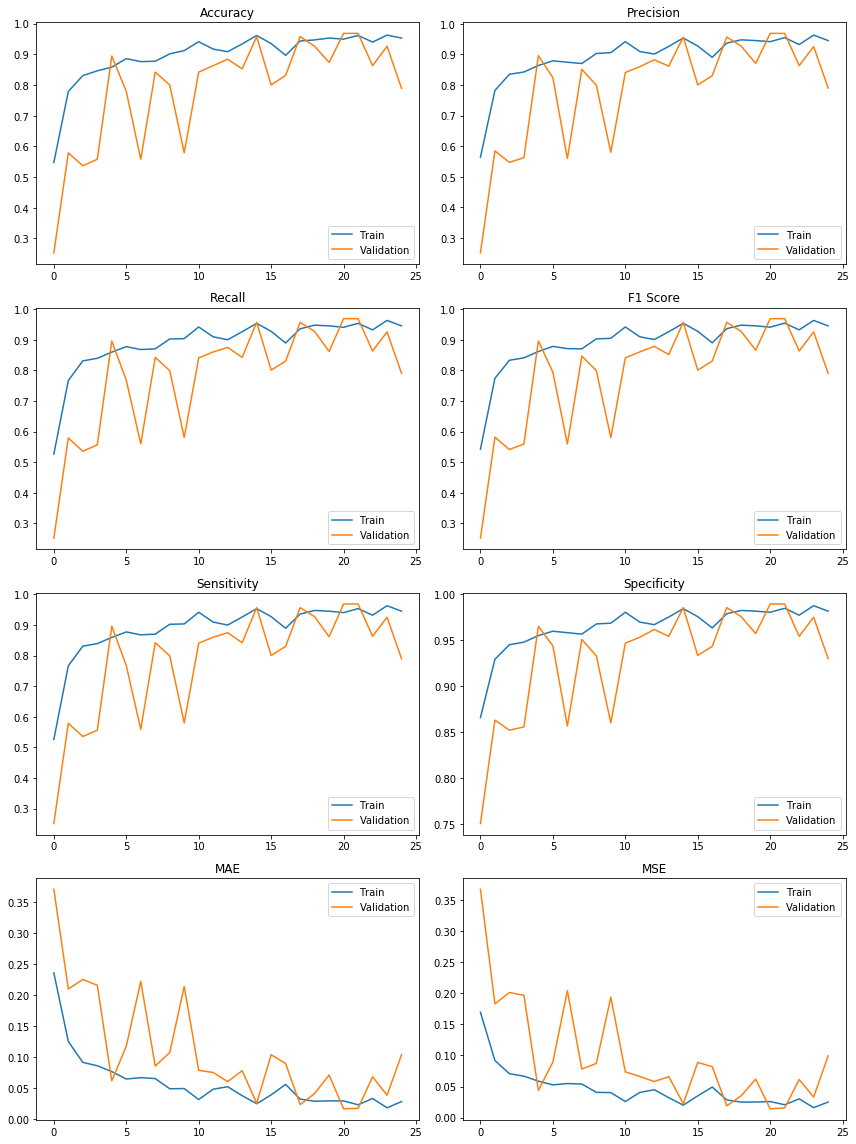

In [11]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


12/12 [==============================] - ETA: 3s - loss: 3.8406 - accuracy: 0.7500 - f1_score: 0.7500 - recall_m: 0.7500 - precision_m: 0.7500 - specificity_m: 0.9167 - sensitivity_m: 0.7500 - mae: 0.1188 - mse: 0.11 - ETA: 2s - loss: 4.9231 - accuracy: 0.6875 - f1_score: 0.6875 - recall_m: 0.6875 - precision_m: 0.6875 - specificity_m: 0.8958 - sensitivity_m: 0.6875 - mae: 0.1535 - mse: 0.14 - ETA: 2s - loss: 3.5064 - accuracy: 0.7083 - f1_score: 0.7083 - recall_m: 0.7083 - precision_m: 0.7083 - specificity_m: 0.9028 - sensitivity_m: 0.7083 - mae: 0.1398 - mse: 0.13 - ETA: 2s - loss: 3.6188 - accuracy: 0.7188 - f1_score: 0.7187 - recall_m: 0.7188 - precision_m: 0.7188 - specificity_m: 0.9063 - sensitivity_m: 0.7188 - mae: 0.1361 - mse: 0.13 - ETA: 2s - loss: 3.1154 - accuracy: 0.7500 - f1_score: 0.7500 - recall_m: 0.7500 - precision_m: 0.7500 - specificity_m: 0.9167 - sensitivity_m: 0.7500 - mae: 0.1214 - mse: 0.11 - ETA: 1s - loss: 2.7009 - accuracy: 0.7708 - f1_score: 0.7708 - recall

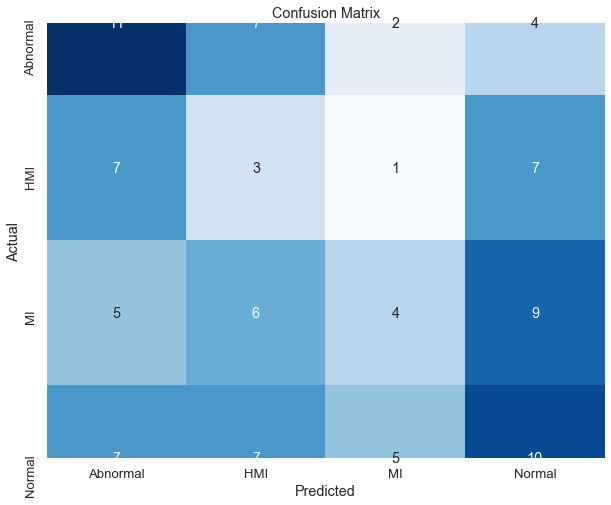

In [12]:
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [13]:
a = history.history['accuracy'][-1]
f = history.history['f1_score'][-1]
p = history.history['precision_m'][-1]
r = history.history['recall_m'][-1]
mae = history.history['mae'][-1]
mse = history.history['mse'][-1]
specificity = history.history['specificity_m'][-1]  
sensitivity = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a * 100))
print('Precision = ' + str(p * 100))
print('F1 Score = ' + str(f * 100))
print('Recall = ' + str(r * 100))
print('MAE = ' + str(mae))
print('MSE = ' + str(mse))
print('Sensitivity = ' + str(sensitivity * 100))  
print('Specificity = ' + str(specificity * 100))

Accuracy = 95.3181266784668
Precision = 94.52381134033203
F1 Score = 94.52381134033203
Recall = 94.52381134033203
MAE = 0.02791057713329792
MSE = 0.025074463337659836
Sensitivity = 94.52381134033203
Specificity = 98.17461967468262


# CNN - Adam

In [14]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

In [15]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])

history = model.fit(train_gen, epochs=10, batch_size=20, validation_data=val_gen)

Epoch 1/10


 45/105 [===========>..................] - ETA: 1:47 - loss: 1.1432 - accuracy: 0.6250 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3387 - mse: 0.15 - ETA: 38s - loss: 1.1379 - accuracy: 0.6875 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3359 - mse: 0.1567 - ETA: 38s - loss: 1.1677 - accuracy: 0.5833 - f1_score: 0.0741 - recall_m: 0.0417 - precision_m: 0.3333 - specificity_m: 1.0000 - sensitivity_m: 0.0417 - mae: 0.3373 - mse: 0.1600                - ETA: 37s - loss: 1.2743 - accuracy: 0.4688 - f1_score: 0.1111 - recall_m: 0.0625 - precision_m: 0.5000 - specificity_m: 1.0000 - sensitivity_m: 0.0625 - mae: 0.3485 - mse: 0.172 - ETA: 37s - loss: 1.2407 - accuracy: 0.4500 - f1_score: 0.1980 - recall_m: 0.1250 - precision_m: 0.6000 - specificity_m: 1.0000 - sensitivity_m: 0.1250 - mae: 0.3427 - mse: 0.168 - ETA: 37s

 91/105 [=========================>....] - ETA: 22s - loss: 1.1940 - accuracy: 0.5625 - f1_score: 0.0592 - recall_m: 0.0353 - precision_m: 0.2174 - specificity_m: 1.0000 - sensitivity_m: 0.0353 - mae: 0.3419 - mse: 0.161 - ETA: 22s - loss: 1.1927 - accuracy: 0.5638 - f1_score: 0.0579 - recall_m: 0.0346 - precision_m: 0.2128 - specificity_m: 1.0000 - sensitivity_m: 0.0346 - mae: 0.3417 - mse: 0.161 - ETA: 21s - loss: 1.1917 - accuracy: 0.5651 - f1_score: 0.0567 - recall_m: 0.0339 - precision_m: 0.2083 - specificity_m: 1.0000 - sensitivity_m: 0.0339 - mae: 0.3416 - mse: 0.161 - ETA: 21s - loss: 1.1906 - accuracy: 0.5612 - f1_score: 0.0556 - recall_m: 0.0332 - precision_m: 0.2041 - specificity_m: 1.0000 - sensitivity_m: 0.0332 - mae: 0.3414 - mse: 0.161 - ETA: 20s - loss: 1.1919 - accuracy: 0.5575 - f1_score: 0.0545 - recall_m: 0.0325 - precision_m: 0.2000 - specificity_m: 1.0000 - sensitivity_m: 0.0325 - mae: 0.3416 - mse: 0.161 - ETA: 20s - loss: 1.1910 - accuracy: 0.5564 - f1_score: 0.

105/105 [==============================] - ETA: 4s - loss: 1.1255 - accuracy: 0.5883 - f1_score: 0.1448 - recall_m: 0.0938 - precision_m: 0.4025 - specificity_m: 0.9968 - sensitivity_m: 0.0938 - mae: 0.3279 - mse: 0.15 - ETA: 4s - loss: 1.1249 - accuracy: 0.5901 - f1_score: 0.1457 - recall_m: 0.0941 - precision_m: 0.4090 - specificity_m: 0.9969 - sensitivity_m: 0.0941 - mae: 0.3278 - mse: 0.15 - ETA: 4s - loss: 1.1252 - accuracy: 0.5891 - f1_score: 0.1441 - recall_m: 0.0931 - precision_m: 0.4046 - specificity_m: 0.9965 - sensitivity_m: 0.0931 - mae: 0.3279 - mse: 0.15 - ETA: 3s - loss: 1.1222 - accuracy: 0.5921 - f1_score: 0.1483 - recall_m: 0.0961 - precision_m: 0.4109 - specificity_m: 0.9965 - sensitivity_m: 0.0961 - mae: 0.3273 - mse: 0.15 - ETA: 3s - loss: 1.1220 - accuracy: 0.5926 - f1_score: 0.1468 - recall_m: 0.0951 - precision_m: 0.4066 - specificity_m: 0.9965 - sensitivity_m: 0.0951 - mae: 0.3271 - mse: 0.15 - ETA: 3s - loss: 1.1199 - accuracy: 0.5943 - f1_score: 0.1476 - reca

 46/105 [============>.................] - ETA: 47s - loss: 1.0578 - accuracy: 0.6250 - f1_score: 0.7692 - recall_m: 0.6250 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 0.6250 - mae: 0.2699 - mse: 0.130 - ETA: 39s - loss: 1.1248 - accuracy: 0.4375 - f1_score: 0.5385 - recall_m: 0.4375 - precision_m: 0.7000 - specificity_m: 0.9375 - sensitivity_m: 0.4375 - mae: 0.2869 - mse: 0.152 - ETA: 38s - loss: 1.0621 - accuracy: 0.4583 - f1_score: 0.5641 - recall_m: 0.4583 - precision_m: 0.7333 - specificity_m: 0.9444 - sensitivity_m: 0.4583 - mae: 0.2785 - mse: 0.143 - ETA: 38s - loss: 1.0898 - accuracy: 0.4688 - f1_score: 0.4786 - recall_m: 0.3750 - precision_m: 0.8000 - specificity_m: 0.9583 - sensitivity_m: 0.3750 - mae: 0.2922 - mse: 0.148 - ETA: 38s - loss: 1.0672 - accuracy: 0.5250 - f1_score: 0.4920 - recall_m: 0.3750 - precision_m: 0.8400 - specificity_m: 0.9667 - sensitivity_m: 0.3750 - mae: 0.2922 - mse: 0.143 - ETA: 38s - loss: 1.0354 - accuracy: 0.5417 - f1_score: 0.

 92/105 [=========================>....] - ETA: 21s - loss: 0.8718 - accuracy: 0.6911 - f1_score: 0.4726 - recall_m: 0.3457 - precision_m: 0.8585 - specificity_m: 0.9849 - sensitivity_m: 0.3457 - mae: 0.2722 - mse: 0.118 - ETA: 21s - loss: 0.8719 - accuracy: 0.6923 - f1_score: 0.4766 - recall_m: 0.3490 - precision_m: 0.8615 - specificity_m: 0.9852 - sensitivity_m: 0.3490 - mae: 0.2724 - mse: 0.118 - ETA: 21s - loss: 0.8764 - accuracy: 0.6883 - f1_score: 0.4771 - recall_m: 0.3495 - precision_m: 0.8592 - specificity_m: 0.9847 - sensitivity_m: 0.3495 - mae: 0.2730 - mse: 0.118 - ETA: 20s - loss: 0.8714 - accuracy: 0.6896 - f1_score: 0.4829 - recall_m: 0.3550 - precision_m: 0.8620 - specificity_m: 0.9850 - sensitivity_m: 0.3550 - mae: 0.2719 - mse: 0.118 - ETA: 20s - loss: 0.8741 - accuracy: 0.6833 - f1_score: 0.4774 - recall_m: 0.3505 - precision_m: 0.8549 - specificity_m: 0.9845 - sensitivity_m: 0.3505 - mae: 0.2724 - mse: 0.118 - ETA: 20s - loss: 0.8733 - accuracy: 0.6822 - f1_score: 0.

105/105 [==============================] - ETA: 4s - loss: 0.8026 - accuracy: 0.7259 - f1_score: 0.5731 - recall_m: 0.4530 - precision_m: 0.8782 - specificity_m: 0.9830 - sensitivity_m: 0.4530 - mae: 0.2533 - mse: 0.10 - ETA: 4s - loss: 0.8008 - accuracy: 0.7262 - f1_score: 0.5752 - recall_m: 0.4548 - precision_m: 0.8795 - specificity_m: 0.9832 - sensitivity_m: 0.4548 - mae: 0.2528 - mse: 0.10 - ETA: 3s - loss: 0.7972 - accuracy: 0.7278 - f1_score: 0.5784 - recall_m: 0.4592 - precision_m: 0.8794 - specificity_m: 0.9829 - sensitivity_m: 0.4592 - mae: 0.2519 - mse: 0.10 - ETA: 3s - loss: 0.8001 - accuracy: 0.7254 - f1_score: 0.5787 - recall_m: 0.4596 - precision_m: 0.8786 - specificity_m: 0.9826 - sensitivity_m: 0.4596 - mae: 0.2519 - mse: 0.10 - ETA: 3s - loss: 0.7996 - accuracy: 0.7256 - f1_score: 0.5805 - recall_m: 0.4626 - precision_m: 0.8773 - specificity_m: 0.9820 - sensitivity_m: 0.4626 - mae: 0.2514 - mse: 0.10 - ETA: 2s - loss: 0.7962 - accuracy: 0.7272 - f1_score: 0.5841 - reca

 46/105 [============>.................] - ETA: 51s - loss: 0.7147 - accuracy: 0.6250 - f1_score: 0.5714 - recall_m: 0.5000 - precision_m: 0.6667 - specificity_m: 0.9167 - sensitivity_m: 0.5000 - mae: 0.2238 - mse: 0.107 - ETA: 40s - loss: 0.6754 - accuracy: 0.7500 - f1_score: 0.6703 - recall_m: 0.5625 - precision_m: 0.8333 - specificity_m: 0.9583 - sensitivity_m: 0.5625 - mae: 0.2209 - mse: 0.094 - ETA: 39s - loss: 0.6193 - accuracy: 0.7917 - f1_score: 0.7326 - recall_m: 0.6250 - precision_m: 0.8889 - specificity_m: 0.9722 - sensitivity_m: 0.6250 - mae: 0.2081 - mse: 0.084 - ETA: 39s - loss: 0.6300 - accuracy: 0.7812 - f1_score: 0.7033 - recall_m: 0.5938 - precision_m: 0.8667 - specificity_m: 0.9688 - sensitivity_m: 0.5938 - mae: 0.2125 - mse: 0.085 - ETA: 38s - loss: 0.6296 - accuracy: 0.7750 - f1_score: 0.7055 - recall_m: 0.6000 - precision_m: 0.8600 - specificity_m: 0.9667 - sensitivity_m: 0.6000 - mae: 0.2146 - mse: 0.086 - ETA: 32s - loss: 0.6426 - accuracy: 0.7805 - f1_score: 0.

 92/105 [=========================>....] - ETA: 22s - loss: 0.5697 - accuracy: 0.8347 - f1_score: 0.7808 - recall_m: 0.7074 - precision_m: 0.8888 - specificity_m: 0.9752 - sensitivity_m: 0.7074 - mae: 0.1906 - mse: 0.074 - ETA: 21s - loss: 0.5640 - accuracy: 0.8382 - f1_score: 0.7854 - recall_m: 0.7135 - precision_m: 0.8911 - specificity_m: 0.9757 - sensitivity_m: 0.7135 - mae: 0.1893 - mse: 0.073 - ETA: 21s - loss: 0.5627 - accuracy: 0.8390 - f1_score: 0.7872 - recall_m: 0.7168 - precision_m: 0.8908 - specificity_m: 0.9753 - sensitivity_m: 0.7168 - mae: 0.1883 - mse: 0.073 - ETA: 20s - loss: 0.5561 - accuracy: 0.8422 - f1_score: 0.7915 - recall_m: 0.7225 - precision_m: 0.8930 - specificity_m: 0.9758 - sensitivity_m: 0.7225 - mae: 0.1866 - mse: 0.072 - ETA: 20s - loss: 0.5574 - accuracy: 0.8429 - f1_score: 0.7931 - recall_m: 0.7255 - precision_m: 0.8926 - specificity_m: 0.9755 - sensitivity_m: 0.7255 - mae: 0.1861 - mse: 0.072 - ETA: 20s - loss: 0.5523 - accuracy: 0.8435 - f1_score: 0.

105/105 [==============================] - ETA: 4s - loss: 0.5245 - accuracy: 0.8480 - f1_score: 0.8123 - recall_m: 0.7487 - precision_m: 0.9024 - specificity_m: 0.9754 - sensitivity_m: 0.7487 - mae: 0.1762 - mse: 0.06 - ETA: 4s - loss: 0.5249 - accuracy: 0.8483 - f1_score: 0.8122 - recall_m: 0.7487 - precision_m: 0.9019 - specificity_m: 0.9752 - sensitivity_m: 0.7487 - mae: 0.1763 - mse: 0.06 - ETA: 3s - loss: 0.5229 - accuracy: 0.8486 - f1_score: 0.8129 - recall_m: 0.7500 - precision_m: 0.9016 - specificity_m: 0.9750 - sensitivity_m: 0.7500 - mae: 0.1756 - mse: 0.06 - ETA: 3s - loss: 0.5224 - accuracy: 0.8489 - f1_score: 0.8135 - recall_m: 0.7513 - precision_m: 0.9014 - specificity_m: 0.9748 - sensitivity_m: 0.7513 - mae: 0.1754 - mse: 0.06 - ETA: 3s - loss: 0.5241 - accuracy: 0.8479 - f1_score: 0.8134 - recall_m: 0.7513 - precision_m: 0.9009 - specificity_m: 0.9747 - sensitivity_m: 0.7513 - mae: 0.1757 - mse: 0.06 - ETA: 2s - loss: 0.5267 - accuracy: 0.8456 - f1_score: 0.8114 - reca

 46/105 [============>.................] - ETA: 47s - loss: 0.2828 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.1160 - mse: 0.029 - ETA: 40s - loss: 0.3535 - accuracy: 1.0000 - f1_score: 0.9286 - recall_m: 0.8750 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 0.8750 - mae: 0.1368 - mse: 0.043 - ETA: 39s - loss: 0.3666 - accuracy: 1.0000 - f1_score: 0.9524 - recall_m: 0.9167 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 0.9167 - mae: 0.1439 - mse: 0.044 - ETA: 38s - loss: 0.3871 - accuracy: 0.9688 - f1_score: 0.9476 - recall_m: 0.9062 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 0.9062 - mae: 0.1490 - mse: 0.046 - ETA: 38s - loss: 0.4022 - accuracy: 0.9250 - f1_score: 0.9181 - recall_m: 0.8750 - precision_m: 0.9714 - specificity_m: 0.9917 - sensitivity_m: 0.8750 - mae: 0.1499 - mse: 0.049 - ETA: 37s - loss: 0.3805 - accuracy: 0.9375 - f1_score: 0.

 92/105 [=========================>....] - ETA: 22s - loss: 0.3298 - accuracy: 0.9160 - f1_score: 0.9125 - recall_m: 0.8936 - precision_m: 0.9359 - specificity_m: 0.9814 - sensitivity_m: 0.8936 - mae: 0.1213 - mse: 0.041 - ETA: 21s - loss: 0.3359 - accuracy: 0.9151 - f1_score: 0.9117 - recall_m: 0.8932 - precision_m: 0.9346 - specificity_m: 0.9809 - sensitivity_m: 0.8932 - mae: 0.1216 - mse: 0.041 - ETA: 21s - loss: 0.3330 - accuracy: 0.9169 - f1_score: 0.9135 - recall_m: 0.8954 - precision_m: 0.9360 - specificity_m: 0.9813 - sensitivity_m: 0.8954 - mae: 0.1208 - mse: 0.041 - ETA: 20s - loss: 0.3316 - accuracy: 0.9160 - f1_score: 0.9127 - recall_m: 0.8950 - precision_m: 0.9347 - specificity_m: 0.9808 - sensitivity_m: 0.8950 - mae: 0.1205 - mse: 0.041 - ETA: 20s - loss: 0.3293 - accuracy: 0.9177 - f1_score: 0.9144 - recall_m: 0.8971 - precision_m: 0.9360 - specificity_m: 0.9812 - sensitivity_m: 0.8971 - mae: 0.1199 - mse: 0.040 - ETA: 20s - loss: 0.3290 - accuracy: 0.9169 - f1_score: 0.

105/105 [==============================] - ETA: 4s - loss: 0.3305 - accuracy: 0.9145 - f1_score: 0.9104 - recall_m: 0.8938 - precision_m: 0.9304 - specificity_m: 0.9785 - sensitivity_m: 0.8938 - mae: 0.1150 - mse: 0.04 - ETA: 4s - loss: 0.3354 - accuracy: 0.9114 - f1_score: 0.9073 - recall_m: 0.8896 - precision_m: 0.9290 - specificity_m: 0.9783 - sensitivity_m: 0.8896 - mae: 0.1161 - mse: 0.04 - ETA: 3s - loss: 0.3341 - accuracy: 0.9124 - f1_score: 0.9083 - recall_m: 0.8908 - precision_m: 0.9297 - specificity_m: 0.9785 - sensitivity_m: 0.8908 - mae: 0.1158 - mse: 0.04 - ETA: 3s - loss: 0.3357 - accuracy: 0.9120 - f1_score: 0.9077 - recall_m: 0.8893 - precision_m: 0.9304 - specificity_m: 0.9787 - sensitivity_m: 0.8893 - mae: 0.1162 - mse: 0.04 - ETA: 3s - loss: 0.3363 - accuracy: 0.9116 - f1_score: 0.9074 - recall_m: 0.8892 - precision_m: 0.9299 - specificity_m: 0.9785 - sensitivity_m: 0.8892 - mae: 0.1164 - mse: 0.04 - ETA: 2s - loss: 0.3385 - accuracy: 0.9099 - f1_score: 0.9058 - reca

 46/105 [============>.................] - ETA: 48s - loss: 0.5279 - accuracy: 0.8750 - f1_score: 0.9333 - recall_m: 0.8750 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 0.8750 - mae: 0.1428 - mse: 0.056 - ETA: 39s - loss: 0.5362 - accuracy: 0.8125 - f1_score: 0.8667 - recall_m: 0.8125 - precision_m: 0.9286 - specificity_m: 0.9792 - sensitivity_m: 0.8125 - mae: 0.1445 - mse: 0.065 - ETA: 39s - loss: 0.4356 - accuracy: 0.8333 - f1_score: 0.8694 - recall_m: 0.8333 - precision_m: 0.9107 - specificity_m: 0.9722 - sensitivity_m: 0.8333 - mae: 0.1228 - mse: 0.055 - ETA: 39s - loss: 0.3894 - accuracy: 0.8438 - f1_score: 0.8854 - recall_m: 0.8438 - precision_m: 0.9330 - specificity_m: 0.9792 - sensitivity_m: 0.8438 - mae: 0.1167 - mse: 0.049 - ETA: 38s - loss: 0.4320 - accuracy: 0.8250 - f1_score: 0.8583 - recall_m: 0.8250 - precision_m: 0.8964 - specificity_m: 0.9667 - sensitivity_m: 0.8250 - mae: 0.1232 - mse: 0.058 - ETA: 38s - loss: 0.4186 - accuracy: 0.8542 - f1_score: 0.

 92/105 [=========================>....] - ETA: 22s - loss: 0.3226 - accuracy: 0.9024 - f1_score: 0.8804 - recall_m: 0.8590 - precision_m: 0.9060 - specificity_m: 0.9707 - sensitivity_m: 0.8590 - mae: 0.1115 - mse: 0.044 - ETA: 21s - loss: 0.3278 - accuracy: 0.8992 - f1_score: 0.8799 - recall_m: 0.8568 - precision_m: 0.9080 - specificity_m: 0.9714 - sensitivity_m: 0.8568 - mae: 0.1126 - mse: 0.045 - ETA: 21s - loss: 0.3345 - accuracy: 0.8987 - f1_score: 0.8782 - recall_m: 0.8546 - precision_m: 0.9069 - specificity_m: 0.9711 - sensitivity_m: 0.8546 - mae: 0.1142 - mse: 0.046 - ETA: 21s - loss: 0.3392 - accuracy: 0.8957 - f1_score: 0.8750 - recall_m: 0.8500 - precision_m: 0.9055 - specificity_m: 0.9708 - sensitivity_m: 0.8500 - mae: 0.1157 - mse: 0.047 - ETA: 20s - loss: 0.3440 - accuracy: 0.8953 - f1_score: 0.8750 - recall_m: 0.8505 - precision_m: 0.9049 - specificity_m: 0.9706 - sensitivity_m: 0.8505 - mae: 0.1166 - mse: 0.047 - ETA: 20s - loss: 0.3495 - accuracy: 0.8949 - f1_score: 0.

105/105 [==============================] - ETA: 4s - loss: 0.3269 - accuracy: 0.9104 - f1_score: 0.8952 - recall_m: 0.8696 - precision_m: 0.9271 - specificity_m: 0.9776 - sensitivity_m: 0.8696 - mae: 0.1143 - mse: 0.04 - ETA: 4s - loss: 0.3251 - accuracy: 0.9114 - f1_score: 0.8956 - recall_m: 0.8697 - precision_m: 0.9279 - specificity_m: 0.9778 - sensitivity_m: 0.8697 - mae: 0.1137 - mse: 0.04 - ETA: 3s - loss: 0.3236 - accuracy: 0.9124 - f1_score: 0.8967 - recall_m: 0.8711 - precision_m: 0.9286 - specificity_m: 0.9781 - sensitivity_m: 0.8711 - mae: 0.1133 - mse: 0.04 - ETA: 3s - loss: 0.3217 - accuracy: 0.9133 - f1_score: 0.8978 - recall_m: 0.8724 - precision_m: 0.9294 - specificity_m: 0.9783 - sensitivity_m: 0.8724 - mae: 0.1128 - mse: 0.04 - ETA: 3s - loss: 0.3199 - accuracy: 0.9142 - f1_score: 0.8989 - recall_m: 0.8737 - precision_m: 0.9301 - specificity_m: 0.9785 - sensitivity_m: 0.8737 - mae: 0.1123 - mse: 0.04 - ETA: 2s - loss: 0.3176 - accuracy: 0.9151 - f1_score: 0.8999 - reca

 46/105 [============>.................] - ETA: 49s - loss: 0.1069 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0446 - mse: 0.009 - ETA: 39s - loss: 0.2092 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0748 - mse: 0.023 - ETA: 38s - loss: 0.2233 - accuracy: 0.9167 - f1_score: 0.8917 - recall_m: 0.8750 - precision_m: 0.9107 - specificity_m: 0.9722 - sensitivity_m: 0.8750 - mae: 0.0817 - mse: 0.026 - ETA: 38s - loss: 0.1870 - accuracy: 0.9375 - f1_score: 0.9187 - recall_m: 0.9062 - precision_m: 0.9330 - specificity_m: 0.9792 - sensitivity_m: 0.9062 - mae: 0.0703 - mse: 0.021 - ETA: 38s - loss: 0.2025 - accuracy: 0.9500 - f1_score: 0.9350 - recall_m: 0.9250 - precision_m: 0.9464 - specificity_m: 0.9833 - sensitivity_m: 0.9250 - mae: 0.0785 - mse: 0.022 - ETA: 38s - loss: 0.1714 - accuracy: 0.9583 - f1_score: 0.

 92/105 [=========================>....] - ETA: 23s - loss: 0.1900 - accuracy: 0.9593 - f1_score: 0.9567 - recall_m: 0.9521 - precision_m: 0.9620 - specificity_m: 0.9876 - sensitivity_m: 0.9521 - mae: 0.0685 - mse: 0.021 - ETA: 23s - loss: 0.1879 - accuracy: 0.9602 - f1_score: 0.9576 - recall_m: 0.9531 - precision_m: 0.9628 - specificity_m: 0.9878 - sensitivity_m: 0.9531 - mae: 0.0679 - mse: 0.021 - ETA: 22s - loss: 0.1876 - accuracy: 0.9584 - f1_score: 0.9560 - recall_m: 0.9515 - precision_m: 0.9610 - specificity_m: 0.9872 - sensitivity_m: 0.9515 - mae: 0.0679 - mse: 0.021 - ETA: 22s - loss: 0.1900 - accuracy: 0.9567 - f1_score: 0.9543 - recall_m: 0.9500 - precision_m: 0.9593 - specificity_m: 0.9867 - sensitivity_m: 0.9500 - mae: 0.0685 - mse: 0.021 - ETA: 21s - loss: 0.1931 - accuracy: 0.9551 - f1_score: 0.9528 - recall_m: 0.9485 - precision_m: 0.9576 - specificity_m: 0.9861 - sensitivity_m: 0.9485 - mae: 0.0687 - mse: 0.022 - ETA: 21s - loss: 0.1936 - accuracy: 0.9535 - f1_score: 0.

105/105 [==============================] - ETA: 4s - loss: 0.1825 - accuracy: 0.9579 - f1_score: 0.9596 - recall_m: 0.9530 - precision_m: 0.9674 - specificity_m: 0.9892 - sensitivity_m: 0.9530 - mae: 0.0650 - mse: 0.02 - ETA: 4s - loss: 0.1826 - accuracy: 0.9584 - f1_score: 0.9600 - recall_m: 0.9535 - precision_m: 0.9677 - specificity_m: 0.9894 - sensitivity_m: 0.9535 - mae: 0.0651 - mse: 0.02 - ETA: 3s - loss: 0.1813 - accuracy: 0.9588 - f1_score: 0.9604 - recall_m: 0.9539 - precision_m: 0.9680 - specificity_m: 0.9895 - sensitivity_m: 0.9539 - mae: 0.0647 - mse: 0.02 - ETA: 3s - loss: 0.1815 - accuracy: 0.9580 - f1_score: 0.9595 - recall_m: 0.9531 - precision_m: 0.9671 - specificity_m: 0.9891 - sensitivity_m: 0.9531 - mae: 0.0647 - mse: 0.02 - ETA: 3s - loss: 0.1805 - accuracy: 0.9584 - f1_score: 0.9600 - recall_m: 0.9536 - precision_m: 0.9674 - specificity_m: 0.9893 - sensitivity_m: 0.9536 - mae: 0.0644 - mse: 0.02 - ETA: 2s - loss: 0.1810 - accuracy: 0.9588 - f1_score: 0.9604 - reca

 46/105 [============>.................] - ETA: 48s - loss: 0.2147 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0677 - mse: 0.034 - ETA: 40s - loss: 0.1598 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0575 - mse: 0.021 - ETA: 39s - loss: 0.1280 - accuracy: 0.9583 - f1_score: 0.9583 - recall_m: 0.9583 - precision_m: 0.9583 - specificity_m: 0.9861 - sensitivity_m: 0.9583 - mae: 0.0484 - mse: 0.014 - ETA: 39s - loss: 0.2102 - accuracy: 0.9062 - f1_score: 0.9062 - recall_m: 0.9062 - precision_m: 0.9062 - specificity_m: 0.9688 - sensitivity_m: 0.9062 - mae: 0.0645 - mse: 0.029 - ETA: 39s - loss: 0.2217 - accuracy: 0.9000 - f1_score: 0.9000 - recall_m: 0.9000 - precision_m: 0.9000 - specificity_m: 0.9667 - sensitivity_m: 0.9000 - mae: 0.0700 - mse: 0.032 - ETA: 39s - loss: 0.2010 - accuracy: 0.9167 - f1_score: 0.

 92/105 [=========================>....] - ETA: 22s - loss: 0.1456 - accuracy: 0.9601 - f1_score: 0.9567 - recall_m: 0.9495 - precision_m: 0.9654 - specificity_m: 0.9885 - sensitivity_m: 0.9495 - mae: 0.0538 - mse: 0.017 - ETA: 22s - loss: 0.1460 - accuracy: 0.9609 - f1_score: 0.9576 - recall_m: 0.9505 - precision_m: 0.9661 - specificity_m: 0.9887 - sensitivity_m: 0.9505 - mae: 0.0541 - mse: 0.017 - ETA: 22s - loss: 0.1443 - accuracy: 0.9617 - f1_score: 0.9585 - recall_m: 0.9515 - precision_m: 0.9668 - specificity_m: 0.9889 - sensitivity_m: 0.9515 - mae: 0.0536 - mse: 0.017 - ETA: 21s - loss: 0.1434 - accuracy: 0.9625 - f1_score: 0.9593 - recall_m: 0.9525 - precision_m: 0.9675 - specificity_m: 0.9892 - sensitivity_m: 0.9525 - mae: 0.0535 - mse: 0.017 - ETA: 21s - loss: 0.1415 - accuracy: 0.9632 - f1_score: 0.9601 - recall_m: 0.9534 - precision_m: 0.9681 - specificity_m: 0.9894 - sensitivity_m: 0.9534 - mae: 0.0529 - mse: 0.016 - ETA: 20s - loss: 0.1409 - accuracy: 0.9639 - f1_score: 0.

105/105 [==============================] - ETA: 4s - loss: 0.1231 - accuracy: 0.9729 - f1_score: 0.9714 - recall_m: 0.9677 - precision_m: 0.9758 - specificity_m: 0.9919 - sensitivity_m: 0.9677 - mae: 0.0474 - mse: 0.01 - ETA: 4s - loss: 0.1227 - accuracy: 0.9732 - f1_score: 0.9717 - recall_m: 0.9681 - precision_m: 0.9761 - specificity_m: 0.9920 - sensitivity_m: 0.9681 - mae: 0.0473 - mse: 0.01 - ETA: 3s - loss: 0.1236 - accuracy: 0.9708 - f1_score: 0.9694 - recall_m: 0.9658 - precision_m: 0.9737 - specificity_m: 0.9912 - sensitivity_m: 0.9658 - mae: 0.0476 - mse: 0.01 - ETA: 3s - loss: 0.1233 - accuracy: 0.9711 - f1_score: 0.9697 - recall_m: 0.9661 - precision_m: 0.9740 - specificity_m: 0.9913 - sensitivity_m: 0.9661 - mae: 0.0475 - mse: 0.01 - ETA: 3s - loss: 0.1237 - accuracy: 0.9701 - f1_score: 0.9687 - recall_m: 0.9652 - precision_m: 0.9729 - specificity_m: 0.9910 - sensitivity_m: 0.9652 - mae: 0.0476 - mse: 0.01 - ETA: 2s - loss: 0.1234 - accuracy: 0.9704 - f1_score: 0.9690 - reca

 46/105 [============>.................] - ETA: 48s - loss: 0.0813 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0370 - mse: 0.004 - ETA: 38s - loss: 0.0932 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0407 - mse: 0.006 - ETA: 39s - loss: 0.0995 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0441 - mse: 0.007 - ETA: 38s - loss: 0.0941 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0419 - mse: 0.006 - ETA: 38s - loss: 0.0825 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0370 - mse: 0.005 - ETA: 38s - loss: 0.0743 - accuracy: 1.0000 - f1_score: 1.

 92/105 [=========================>....] - ETA: 22s - loss: 0.0718 - accuracy: 0.9946 - f1_score: 0.9947 - recall_m: 0.9947 - precision_m: 0.9947 - specificity_m: 0.9982 - sensitivity_m: 0.9947 - mae: 0.0310 - mse: 0.005 - ETA: 21s - loss: 0.0716 - accuracy: 0.9947 - f1_score: 0.9948 - recall_m: 0.9948 - precision_m: 0.9948 - specificity_m: 0.9983 - sensitivity_m: 0.9948 - mae: 0.0310 - mse: 0.005 - ETA: 21s - loss: 0.0736 - accuracy: 0.9948 - f1_score: 0.9949 - recall_m: 0.9949 - precision_m: 0.9949 - specificity_m: 0.9983 - sensitivity_m: 0.9949 - mae: 0.0318 - mse: 0.005 - ETA: 21s - loss: 0.0734 - accuracy: 0.9949 - f1_score: 0.9950 - recall_m: 0.9950 - precision_m: 0.9950 - specificity_m: 0.9983 - sensitivity_m: 0.9950 - mae: 0.0317 - mse: 0.005 - ETA: 20s - loss: 0.0731 - accuracy: 0.9950 - f1_score: 0.9951 - recall_m: 0.9951 - precision_m: 0.9951 - specificity_m: 0.9984 - sensitivity_m: 0.9951 - mae: 0.0317 - mse: 0.005 - ETA: 20s - loss: 0.0728 - accuracy: 0.9951 - f1_score: 0.

105/105 [==============================] - ETA: 4s - loss: 0.0812 - accuracy: 0.9851 - f1_score: 0.9858 - recall_m: 0.9852 - precision_m: 0.9864 - specificity_m: 0.9955 - sensitivity_m: 0.9852 - mae: 0.0333 - mse: 0.00 - ETA: 4s - loss: 0.0812 - accuracy: 0.9852 - f1_score: 0.9859 - recall_m: 0.9854 - precision_m: 0.9865 - specificity_m: 0.9956 - sensitivity_m: 0.9854 - mae: 0.0334 - mse: 0.00 - ETA: 4s - loss: 0.0806 - accuracy: 0.9854 - f1_score: 0.9861 - recall_m: 0.9855 - precision_m: 0.9867 - specificity_m: 0.9956 - sensitivity_m: 0.9855 - mae: 0.0332 - mse: 0.00 - ETA: 3s - loss: 0.0810 - accuracy: 0.9855 - f1_score: 0.9862 - recall_m: 0.9857 - precision_m: 0.9868 - specificity_m: 0.9957 - sensitivity_m: 0.9857 - mae: 0.0334 - mse: 0.00 - ETA: 3s - loss: 0.0822 - accuracy: 0.9844 - f1_score: 0.9857 - recall_m: 0.9845 - precision_m: 0.9869 - specificity_m: 0.9957 - sensitivity_m: 0.9845 - mae: 0.0337 - mse: 0.00 - ETA: 2s - loss: 0.0817 - accuracy: 0.9846 - f1_score: 0.9858 - reca

 46/105 [============>.................] - ETA: 49s - loss: 0.0841 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0365 - mse: 0.008 - ETA: 39s - loss: 0.0738 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0331 - mse: 0.005 - ETA: 39s - loss: 0.0608 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0277 - mse: 0.004 - ETA: 38s - loss: 0.0625 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0284 - mse: 0.004 - ETA: 38s - loss: 0.0555 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0253 - mse: 0.003 - ETA: 37s - loss: 0.0497 - accuracy: 1.0000 - f1_score: 1.

 92/105 [=========================>....] - ETA: 22s - loss: 0.0501 - accuracy: 0.9946 - f1_score: 0.9947 - recall_m: 0.9947 - precision_m: 0.9947 - specificity_m: 0.9982 - sensitivity_m: 0.9947 - mae: 0.0224 - mse: 0.003 - ETA: 22s - loss: 0.0513 - accuracy: 0.9920 - f1_score: 0.9922 - recall_m: 0.9922 - precision_m: 0.9922 - specificity_m: 0.9974 - sensitivity_m: 0.9922 - mae: 0.0228 - mse: 0.004 - ETA: 21s - loss: 0.0514 - accuracy: 0.9922 - f1_score: 0.9923 - recall_m: 0.9923 - precision_m: 0.9923 - specificity_m: 0.9974 - sensitivity_m: 0.9923 - mae: 0.0229 - mse: 0.004 - ETA: 21s - loss: 0.0519 - accuracy: 0.9924 - f1_score: 0.9925 - recall_m: 0.9925 - precision_m: 0.9925 - specificity_m: 0.9975 - sensitivity_m: 0.9925 - mae: 0.0230 - mse: 0.004 - ETA: 20s - loss: 0.0532 - accuracy: 0.9925 - f1_score: 0.9926 - recall_m: 0.9926 - precision_m: 0.9926 - specificity_m: 0.9975 - sensitivity_m: 0.9926 - mae: 0.0235 - mse: 0.004 - ETA: 20s - loss: 0.0525 - accuracy: 0.9927 - f1_score: 0.

105/105 [==============================] - ETA: 4s - loss: 0.0469 - accuracy: 0.9932 - f1_score: 0.9933 - recall_m: 0.9933 - precision_m: 0.9933 - specificity_m: 0.9978 - sensitivity_m: 0.9933 - mae: 0.0207 - mse: 0.00 - ETA: 4s - loss: 0.0467 - accuracy: 0.9933 - f1_score: 0.9934 - recall_m: 0.9934 - precision_m: 0.9934 - specificity_m: 0.9978 - sensitivity_m: 0.9934 - mae: 0.0206 - mse: 0.00 - ETA: 3s - loss: 0.0467 - accuracy: 0.9934 - f1_score: 0.9934 - recall_m: 0.9934 - precision_m: 0.9934 - specificity_m: 0.9978 - sensitivity_m: 0.9934 - mae: 0.0206 - mse: 0.00 - ETA: 3s - loss: 0.0467 - accuracy: 0.9934 - f1_score: 0.9935 - recall_m: 0.9935 - precision_m: 0.9935 - specificity_m: 0.9978 - sensitivity_m: 0.9935 - mae: 0.0206 - mse: 0.00 - ETA: 3s - loss: 0.0466 - accuracy: 0.9935 - f1_score: 0.9936 - recall_m: 0.9936 - precision_m: 0.9936 - specificity_m: 0.9979 - sensitivity_m: 0.9936 - mae: 0.0206 - mse: 0.00 - ETA: 2s - loss: 0.0467 - accuracy: 0.9936 - f1_score: 0.9936 - reca

 45/105 [===========>..................] - ETA: 48s - loss: 0.0140 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0069 - mse: 1.3033e-0 - ETA: 39s - loss: 0.0169 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0082 - mse: 3.9641e-0 - ETA: 38s - loss: 0.0148 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0073 - mse: 2.9283e-0 - ETA: 39s - loss: 0.0132 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0064 - mse: 2.4999e-0 - ETA: 38s - loss: 0.0141 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0069 - mse: 2.5960e-0 - ETA: 38s - loss: 0.0205 - accuracy: 1

 91/105 [=========================>....] - ETA: 23s - loss: 0.0275 - accuracy: 0.9973 - f1_score: 0.9973 - recall_m: 0.9973 - precision_m: 0.9973 - specificity_m: 0.9991 - sensitivity_m: 0.9973 - mae: 0.0124 - mse: 0.001 - ETA: 22s - loss: 0.0275 - accuracy: 0.9973 - f1_score: 0.9973 - recall_m: 0.9973 - precision_m: 0.9973 - specificity_m: 0.9991 - sensitivity_m: 0.9973 - mae: 0.0124 - mse: 0.001 - ETA: 22s - loss: 0.0272 - accuracy: 0.9974 - f1_score: 0.9974 - recall_m: 0.9974 - precision_m: 0.9974 - specificity_m: 0.9991 - sensitivity_m: 0.9974 - mae: 0.0123 - mse: 0.001 - ETA: 21s - loss: 0.0267 - accuracy: 0.9974 - f1_score: 0.9974 - recall_m: 0.9974 - precision_m: 0.9974 - specificity_m: 0.9991 - sensitivity_m: 0.9974 - mae: 0.0121 - mse: 0.001 - ETA: 21s - loss: 0.0263 - accuracy: 0.9975 - f1_score: 0.9975 - recall_m: 0.9975 - precision_m: 0.9975 - specificity_m: 0.9992 - sensitivity_m: 0.9975 - mae: 0.0119 - mse: 0.001 - ETA: 21s - loss: 0.0261 - accuracy: 0.9975 - f1_score: 0.

105/105 [==============================] - ETA: 5s - loss: 0.0257 - accuracy: 0.9973 - f1_score: 0.9973 - recall_m: 0.9973 - precision_m: 0.9973 - specificity_m: 0.9991 - sensitivity_m: 0.9973 - mae: 0.0119 - mse: 0.00 - ETA: 4s - loss: 0.0261 - accuracy: 0.9973 - f1_score: 0.9973 - recall_m: 0.9973 - precision_m: 0.9973 - specificity_m: 0.9991 - sensitivity_m: 0.9973 - mae: 0.0120 - mse: 0.00 - ETA: 4s - loss: 0.0261 - accuracy: 0.9973 - f1_score: 0.9973 - recall_m: 0.9973 - precision_m: 0.9973 - specificity_m: 0.9991 - sensitivity_m: 0.9973 - mae: 0.0120 - mse: 0.00 - ETA: 4s - loss: 0.0261 - accuracy: 0.9973 - f1_score: 0.9974 - recall_m: 0.9974 - precision_m: 0.9974 - specificity_m: 0.9991 - sensitivity_m: 0.9974 - mae: 0.0120 - mse: 0.00 - ETA: 3s - loss: 0.0259 - accuracy: 0.9974 - f1_score: 0.9974 - recall_m: 0.9974 - precision_m: 0.9974 - specificity_m: 0.9991 - sensitivity_m: 0.9974 - mae: 0.0120 - mse: 0.00 - ETA: 3s - loss: 0.0260 - accuracy: 0.9974 - f1_score: 0.9974 - reca

In [18]:
model.save('models/cnn_adam.h5')

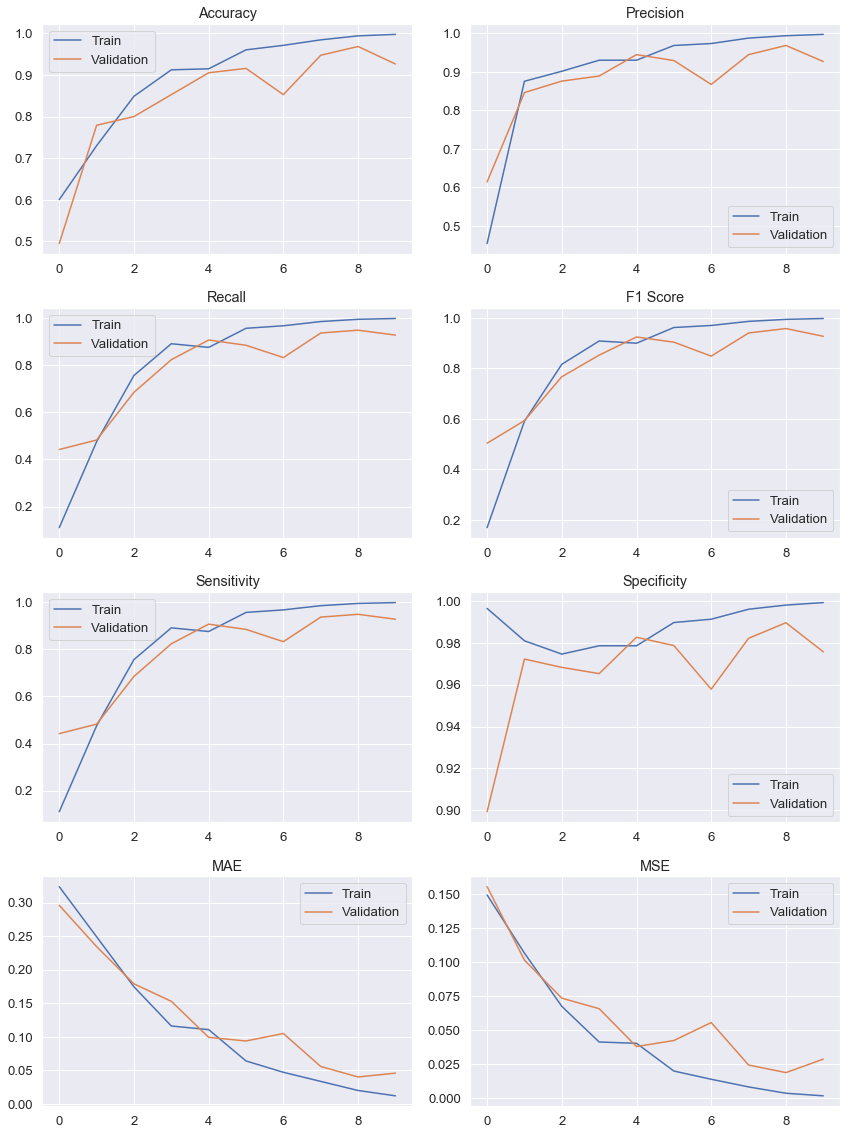

In [19]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


12/12 [==============================] - ETA: 3s - loss: 0.2993 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0637 - mse: 0.04 - ETA: 2s - loss: 0.1705 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0414 - mse: 0.02 - ETA: 2s - loss: 0.1168 - accuracy: 0.9583 - f1_score: 0.9583 - recall_m: 0.9583 - precision_m: 0.9583 - specificity_m: 0.9861 - sensitivity_m: 0.9583 - mae: 0.0291 - mse: 0.01 - ETA: 2s - loss: 0.0928 - accuracy: 0.9688 - f1_score: 0.9688 - recall_m: 0.9688 - precision_m: 0.9688 - specificity_m: 0.9896 - sensitivity_m: 0.9688 - mae: 0.0244 - mse: 0.01 - ETA: 2s - loss: 0.0822 - accuracy: 0.9750 - f1_score: 0.9750 - recall_m: 0.9750 - precision_m: 0.9750 - specificity_m: 0.9917 - sensitivity_m: 0.9750 - mae: 0.0234 - mse: 0.01 - ETA: 1s - loss: 0.1070 - accuracy: 0.9583 - f1_score: 0.9583 - recall

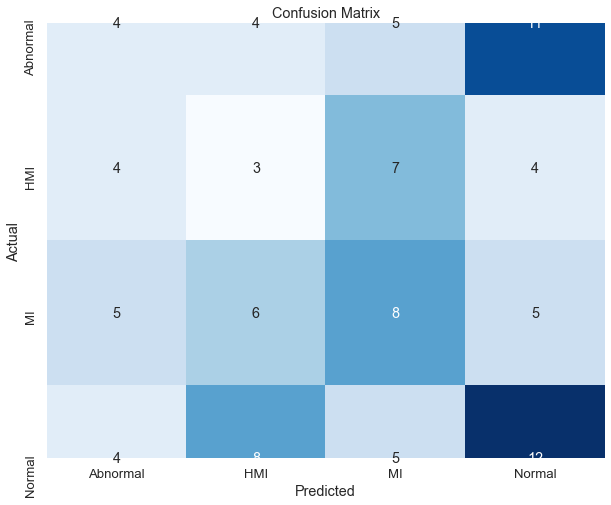

In [20]:
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [21]:
a1 = history.history['accuracy'][-1]
f1 = history.history['f1_score'][-1]
p1 = history.history['precision_m'][-1]
r1 = history.history['recall_m'][-1]
mae1 = history.history['mae'][-1]
mse1 = history.history['mse'][-1]
specificity1 = history.history['specificity_m'][-1]  
sensitivity1 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a1 * 100))
print('Precision = ' + str(p1 * 100))
print('F1 Score = ' + str(f1 * 100))
print('Recall = ' + str(r1 * 100))
print('MAE = ' + str(mae1))
print('MSE = ' + str(mse1))
print('Sensitivity = ' + str(sensitivity1 * 100))  
print('Specificity = ' + str(specificity1 * 100))

Accuracy = 99.75990653038025
Precision = 99.76190328598022
F1 Score = 99.76190328598022
Recall = 99.76190328598022
MAE = 0.011932387948036194
MSE = 0.0015000824350863695
Sensitivity = 99.76190328598022
Specificity = 99.92063045501709


# ANN-ADAM

In [42]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

In [43]:
model = models.Sequential()

model.add(layers.Flatten(input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3)))  
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5)) 

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(4, activation='softmax')) 


In [52]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])

history = model.fit(train_gen, epochs=25, batch_size=5, validation_data=val_gen)

Epoch 1/25


 42/105 [===========>..................] - ETA: 1:37 - loss: 1.5073 - accuracy: 0.1250 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3865 - mse: 0.20 - ETA: 34s - loss: 1.4300 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3777 - mse: 0.1924 - ETA: 33s - loss: 1.4441 - accuracy: 0.2083 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3795 - mse: 0.194 - ETA: 33s - loss: 1.4492 - accuracy: 0.1875 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3801 - mse: 0.194 - ETA: 32s - loss: 1.4234 - accuracy: 0.2000 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae

 84/105 [=======================>......] - ETA: 19s - loss: 1.3707 - accuracy: 0.3140 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3710 - mse: 0.185 - ETA: 19s - loss: 1.3692 - accuracy: 0.3125 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3708 - mse: 0.185 - ETA: 19s - loss: 1.3659 - accuracy: 0.3222 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3704 - mse: 0.185 - ETA: 18s - loss: 1.3673 - accuracy: 0.3234 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3705 - mse: 0.185 - ETA: 18s - loss: 1.3672 - accuracy: 0.3218 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 6s - loss: 1.3680 - accuracy: 0.3165 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3704 - mse: 0.18 - ETA: 6s - loss: 1.3667 - accuracy: 0.3186 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3703 - mse: 0.18 - ETA: 5s - loss: 1.3671 - accuracy: 0.3193 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3703 - mse: 0.18 - ETA: 5s - loss: 1.3673 - accuracy: 0.3199 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3703 - mse: 0.18 - ETA: 5s - loss: 1.3674 - accuracy: 0.3177 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3703 -

 42/105 [===========>..................] - ETA: 38s - loss: 1.4723 - accuracy: 0.1250 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3830 - mse: 0.197 - ETA: 35s - loss: 1.4423 - accuracy: 0.1875 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3795 - mse: 0.194 - ETA: 35s - loss: 1.4357 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3783 - mse: 0.192 - ETA: 35s - loss: 1.4236 - accuracy: 0.2188 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3772 - mse: 0.191 - ETA: 35s - loss: 1.4099 - accuracy: 0.2250 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

 84/105 [=======================>......] - ETA: 21s - loss: 1.3744 - accuracy: 0.3145 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3708 - mse: 0.185 - ETA: 21s - loss: 1.3755 - accuracy: 0.3101 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3710 - mse: 0.185 - ETA: 20s - loss: 1.3794 - accuracy: 0.3088 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.186 - ETA: 20s - loss: 1.3777 - accuracy: 0.3158 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3712 - mse: 0.185 - ETA: 20s - loss: 1.3768 - accuracy: 0.3171 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 6s - loss: 1.3769 - accuracy: 0.3076 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.18 - ETA: 6s - loss: 1.3761 - accuracy: 0.3069 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 - mse: 0.18 - ETA: 6s - loss: 1.3769 - accuracy: 0.3033 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.18 - ETA: 5s - loss: 1.3758 - accuracy: 0.3056 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 - mse: 0.18 - ETA: 5s - loss: 1.3753 - accuracy: 0.3064 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 -

 42/105 [===========>..................] - ETA: 37s - loss: 1.3449 - accuracy: 0.3750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3680 - mse: 0.182 - ETA: 35s - loss: 1.3449 - accuracy: 0.3750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3680 - mse: 0.182 - ETA: 35s - loss: 1.3343 - accuracy: 0.3333 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3670 - mse: 0.181 - ETA: 34s - loss: 1.3139 - accuracy: 0.4062 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3644 - mse: 0.179 - ETA: 34s - loss: 1.3101 - accuracy: 0.4500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

 84/105 [=======================>......] - ETA: 22s - loss: 1.3625 - accuracy: 0.3314 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3700 - mse: 0.184 - ETA: 21s - loss: 1.3635 - accuracy: 0.3295 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3701 - mse: 0.184 - ETA: 21s - loss: 1.3629 - accuracy: 0.3306 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3700 - mse: 0.184 - ETA: 20s - loss: 1.3628 - accuracy: 0.3296 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3699 - mse: 0.184 - ETA: 20s - loss: 1.3641 - accuracy: 0.3252 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 7s - loss: 1.3663 - accuracy: 0.3091 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3705 - mse: 0.18 - ETA: 6s - loss: 1.3663 - accuracy: 0.3084 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3705 - mse: 0.18 - ETA: 6s - loss: 1.3674 - accuracy: 0.3048 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3706 - mse: 0.18 - ETA: 5s - loss: 1.3681 - accuracy: 0.3027 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3707 - mse: 0.18 - ETA: 5s - loss: 1.3691 - accuracy: 0.3021 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3708 -

 42/105 [===========>..................] - ETA: 39s - loss: 1.4545 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3804 - mse: 0.195 - ETA: 34s - loss: 1.3838 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3728 - mse: 0.187 - ETA: 34s - loss: 1.3991 - accuracy: 0.2083 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3747 - mse: 0.189 - ETA: 34s - loss: 1.3944 - accuracy: 0.1875 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3743 - mse: 0.188 - ETA: 34s - loss: 1.3866 - accuracy: 0.2000 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

 84/105 [=======================>......] - ETA: 22s - loss: 1.3742 - accuracy: 0.2820 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3715 - mse: 0.186 - ETA: 22s - loss: 1.3736 - accuracy: 0.2812 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3715 - mse: 0.186 - ETA: 21s - loss: 1.3757 - accuracy: 0.2778 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3717 - mse: 0.186 - ETA: 21s - loss: 1.3764 - accuracy: 0.2772 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3718 - mse: 0.186 - ETA: 20s - loss: 1.3781 - accuracy: 0.2819 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 7s - loss: 1.3680 - accuracy: 0.3191 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3706 - mse: 0.18 - ETA: 6s - loss: 1.3669 - accuracy: 0.3212 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3705 - mse: 0.18 - ETA: 6s - loss: 1.3667 - accuracy: 0.3247 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3705 - mse: 0.18 - ETA: 6s - loss: 1.3660 - accuracy: 0.3239 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3704 - mse: 0.18 - ETA: 5s - loss: 1.3679 - accuracy: 0.3202 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3706 -

 42/105 [===========>..................] - ETA: 41s - loss: 1.3798 - accuracy: 0.3750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3715 - mse: 0.186 - ETA: 36s - loss: 1.3870 - accuracy: 0.3750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3725 - mse: 0.187 - ETA: 36s - loss: 1.3624 - accuracy: 0.3333 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3700 - mse: 0.184 - ETA: 36s - loss: 1.3437 - accuracy: 0.4062 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3675 - mse: 0.182 - ETA: 36s - loss: 1.3545 - accuracy: 0.3750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

 84/105 [=======================>......] - ETA: 22s - loss: 1.3724 - accuracy: 0.3234 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3706 - mse: 0.185 - ETA: 21s - loss: 1.3709 - accuracy: 0.3217 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3705 - mse: 0.185 - ETA: 21s - loss: 1.3703 - accuracy: 0.3173 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3704 - mse: 0.185 - ETA: 21s - loss: 1.3700 - accuracy: 0.3158 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3704 - mse: 0.185 - ETA: 20s - loss: 1.3674 - accuracy: 0.3279 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 7s - loss: 1.3720 - accuracy: 0.3120 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3708 - mse: 0.18 - ETA: 6s - loss: 1.3720 - accuracy: 0.3142 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3708 - mse: 0.18 - ETA: 6s - loss: 1.3713 - accuracy: 0.3135 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3708 - mse: 0.18 - ETA: 6s - loss: 1.3712 - accuracy: 0.3128 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3708 - mse: 0.18 - ETA: 5s - loss: 1.3710 - accuracy: 0.3121 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3707 -

 42/105 [===========>..................] - ETA: 38s - loss: 1.3438 - accuracy: 0.6250 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3664 - mse: 0.181 - ETA: 35s - loss: 1.3659 - accuracy: 0.3750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3702 - mse: 0.184 - ETA: 35s - loss: 1.3445 - accuracy: 0.4583 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3675 - mse: 0.182 - ETA: 35s - loss: 1.3843 - accuracy: 0.4062 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3720 - mse: 0.186 - ETA: 35s - loss: 1.4131 - accuracy: 0.3500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

 84/105 [=======================>......] - ETA: 22s - loss: 1.3705 - accuracy: 0.3140 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3710 - mse: 0.185 - ETA: 22s - loss: 1.3713 - accuracy: 0.3125 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3710 - mse: 0.185 - ETA: 22s - loss: 1.3714 - accuracy: 0.3139 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3711 - mse: 0.185 - ETA: 21s - loss: 1.3698 - accuracy: 0.3152 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3709 - mse: 0.185 - ETA: 21s - loss: 1.3699 - accuracy: 0.3112 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 7s - loss: 1.3669 - accuracy: 0.3135 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3705 - mse: 0.18 - ETA: 6s - loss: 1.3676 - accuracy: 0.3098 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3706 - mse: 0.18 - ETA: 6s - loss: 1.3674 - accuracy: 0.3120 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3706 - mse: 0.18 - ETA: 6s - loss: 1.3682 - accuracy: 0.3085 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3707 - mse: 0.18 - ETA: 5s - loss: 1.3692 - accuracy: 0.3078 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3708 -

 42/105 [===========>..................] - ETA: 38s - loss: 1.3546 - accuracy: 0.5000 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3680 - mse: 0.182 - ETA: 37s - loss: 1.3587 - accuracy: 0.3750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3693 - mse: 0.183 - ETA: 36s - loss: 1.3624 - accuracy: 0.3333 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3700 - mse: 0.184 - ETA: 35s - loss: 1.3607 - accuracy: 0.3125 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3699 - mse: 0.184 - ETA: 35s - loss: 1.3717 - accuracy: 0.2750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

 84/105 [=======================>......] - ETA: 22s - loss: 1.3816 - accuracy: 0.2965 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3723 - mse: 0.186 - ETA: 21s - loss: 1.3810 - accuracy: 0.2955 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3722 - mse: 0.186 - ETA: 21s - loss: 1.3813 - accuracy: 0.2972 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3722 - mse: 0.186 - ETA: 21s - loss: 1.3786 - accuracy: 0.3016 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3719 - mse: 0.186 - ETA: 20s - loss: 1.3795 - accuracy: 0.3008 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 7s - loss: 1.3707 - accuracy: 0.3091 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.18 - ETA: 6s - loss: 1.3698 - accuracy: 0.3128 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 - mse: 0.18 - ETA: 6s - loss: 1.3702 - accuracy: 0.3120 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 - mse: 0.18 - ETA: 6s - loss: 1.3698 - accuracy: 0.3099 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 - mse: 0.18 - ETA: 5s - loss: 1.3691 - accuracy: 0.3106 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3712 -

 42/105 [===========>..................] - ETA: 39s - loss: 1.3126 - accuracy: 0.5000 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3636 - mse: 0.178 - ETA: 36s - loss: 1.3036 - accuracy: 0.5625 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3623 - mse: 0.176 - ETA: 36s - loss: 1.3070 - accuracy: 0.4583 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3633 - mse: 0.177 - ETA: 36s - loss: 1.3709 - accuracy: 0.3750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3706 - mse: 0.185 - ETA: 36s - loss: 1.3679 - accuracy: 0.3500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

 84/105 [=======================>......] - ETA: 22s - loss: 1.3709 - accuracy: 0.3052 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3710 - mse: 0.185 - ETA: 22s - loss: 1.3700 - accuracy: 0.3011 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3709 - mse: 0.185 - ETA: 21s - loss: 1.3693 - accuracy: 0.2972 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3709 - mse: 0.185 - ETA: 21s - loss: 1.3693 - accuracy: 0.2962 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3709 - mse: 0.185 - ETA: 21s - loss: 1.3680 - accuracy: 0.2952 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 7s - loss: 1.3721 - accuracy: 0.3016 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3711 - mse: 0.18 - ETA: 6s - loss: 1.3736 - accuracy: 0.3010 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 - mse: 0.18 - ETA: 6s - loss: 1.3723 - accuracy: 0.3033 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3712 - mse: 0.18 - ETA: 6s - loss: 1.3734 - accuracy: 0.3013 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 - mse: 0.18 - ETA: 5s - loss: 1.3719 - accuracy: 0.3050 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3711 -

 42/105 [===========>..................] - ETA: 39s - loss: 1.3879 - accuracy: 0.1250 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3740 - mse: 0.188 - ETA: 36s - loss: 1.4083 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3755 - mse: 0.190 - ETA: 35s - loss: 1.4374 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3786 - mse: 0.193 - ETA: 34s - loss: 1.4145 - accuracy: 0.2188 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3763 - mse: 0.190 - ETA: 34s - loss: 1.4040 - accuracy: 0.2750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

 84/105 [=======================>......] - ETA: 22s - loss: 1.3777 - accuracy: 0.3198 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3717 - mse: 0.186 - ETA: 22s - loss: 1.3789 - accuracy: 0.3153 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3719 - mse: 0.186 - ETA: 22s - loss: 1.3797 - accuracy: 0.3111 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3720 - mse: 0.186 - ETA: 21s - loss: 1.3788 - accuracy: 0.3125 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3719 - mse: 0.186 - ETA: 21s - loss: 1.3780 - accuracy: 0.3112 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 7s - loss: 1.3704 - accuracy: 0.3091 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3710 - mse: 0.18 - ETA: 6s - loss: 1.3696 - accuracy: 0.3098 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3709 - mse: 0.18 - ETA: 6s - loss: 1.3702 - accuracy: 0.3077 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3710 - mse: 0.18 - ETA: 6s - loss: 1.3709 - accuracy: 0.3056 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3711 - mse: 0.18 - ETA: 5s - loss: 1.3713 - accuracy: 0.3035 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3711 -

 42/105 [===========>..................] - ETA: 39s - loss: 1.3448 - accuracy: 0.3750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3680 - mse: 0.182 - ETA: 35s - loss: 1.3782 - accuracy: 0.3125 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3719 - mse: 0.186 - ETA: 35s - loss: 1.4201 - accuracy: 0.2083 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3771 - mse: 0.191 - ETA: 35s - loss: 1.4040 - accuracy: 0.2188 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3752 - mse: 0.189 - ETA: 35s - loss: 1.4019 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

 84/105 [=======================>......] - ETA: 21s - loss: 1.3723 - accuracy: 0.3227 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3711 - mse: 0.185 - ETA: 21s - loss: 1.3723 - accuracy: 0.3239 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3711 - mse: 0.185 - ETA: 21s - loss: 1.3730 - accuracy: 0.3167 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3712 - mse: 0.185 - ETA: 20s - loss: 1.3727 - accuracy: 0.3152 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3712 - mse: 0.185 - ETA: 20s - loss: 1.3724 - accuracy: 0.3138 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 6s - loss: 1.3729 - accuracy: 0.3061 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3712 - mse: 0.18 - ETA: 6s - loss: 1.3737 - accuracy: 0.3040 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 - mse: 0.18 - ETA: 6s - loss: 1.3735 - accuracy: 0.3033 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 - mse: 0.18 - ETA: 5s - loss: 1.3732 - accuracy: 0.3027 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 - mse: 0.18 - ETA: 5s - loss: 1.3737 - accuracy: 0.3035 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 -

 42/105 [===========>..................] - ETA: 38s - loss: 1.3738 - accuracy: 0.1250 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3722 - mse: 0.186 - ETA: 37s - loss: 1.3558 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3696 - mse: 0.184 - ETA: 36s - loss: 1.3335 - accuracy: 0.2917 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3670 - mse: 0.181 - ETA: 35s - loss: 1.3513 - accuracy: 0.2812 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3690 - mse: 0.183 - ETA: 35s - loss: 1.3957 - accuracy: 0.2250 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

 84/105 [=======================>......] - ETA: 21s - loss: 1.3773 - accuracy: 0.2965 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3718 - mse: 0.186 - ETA: 21s - loss: 1.3739 - accuracy: 0.3068 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.186 - ETA: 21s - loss: 1.3750 - accuracy: 0.3028 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3715 - mse: 0.186 - ETA: 20s - loss: 1.3780 - accuracy: 0.2989 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3719 - mse: 0.186 - ETA: 20s - loss: 1.3770 - accuracy: 0.3005 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 7s - loss: 1.3762 - accuracy: 0.3001 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3716 - mse: 0.18 - ETA: 6s - loss: 1.3759 - accuracy: 0.3025 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3716 - mse: 0.18 - ETA: 6s - loss: 1.3754 - accuracy: 0.3048 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3715 - mse: 0.18 - ETA: 6s - loss: 1.3744 - accuracy: 0.3056 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.18 - ETA: 5s - loss: 1.3744 - accuracy: 0.3064 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 -

 42/105 [===========>..................] - ETA: 39s - loss: 1.4046 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3750 - mse: 0.189 - ETA: 35s - loss: 1.3288 - accuracy: 0.4375 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3658 - mse: 0.180 - ETA: 35s - loss: 1.3425 - accuracy: 0.3750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3677 - mse: 0.182 - ETA: 35s - loss: 1.3288 - accuracy: 0.4375 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3658 - mse: 0.180 - ETA: 35s - loss: 1.3308 - accuracy: 0.3750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

 84/105 [=======================>......] - ETA: 22s - loss: 1.3439 - accuracy: 0.3663 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3678 - mse: 0.182 - ETA: 21s - loss: 1.3443 - accuracy: 0.3693 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3678 - mse: 0.182 - ETA: 21s - loss: 1.3463 - accuracy: 0.3639 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3681 - mse: 0.182 - ETA: 21s - loss: 1.3469 - accuracy: 0.3641 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3681 - mse: 0.182 - ETA: 20s - loss: 1.3472 - accuracy: 0.3617 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 7s - loss: 1.3688 - accuracy: 0.3150 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3705 - mse: 0.18 - ETA: 6s - loss: 1.3690 - accuracy: 0.3157 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3705 - mse: 0.18 - ETA: 6s - loss: 1.3694 - accuracy: 0.3149 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3706 - mse: 0.18 - ETA: 6s - loss: 1.3693 - accuracy: 0.3142 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3706 - mse: 0.18 - ETA: 5s - loss: 1.3695 - accuracy: 0.3149 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3706 -

 42/105 [===========>..................] - ETA: 38s - loss: 1.3392 - accuracy: 0.1250 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3687 - mse: 0.183 - ETA: 35s - loss: 1.3259 - accuracy: 0.3125 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3662 - mse: 0.180 - ETA: 35s - loss: 1.3605 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3703 - mse: 0.184 - ETA: 35s - loss: 1.3611 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3703 - mse: 0.184 - ETA: 35s - loss: 1.3628 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

 84/105 [=======================>......] - ETA: 21s - loss: 1.3684 - accuracy: 0.2965 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3708 - mse: 0.185 - ETA: 21s - loss: 1.3681 - accuracy: 0.2955 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3708 - mse: 0.185 - ETA: 21s - loss: 1.3689 - accuracy: 0.3000 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3709 - mse: 0.185 - ETA: 20s - loss: 1.3677 - accuracy: 0.3043 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3707 - mse: 0.185 - ETA: 20s - loss: 1.3676 - accuracy: 0.3085 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 7s - loss: 1.3694 - accuracy: 0.3016 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3706 - mse: 0.18 - ETA: 6s - loss: 1.3683 - accuracy: 0.3040 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3705 - mse: 0.18 - ETA: 6s - loss: 1.3696 - accuracy: 0.3019 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3707 - mse: 0.18 - ETA: 5s - loss: 1.3703 - accuracy: 0.3027 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3707 - mse: 0.18 - ETA: 5s - loss: 1.3702 - accuracy: 0.3021 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3707 -

 42/105 [===========>..................] - ETA: 39s - loss: 1.2961 - accuracy: 0.3750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3627 - mse: 0.177 - ETA: 35s - loss: 1.3009 - accuracy: 0.4375 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3627 - mse: 0.177 - ETA: 35s - loss: 1.3030 - accuracy: 0.3750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3632 - mse: 0.177 - ETA: 34s - loss: 1.3382 - accuracy: 0.3125 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3675 - mse: 0.182 - ETA: 34s - loss: 1.3551 - accuracy: 0.2750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

 84/105 [=======================>......] - ETA: 21s - loss: 1.3609 - accuracy: 0.2997 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3701 - mse: 0.184 - ETA: 21s - loss: 1.3623 - accuracy: 0.3014 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3702 - mse: 0.184 - ETA: 20s - loss: 1.3621 - accuracy: 0.3003 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3702 - mse: 0.184 - ETA: 20s - loss: 1.3601 - accuracy: 0.3047 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3700 - mse: 0.184 - ETA: 20s - loss: 1.3615 - accuracy: 0.3008 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 7s - loss: 1.3678 - accuracy: 0.3120 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3707 - mse: 0.18 - ETA: 7s - loss: 1.3680 - accuracy: 0.3128 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3707 - mse: 0.18 - ETA: 6s - loss: 1.3684 - accuracy: 0.3149 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3708 - mse: 0.18 - ETA: 6s - loss: 1.3674 - accuracy: 0.3199 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3706 - mse: 0.18 - ETA: 5s - loss: 1.3686 - accuracy: 0.3177 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3708 -

 42/105 [===========>..................] - ETA: 47s - loss: 1.3212 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3661 - mse: 0.180 - ETA: 38s - loss: 1.3746 - accuracy: 0.3125 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3715 - mse: 0.186 - ETA: 40s - loss: 1.3967 - accuracy: 0.2083 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3744 - mse: 0.189 - ETA: 40s - loss: 1.4033 - accuracy: 0.1875 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3752 - mse: 0.189 - ETA: 39s - loss: 1.4182 - accuracy: 0.1750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

 84/105 [=======================>......] - ETA: 23s - loss: 1.3729 - accuracy: 0.2967 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.186 - ETA: 23s - loss: 1.3725 - accuracy: 0.3014 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 - mse: 0.185 - ETA: 22s - loss: 1.3712 - accuracy: 0.3003 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3712 - mse: 0.185 - ETA: 22s - loss: 1.3712 - accuracy: 0.2964 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3712 - mse: 0.185 - ETA: 22s - loss: 1.3712 - accuracy: 0.2954 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 8s - loss: 1.3727 - accuracy: 0.3001 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 - mse: 0.18 - ETA: 7s - loss: 1.3728 - accuracy: 0.3010 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 - mse: 0.18 - ETA: 7s - loss: 1.3731 - accuracy: 0.3004 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.18 - ETA: 6s - loss: 1.3722 - accuracy: 0.3042 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3712 - mse: 0.18 - ETA: 6s - loss: 1.3715 - accuracy: 0.3064 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3712 -

 42/105 [===========>..................] - ETA: 42s - loss: 1.3261 - accuracy: 0.1250 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3670 - mse: 0.181 - ETA: 38s - loss: 1.3352 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3675 - mse: 0.182 - ETA: 37s - loss: 1.3745 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3718 - mse: 0.186 - ETA: 37s - loss: 1.3594 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3701 - mse: 0.184 - ETA: 37s - loss: 1.3674 - accuracy: 0.2000 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

 84/105 [=======================>......] - ETA: 23s - loss: 1.3639 - accuracy: 0.3145 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3703 - mse: 0.184 - ETA: 22s - loss: 1.3647 - accuracy: 0.3130 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3704 - mse: 0.185 - ETA: 22s - loss: 1.3655 - accuracy: 0.3116 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3705 - mse: 0.185 - ETA: 22s - loss: 1.3680 - accuracy: 0.3075 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3708 - mse: 0.185 - ETA: 22s - loss: 1.3668 - accuracy: 0.3062 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 7s - loss: 1.3727 - accuracy: 0.3016 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 - mse: 0.18 - ETA: 7s - loss: 1.3733 - accuracy: 0.3025 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.18 - ETA: 7s - loss: 1.3737 - accuracy: 0.2990 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.18 - ETA: 6s - loss: 1.3736 - accuracy: 0.2984 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.18 - ETA: 6s - loss: 1.3736 - accuracy: 0.2993 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 -

 42/105 [===========>..................] - ETA: 45s - loss: 1.4711 - accuracy: 0.1250 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3829 - mse: 0.197 - ETA: 37s - loss: 1.4744 - accuracy: 0.1250 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3833 - mse: 0.197 - ETA: 37s - loss: 1.4345 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3782 - mse: 0.192 - ETA: 37s - loss: 1.4166 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3763 - mse: 0.190 - ETA: 37s - loss: 1.4115 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

 84/105 [=======================>......] - ETA: 24s - loss: 1.3743 - accuracy: 0.3081 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.186 - ETA: 23s - loss: 1.3736 - accuracy: 0.3068 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 - mse: 0.185 - ETA: 23s - loss: 1.3739 - accuracy: 0.3083 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.185 - ETA: 22s - loss: 1.3743 - accuracy: 0.3016 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.186 - ETA: 22s - loss: 1.3745 - accuracy: 0.3032 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 7s - loss: 1.3693 - accuracy: 0.3135 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3712 - mse: 0.18 - ETA: 7s - loss: 1.3709 - accuracy: 0.3098 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.18 - ETA: 7s - loss: 1.3707 - accuracy: 0.3091 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.18 - ETA: 6s - loss: 1.3706 - accuracy: 0.3085 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.18 - ETA: 6s - loss: 1.3705 - accuracy: 0.3078 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 -

 42/105 [===========>..................] - ETA: 55s - loss: 1.3628 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3706 - mse: 0.185 - ETA: 1:02 - loss: 1.3660 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3710 - mse: 0.18 - ETA: 58s - loss: 1.3788 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3723 - mse: 0.1869 - ETA: 51s - loss: 1.3794 - accuracy: 0.2188 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3725 - mse: 0.187 - ETA: 49s - loss: 1.3648 - accuracy: 0.2750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae

 84/105 [=======================>......] - ETA: 21s - loss: 1.3812 - accuracy: 0.2938 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3723 - mse: 0.186 - ETA: 21s - loss: 1.3791 - accuracy: 0.2957 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3721 - mse: 0.186 - ETA: 20s - loss: 1.3766 - accuracy: 0.3003 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3718 - mse: 0.186 - ETA: 20s - loss: 1.3766 - accuracy: 0.2964 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3718 - mse: 0.186 - ETA: 20s - loss: 1.3767 - accuracy: 0.2927 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 6s - loss: 1.3736 - accuracy: 0.3031 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.18 - ETA: 6s - loss: 1.3729 - accuracy: 0.3054 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 - mse: 0.18 - ETA: 6s - loss: 1.3730 - accuracy: 0.3062 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 - mse: 0.18 - ETA: 5s - loss: 1.3732 - accuracy: 0.3042 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.18 - ETA: 5s - loss: 1.3728 - accuracy: 0.3050 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 -

 42/105 [===========>..................] - ETA: 47s - loss: 1.3748 - accuracy: 0.1250 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3724 - mse: 0.186 - ETA: 37s - loss: 1.3896 - accuracy: 0.1875 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3737 - mse: 0.188 - ETA: 38s - loss: 1.3929 - accuracy: 0.1250 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3744 - mse: 0.189 - ETA: 36s - loss: 1.3792 - accuracy: 0.1875 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3726 - mse: 0.187 - ETA: 35s - loss: 1.3868 - accuracy: 0.2000 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

 84/105 [=======================>......] - ETA: 23s - loss: 1.3663 - accuracy: 0.3343 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3704 - mse: 0.185 - ETA: 22s - loss: 1.3673 - accuracy: 0.3324 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3705 - mse: 0.185 - ETA: 22s - loss: 1.3668 - accuracy: 0.3333 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3705 - mse: 0.185 - ETA: 22s - loss: 1.3656 - accuracy: 0.3370 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3703 - mse: 0.184 - ETA: 21s - loss: 1.3679 - accuracy: 0.3324 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 7s - loss: 1.3739 - accuracy: 0.3147 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 - mse: 0.18 - ETA: 7s - loss: 1.3731 - accuracy: 0.3140 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 - mse: 0.18 - ETA: 6s - loss: 1.3725 - accuracy: 0.3118 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3712 - mse: 0.18 - ETA: 6s - loss: 1.3722 - accuracy: 0.3128 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3709 - mse: 0.18 - ETA: 5s - loss: 1.3725 - accuracy: 0.3135 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3710 -

 42/105 [===========>..................] - ETA: 42s - loss: 1.4772 - accuracy: 0.1250 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3837 - mse: 0.198 - ETA: 32s - loss: 1.4532 - accuracy: 0.1250 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3811 - mse: 0.195 - ETA: 34s - loss: 1.4570 - accuracy: 0.1250 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3814 - mse: 0.196 - ETA: 35s - loss: 1.4397 - accuracy: 0.1250 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3796 - mse: 0.194 - ETA: 34s - loss: 1.4293 - accuracy: 0.1250 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

 84/105 [=======================>......] - ETA: 21s - loss: 1.3855 - accuracy: 0.2762 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3728 - mse: 0.187 - ETA: 21s - loss: 1.3863 - accuracy: 0.2727 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3729 - mse: 0.187 - ETA: 20s - loss: 1.3829 - accuracy: 0.2833 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3725 - mse: 0.187 - ETA: 20s - loss: 1.3844 - accuracy: 0.2826 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3727 - mse: 0.187 - ETA: 20s - loss: 1.3840 - accuracy: 0.2872 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 6s - loss: 1.3740 - accuracy: 0.3147 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.18 - ETA: 6s - loss: 1.3735 - accuracy: 0.3154 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 - mse: 0.18 - ETA: 6s - loss: 1.3720 - accuracy: 0.3190 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3711 - mse: 0.18 - ETA: 5s - loss: 1.3718 - accuracy: 0.3182 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3711 - mse: 0.18 - ETA: 5s - loss: 1.3724 - accuracy: 0.3160 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3712 -

 42/105 [===========>..................] - ETA: 35s - loss: 1.4043 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3750 - mse: 0.189 - ETA: 32s - loss: 1.3680 - accuracy: 0.3125 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3707 - mse: 0.185 - ETA: 35s - loss: 1.3801 - accuracy: 0.2917 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3721 - mse: 0.186 - ETA: 35s - loss: 1.3695 - accuracy: 0.3125 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3709 - mse: 0.185 - ETA: 34s - loss: 1.3449 - accuracy: 0.3750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

 84/105 [=======================>......] - ETA: 20s - loss: 1.3700 - accuracy: 0.3169 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3709 - mse: 0.185 - ETA: 20s - loss: 1.3754 - accuracy: 0.3125 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3715 - mse: 0.186 - ETA: 20s - loss: 1.3746 - accuracy: 0.3139 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.186 - ETA: 19s - loss: 1.3742 - accuracy: 0.3125 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.186 - ETA: 19s - loss: 1.3764 - accuracy: 0.3085 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 2:10 - loss: 1.3733 - accuracy: 0.3031 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3717 - mse: 0.18 - ETA: 2:02 - loss: 1.3730 - accuracy: 0.3040 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3717 - mse: 0.18 - ETA: 1:54 - loss: 1.3729 - accuracy: 0.3033 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3717 - mse: 0.18 - ETA: 1:47 - loss: 1.3728 - accuracy: 0.3027 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3717 - mse: 0.18 - ETA: 1:39 - loss: 1.3720 - accuracy: 0.3035 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae

 42/105 [===========>..................] - ETA: 40s - loss: 1.3546 - accuracy: 0.5000 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3681 - mse: 0.182 - ETA: 41s - loss: 1.3763 - accuracy: 0.3750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3712 - mse: 0.185 - ETA: 41s - loss: 1.3953 - accuracy: 0.3750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3733 - mse: 0.187 - ETA: 40s - loss: 1.3721 - accuracy: 0.3750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3708 - mse: 0.185 - ETA: 40s - loss: 1.3728 - accuracy: 0.3250 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

 84/105 [=======================>......] - ETA: 24s - loss: 1.3727 - accuracy: 0.3314 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3712 - mse: 0.185 - ETA: 24s - loss: 1.3701 - accuracy: 0.3352 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3709 - mse: 0.185 - ETA: 24s - loss: 1.3707 - accuracy: 0.3333 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3709 - mse: 0.185 - ETA: 23s - loss: 1.3703 - accuracy: 0.3315 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3709 - mse: 0.185 - ETA: 23s - loss: 1.3702 - accuracy: 0.3298 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 8s - loss: 1.3667 - accuracy: 0.3235 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3705 - mse: 0.18 - ETA: 7s - loss: 1.3678 - accuracy: 0.3212 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3707 - mse: 0.18 - ETA: 7s - loss: 1.3683 - accuracy: 0.3204 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3707 - mse: 0.18 - ETA: 6s - loss: 1.3673 - accuracy: 0.3210 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3706 - mse: 0.18 - ETA: 6s - loss: 1.3668 - accuracy: 0.3202 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3706 -

 42/105 [===========>..................] - ETA: 43s - loss: 1.4103 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3758 - mse: 0.190 - ETA: 36s - loss: 1.3741 - accuracy: 0.3125 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3715 - mse: 0.186 - ETA: 34s - loss: 1.3578 - accuracy: 0.3750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3694 - mse: 0.183 - ETA: 33s - loss: 1.3653 - accuracy: 0.3125 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3705 - mse: 0.185 - ETA: 33s - loss: 1.3660 - accuracy: 0.3000 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

 84/105 [=======================>......] - ETA: 22s - loss: 1.3808 - accuracy: 0.2674 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3724 - mse: 0.186 - ETA: 22s - loss: 1.3797 - accuracy: 0.2699 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3723 - mse: 0.186 - ETA: 21s - loss: 1.3778 - accuracy: 0.2778 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3720 - mse: 0.186 - ETA: 21s - loss: 1.3757 - accuracy: 0.2799 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3718 - mse: 0.186 - ETA: 21s - loss: 1.3792 - accuracy: 0.2739 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 7s - loss: 1.3763 - accuracy: 0.2972 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3715 - mse: 0.18 - ETA: 7s - loss: 1.3760 - accuracy: 0.2966 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.18 - ETA: 6s - loss: 1.3751 - accuracy: 0.2975 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 - mse: 0.18 - ETA: 6s - loss: 1.3749 - accuracy: 0.2970 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 - mse: 0.18 - ETA: 6s - loss: 1.3748 - accuracy: 0.2965 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3713 -

 42/105 [===========>..................] - ETA: 51s - loss: 1.3914 - accuracy: 0.3750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3731 - mse: 0.187 - ETA: 40s - loss: 1.3676 - accuracy: 0.3750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3705 - mse: 0.185 - ETA: 38s - loss: 1.3723 - accuracy: 0.2917 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3714 - mse: 0.186 - ETA: 39s - loss: 1.3926 - accuracy: 0.2188 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3740 - mse: 0.188 - ETA: 39s - loss: 1.4044 - accuracy: 0.2250 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

 84/105 [=======================>......] - ETA: 23s - loss: 1.3761 - accuracy: 0.3027 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3716 - mse: 0.186 - ETA: 23s - loss: 1.3776 - accuracy: 0.3014 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3718 - mse: 0.186 - ETA: 22s - loss: 1.3770 - accuracy: 0.3003 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3717 - mse: 0.186 - ETA: 22s - loss: 1.3761 - accuracy: 0.3075 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3716 - mse: 0.186 - ETA: 21s - loss: 1.3755 - accuracy: 0.3035 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 7s - loss: 1.3675 - accuracy: 0.3165 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3706 - mse: 0.18 - ETA: 6s - loss: 1.3672 - accuracy: 0.3172 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3706 - mse: 0.18 - ETA: 6s - loss: 1.3673 - accuracy: 0.3179 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3706 - mse: 0.18 - ETA: 6s - loss: 1.3691 - accuracy: 0.3142 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3708 - mse: 0.18 - ETA: 5s - loss: 1.3695 - accuracy: 0.3135 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3709 -

 42/105 [===========>..................] - ETA: 39s - loss: 1.3733 - accuracy: 0.3750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3708 - mse: 0.185 - ETA: 38s - loss: 1.3888 - accuracy: 0.3125 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3729 - mse: 0.187 - ETA: 40s - loss: 1.3415 - accuracy: 0.4167 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3672 - mse: 0.181 - ETA: 32s - loss: 1.3352 - accuracy: 0.4400 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3622 - mse: 0.176 - ETA: 33s - loss: 1.3448 - accuracy: 0.3939 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

 84/105 [=======================>......] - ETA: 22s - loss: 1.3722 - accuracy: 0.2849 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3708 - mse: 0.185 - ETA: 22s - loss: 1.3699 - accuracy: 0.2899 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3706 - mse: 0.185 - ETA: 22s - loss: 1.3687 - accuracy: 0.2946 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3704 - mse: 0.185 - ETA: 21s - loss: 1.3684 - accuracy: 0.2936 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3704 - mse: 0.185 - ETA: 21s - loss: 1.3674 - accuracy: 0.2981 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae:

105/105 [==============================] - ETA: 7s - loss: 1.3695 - accuracy: 0.3061 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3707 - mse: 0.18 - ETA: 6s - loss: 1.3696 - accuracy: 0.3069 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3707 - mse: 0.18 - ETA: 6s - loss: 1.3701 - accuracy: 0.3062 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3707 - mse: 0.18 - ETA: 6s - loss: 1.3700 - accuracy: 0.3056 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3707 - mse: 0.18 - ETA: 5s - loss: 1.3692 - accuracy: 0.3092 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3706 -

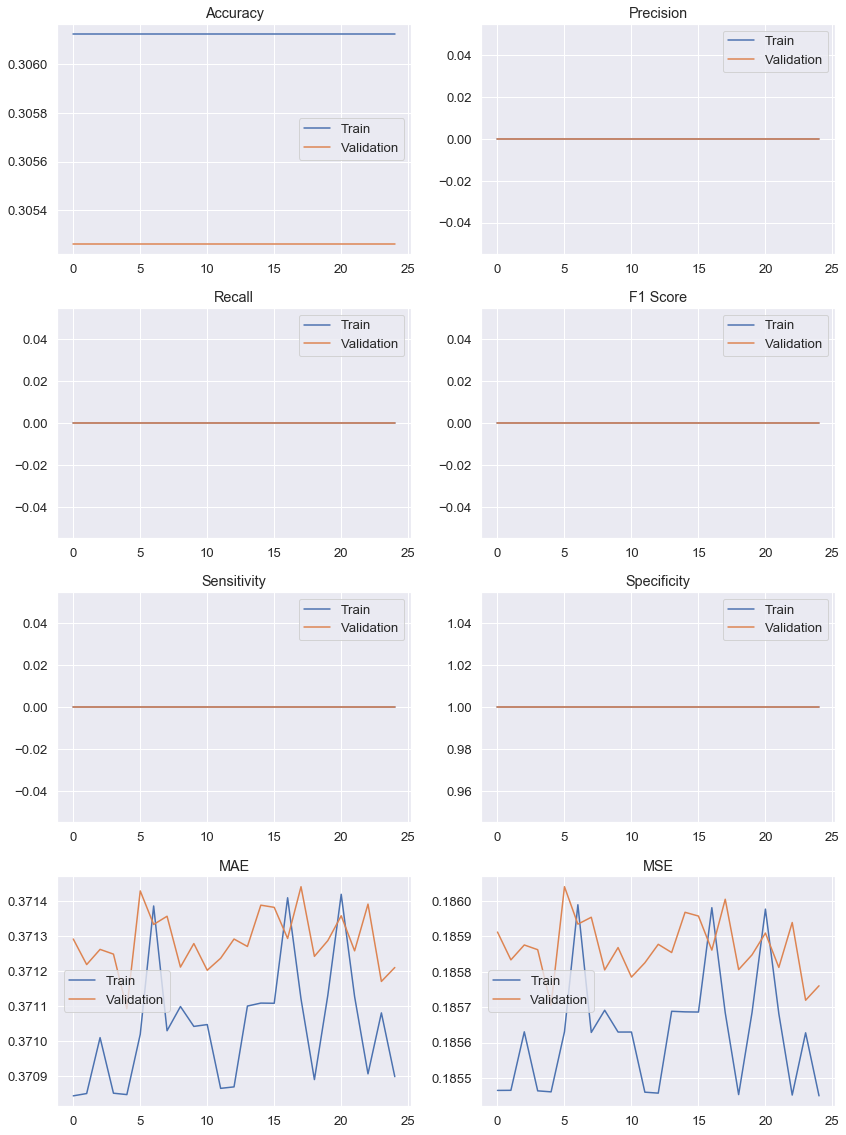

In [53]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

12/12 [==============================] - ETA: 3s - loss: 1.4206 - accuracy: 0.3750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3760 - mse: 0.19 - ETA: 2s - loss: 1.3616 - accuracy: 0.3750 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3697 - mse: 0.18 - ETA: 2s - loss: 1.3904 - accuracy: 0.2500 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3735 - mse: 0.18 - ETA: 2s - loss: 1.4001 - accuracy: 0.2188 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3748 - mse: 0.18 - ETA: 2s - loss: 1.4047 - accuracy: 0.2000 - f1_score: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - specificity_m: 1.0000 - sensitivity_m: 0.0000e+00 - mae: 0.3753 - m

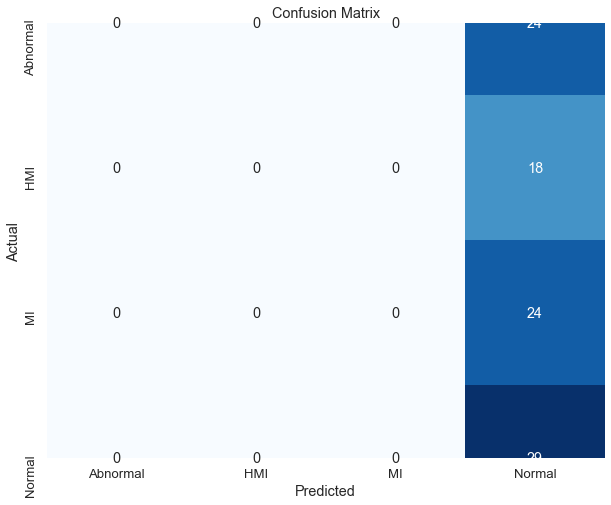

In [54]:
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [55]:
model.save('models/efficientb7.h5')

In [56]:
a2 = history.history['accuracy'][-1]
f2 = history.history['f1_score'][-1]
p2 = history.history['precision_m'][-1]
r2 = history.history['recall_m'][-1]
mae2 = history.history['mae'][-1]
mse2 = history.history['mse'][-1]
specificity2 = history.history['specificity_m'][-1]  
sensitivity2 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a2 * 100))
print('Precision = ' + str(p2 * 100))
print('F1 Score = ' + str(f2 * 100))
print('Recall = ' + str(r2 * 100))
print('MAE = ' + str(mae2))
print('MSE = ' + str(mse2))
print('Sensitivity = ' + str(sensitivity2 * 100))  
print('Specificity = ' + str(specificity2 * 100))

Accuracy = 30.612245202064514
Precision = 0.0
F1 Score = 0.0
Recall = 0.0
MAE = 0.3708990812301636
MSE = 0.18545016646385193
Sensitivity = 0.0
Specificity = 100.0


# XCEPTION

In [57]:
inc = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='max')


x31 = Flatten()(inc.output)
predictionss = Dense(4, activation='softmax')(x31)


model = Model(inputs = inc.inputs, outputs = predictionss)
model.summary()

83689472/83683744 [==============================] - ETA:  - ETA: 13:5 - ETA: 9:0 - ETA: 10:3 - ETA: 10:2 - ETA: 8:0 - ETA: 7: - ETA: 6: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 58s - ETA: 48 - ETA: 47 - ETA: 44 - ETA: 40 - ETA: 36 - ETA: 34 - ETA: 32 - ETA: 30 - ETA: 28 - ETA: 26 - ETA: 25 - ETA: 24 - ETA: 23 - ETA: 23 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - 

block3_pool (MaxPooling2D)      (None, 28, 28, 256)  0           block3_sepconv2_bn[0][0]         
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 256)  1024        conv2d_10[0][0]                  
__________________________________________________________________________________________________
add_1 (Add)                     (None, 28, 28, 256)  0           block3_pool[0][0]                
                                                                 batch_normalization_1[0][0]      
__________________________________________________________________________________________________
block4_sepconv1_act (Activation (None, 28, 28, 256)  0           add_1[0][0]                      
__________________________________________________________________________________________________
block4_sepconv1 (SeparableConv2 (None, 28, 28, 728)  188672      block4_sepconv1_act[0][0]        
__________

block7_sepconv3_act (Activation (None, 14, 14, 728)  0           block7_sepconv2_bn[0][0]         
__________________________________________________________________________________________________
block7_sepconv3 (SeparableConv2 (None, 14, 14, 728)  536536      block7_sepconv3_act[0][0]        
__________________________________________________________________________________________________
block7_sepconv3_bn (BatchNormal (None, 14, 14, 728)  2912        block7_sepconv3[0][0]            
__________________________________________________________________________________________________
add_5 (Add)                     (None, 14, 14, 728)  0           block7_sepconv3_bn[0][0]         
                                                                 add_4[0][0]                      
__________________________________________________________________________________________________
block8_sepconv1_act (Activation (None, 14, 14, 728)  0           add_5[0][0]                      
__________

block11_sepconv2_bn (BatchNorma (None, 14, 14, 728)  2912        block11_sepconv2[0][0]           
__________________________________________________________________________________________________
block11_sepconv3_act (Activatio (None, 14, 14, 728)  0           block11_sepconv2_bn[0][0]        
__________________________________________________________________________________________________
block11_sepconv3 (SeparableConv (None, 14, 14, 728)  536536      block11_sepconv3_act[0][0]       
__________________________________________________________________________________________________
block11_sepconv3_bn (BatchNorma (None, 14, 14, 728)  2912        block11_sepconv3[0][0]           
__________________________________________________________________________________________________
add_9 (Add)                     (None, 14, 14, 728)  0           block11_sepconv3_bn[0][0]        
                                                                 add_8[0][0]                      
__________

In [58]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])

history = model.fit(train_gen, epochs=25, batch_size=5, validation_data=val_gen)

Epoch 1/25


 46/105 [============>.................] - ETA: 11:51 - loss: 1.4072 - accuracy: 0.3750 - f1_score: 0.4286 - recall_m: 0.3750 - precision_m: 0.5000 - specificity_m: 0.8750 - sensitivity_m: 0.3750 - mae: 0.3190 - mse: 0.193 - ETA: 3:40 - loss: 1.7220 - accuracy: 0.1875 - f1_score: 0.2143 - recall_m: 0.1875 - precision_m: 0.2500 - specificity_m: 0.7708 - sensitivity_m: 0.1875 - mae: 0.3721 - mse: 0.246 - ETA: 3:46 - loss: 1.6356 - accuracy: 0.2500 - f1_score: 0.1429 - recall_m: 0.1250 - precision_m: 0.1667 - specificity_m: 0.8472 - sensitivity_m: 0.1250 - mae: 0.3755 - mse: 0.23 - ETA: 3:49 - loss: 1.5578 - accuracy: 0.3438 - f1_score: 0.1071 - recall_m: 0.0938 - precision_m: 0.1250 - specificity_m: 0.8854 - sensitivity_m: 0.0938 - mae: 0.3734 - mse: 0.21 - ETA: 3:42 - loss: 1.5303 - accuracy: 0.3250 - f1_score: 0.0857 - recall_m: 0.0750 - precision_m: 0.1000 - specificity_m: 0.9083 - sensitivity_m: 0.0750 - mae: 0.3736 - mse: 0.21 - ETA: 3:36 - loss: 1.4929 - accuracy: 0.3333 - f1_score

 92/105 [=========================>....] - ETA: 1:59 - loss: 1.2753 - accuracy: 0.4521 - f1_score: 0.2323 - recall_m: 0.1596 - precision_m: 0.5128 - specificity_m: 0.9619 - sensitivity_m: 0.1596 - mae: 0.3304 - mse: 0.16 - ETA: 1:57 - loss: 1.2704 - accuracy: 0.4557 - f1_score: 0.2317 - recall_m: 0.1589 - precision_m: 0.5125 - specificity_m: 0.9618 - sensitivity_m: 0.1589 - mae: 0.3299 - mse: 0.16 - ETA: 1:55 - loss: 1.2658 - accuracy: 0.4515 - f1_score: 0.2303 - recall_m: 0.1582 - precision_m: 0.5071 - specificity_m: 0.9600 - sensitivity_m: 0.1582 - mae: 0.3297 - mse: 0.16 - ETA: 1:53 - loss: 1.2711 - accuracy: 0.4500 - f1_score: 0.2343 - recall_m: 0.1625 - precision_m: 0.5070 - specificity_m: 0.9583 - sensitivity_m: 0.1625 - mae: 0.3297 - mse: 0.16 - ETA: 1:51 - loss: 1.2635 - accuracy: 0.4510 - f1_score: 0.2357 - recall_m: 0.1642 - precision_m: 0.5049 - specificity_m: 0.9567 - sensitivity_m: 0.1642 - mae: 0.3289 - mse: 0.16 - ETA: 1:48 - loss: 1.2647 - accuracy: 0.4447 - f1_score: 0

105/105 [==============================] - ETA: 23s - loss: 1.1388 - accuracy: 0.5210 - f1_score: 0.3733 - recall_m: 0.3091 - precision_m: 0.5735 - specificity_m: 0.9364 - sensitivity_m: 0.3091 - mae: 0.2929 - mse: 0.153 - ETA: 21s - loss: 1.1390 - accuracy: 0.5208 - f1_score: 0.3747 - recall_m: 0.3098 - precision_m: 0.5753 - specificity_m: 0.9366 - sensitivity_m: 0.3098 - mae: 0.2929 - mse: 0.153 - ETA: 19s - loss: 1.1377 - accuracy: 0.5193 - f1_score: 0.3743 - recall_m: 0.3092 - precision_m: 0.5745 - specificity_m: 0.9364 - sensitivity_m: 0.3092 - mae: 0.2930 - mse: 0.153 - ETA: 17s - loss: 1.1338 - accuracy: 0.5204 - f1_score: 0.3773 - recall_m: 0.3112 - precision_m: 0.5790 - specificity_m: 0.9371 - sensitivity_m: 0.3112 - mae: 0.2925 - mse: 0.152 - ETA: 15s - loss: 1.1315 - accuracy: 0.5215 - f1_score: 0.3772 - recall_m: 0.3106 - precision_m: 0.5799 - specificity_m: 0.9373 - sensitivity_m: 0.3106 - mae: 0.2923 - mse: 0.152 - ETA: 13s - loss: 1.1266 - accuracy: 0.5251 - f1_score: 0.

 46/105 [============>.................] - ETA: 3:28 - loss: 0.4668 - accuracy: 0.7500 - f1_score: 0.8571 - recall_m: 0.7500 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 0.7500 - mae: 0.1587 - mse: 0.05 - ETA: 2:54 - loss: 1.0021 - accuracy: 0.7500 - f1_score: 0.8036 - recall_m: 0.7500 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.7500 - mae: 0.1775 - mse: 0.08 - ETA: 2:53 - loss: 0.7749 - accuracy: 0.7917 - f1_score: 0.8274 - recall_m: 0.7917 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.7917 - mae: 0.1561 - mse: 0.07 - ETA: 2:51 - loss: 0.6011 - accuracy: 0.8438 - f1_score: 0.8705 - recall_m: 0.8438 - precision_m: 0.9062 - specificity_m: 0.9688 - sensitivity_m: 0.8438 - mae: 0.1263 - mse: 0.05 - ETA: 2:49 - loss: 0.5938 - accuracy: 0.8500 - f1_score: 0.8714 - recall_m: 0.8500 - precision_m: 0.9000 - specificity_m: 0.9667 - sensitivity_m: 0.8500 - mae: 0.1228 - mse: 0.05 - ETA: 2:48 - loss: 0.5518 - accuracy: 0.8542 - f1_score: 0

 92/105 [=========================>....] - ETA: 1:39 - loss: 0.6680 - accuracy: 0.7686 - f1_score: 0.7510 - recall_m: 0.7021 - precision_m: 0.8261 - specificity_m: 0.9521 - sensitivity_m: 0.7021 - mae: 0.1699 - mse: 0.08 - ETA: 1:38 - loss: 0.6582 - accuracy: 0.7734 - f1_score: 0.7561 - recall_m: 0.7083 - precision_m: 0.8297 - specificity_m: 0.9531 - sensitivity_m: 0.7083 - mae: 0.1682 - mse: 0.08 - ETA: 1:36 - loss: 0.6568 - accuracy: 0.7704 - f1_score: 0.7543 - recall_m: 0.7066 - precision_m: 0.8274 - specificity_m: 0.9524 - sensitivity_m: 0.7066 - mae: 0.1683 - mse: 0.08 - ETA: 1:35 - loss: 0.6543 - accuracy: 0.7675 - f1_score: 0.7535 - recall_m: 0.7050 - precision_m: 0.8275 - specificity_m: 0.9525 - sensitivity_m: 0.7050 - mae: 0.1681 - mse: 0.08 - ETA: 1:33 - loss: 0.6502 - accuracy: 0.7672 - f1_score: 0.7534 - recall_m: 0.7059 - precision_m: 0.8260 - specificity_m: 0.9518 - sensitivity_m: 0.7059 - mae: 0.1674 - mse: 0.08 - ETA: 1:31 - loss: 0.6406 - accuracy: 0.7716 - f1_score: 0

105/105 [==============================] - ETA: 20s - loss: 0.6010 - accuracy: 0.7924 - f1_score: 0.7761 - recall_m: 0.7392 - precision_m: 0.8287 - specificity_m: 0.9498 - sensitivity_m: 0.7392 - mae: 0.1513 - mse: 0.078 - ETA: 18s - loss: 0.5984 - accuracy: 0.7933 - f1_score: 0.7778 - recall_m: 0.7407 - precision_m: 0.8305 - specificity_m: 0.9504 - sensitivity_m: 0.7407 - mae: 0.1512 - mse: 0.078 - ETA: 17s - loss: 0.5971 - accuracy: 0.7942 - f1_score: 0.7788 - recall_m: 0.7421 - precision_m: 0.8310 - specificity_m: 0.9504 - sensitivity_m: 0.7421 - mae: 0.1511 - mse: 0.077 - ETA: 15s - loss: 0.5942 - accuracy: 0.7950 - f1_score: 0.7798 - recall_m: 0.7435 - precision_m: 0.8314 - specificity_m: 0.9505 - sensitivity_m: 0.7435 - mae: 0.1508 - mse: 0.077 - ETA: 13s - loss: 0.5942 - accuracy: 0.7958 - f1_score: 0.7781 - recall_m: 0.7410 - precision_m: 0.8311 - specificity_m: 0.9506 - sensitivity_m: 0.7410 - mae: 0.1513 - mse: 0.077 - ETA: 11s - loss: 0.5997 - accuracy: 0.7915 - f1_score: 0.

 46/105 [============>.................] - ETA: 3:50 - loss: 0.3811 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.1265 - mse: 0.04 - ETA: 3:02 - loss: 0.3661 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.1221 - mse: 0.04 - ETA: 3:07 - loss: 0.3615 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.1257 - mse: 0.04 - ETA: 3:03 - loss: 0.3074 - accuracy: 0.9062 - f1_score: 0.9062 - recall_m: 0.9062 - precision_m: 0.9062 - specificity_m: 0.9688 - sensitivity_m: 0.9062 - mae: 0.1098 - mse: 0.03 - ETA: 3:06 - loss: 0.2745 - accuracy: 0.9250 - f1_score: 0.9250 - recall_m: 0.9250 - precision_m: 0.9250 - specificity_m: 0.9750 - sensitivity_m: 0.9250 - mae: 0.1002 - mse: 0.03 - ETA: 3:09 - loss: 0.4056 - accuracy: 0.8958 - f1_score: 0

 92/105 [=========================>....] - ETA: 1:42 - loss: 0.3855 - accuracy: 0.8856 - f1_score: 0.8832 - recall_m: 0.8697 - precision_m: 0.8999 - specificity_m: 0.9672 - sensitivity_m: 0.8697 - mae: 0.0920 - mse: 0.04 - ETA: 1:40 - loss: 0.3781 - accuracy: 0.8880 - f1_score: 0.8857 - recall_m: 0.8724 - precision_m: 0.9020 - specificity_m: 0.9679 - sensitivity_m: 0.8724 - mae: 0.0904 - mse: 0.04 - ETA: 1:38 - loss: 0.3842 - accuracy: 0.8852 - f1_score: 0.8839 - recall_m: 0.8699 - precision_m: 0.9011 - specificity_m: 0.9677 - sensitivity_m: 0.8699 - mae: 0.0908 - mse: 0.04 - ETA: 1:36 - loss: 0.3798 - accuracy: 0.8850 - f1_score: 0.8837 - recall_m: 0.8700 - precision_m: 0.9006 - specificity_m: 0.9675 - sensitivity_m: 0.8700 - mae: 0.0902 - mse: 0.04 - ETA: 1:34 - loss: 0.3838 - accuracy: 0.8824 - f1_score: 0.8811 - recall_m: 0.8676 - precision_m: 0.8976 - specificity_m: 0.9665 - sensitivity_m: 0.8676 - mae: 0.0908 - mse: 0.04 - ETA: 1:33 - loss: 0.4102 - accuracy: 0.8774 - f1_score: 0

105/105 [==============================] - ETA: 20s - loss: 0.4346 - accuracy: 0.8752 - f1_score: 0.8661 - recall_m: 0.8481 - precision_m: 0.8881 - specificity_m: 0.9673 - sensitivity_m: 0.8481 - mae: 0.0994 - mse: 0.050 - ETA: 18s - loss: 0.4390 - accuracy: 0.8738 - f1_score: 0.8648 - recall_m: 0.8471 - precision_m: 0.8867 - specificity_m: 0.9668 - sensitivity_m: 0.8471 - mae: 0.1000 - mse: 0.051 - ETA: 17s - loss: 0.4354 - accuracy: 0.8752 - f1_score: 0.8662 - recall_m: 0.8487 - precision_m: 0.8878 - specificity_m: 0.9671 - sensitivity_m: 0.8487 - mae: 0.0994 - mse: 0.050 - ETA: 15s - loss: 0.4336 - accuracy: 0.8752 - f1_score: 0.8663 - recall_m: 0.8490 - precision_m: 0.8877 - specificity_m: 0.9670 - sensitivity_m: 0.8490 - mae: 0.0994 - mse: 0.050 - ETA: 13s - loss: 0.4352 - accuracy: 0.8752 - f1_score: 0.8656 - recall_m: 0.8479 - precision_m: 0.8874 - specificity_m: 0.9669 - sensitivity_m: 0.8479 - mae: 0.0996 - mse: 0.051 - ETA: 12s - loss: 0.4331 - accuracy: 0.8752 - f1_score: 0.

 46/105 [============>.................] - ETA: 3:25 - loss: 0.8595 - accuracy: 0.6250 - f1_score: 0.7143 - recall_m: 0.6250 - precision_m: 0.8333 - specificity_m: 0.9583 - sensitivity_m: 0.6250 - mae: 0.2225 - mse: 0.12 - ETA: 2:55 - loss: 0.5395 - accuracy: 0.8125 - f1_score: 0.8571 - recall_m: 0.8125 - precision_m: 0.9167 - specificity_m: 0.9792 - sensitivity_m: 0.8125 - mae: 0.1562 - mse: 0.07 - ETA: 2:53 - loss: 0.4524 - accuracy: 0.8333 - f1_score: 0.8825 - recall_m: 0.8333 - precision_m: 0.9444 - specificity_m: 0.9861 - sensitivity_m: 0.8333 - mae: 0.1369 - mse: 0.05 - ETA: 2:51 - loss: 0.4222 - accuracy: 0.8438 - f1_score: 0.8807 - recall_m: 0.8438 - precision_m: 0.9271 - specificity_m: 0.9792 - sensitivity_m: 0.8438 - mae: 0.1294 - mse: 0.05 - ETA: 2:51 - loss: 0.3670 - accuracy: 0.8750 - f1_score: 0.9045 - recall_m: 0.8750 - precision_m: 0.9417 - specificity_m: 0.9833 - sensitivity_m: 0.8750 - mae: 0.1166 - mse: 0.04 - ETA: 2:54 - loss: 0.3182 - accuracy: 0.8958 - f1_score: 0

 92/105 [=========================>....] - ETA: 1:37 - loss: 0.2246 - accuracy: 0.9268 - f1_score: 0.9322 - recall_m: 0.9202 - precision_m: 0.9466 - specificity_m: 0.9832 - sensitivity_m: 0.9202 - mae: 0.0663 - mse: 0.02 - ETA: 1:35 - loss: 0.2208 - accuracy: 0.9284 - f1_score: 0.9336 - recall_m: 0.9219 - precision_m: 0.9477 - specificity_m: 0.9835 - sensitivity_m: 0.9219 - mae: 0.0654 - mse: 0.02 - ETA: 1:34 - loss: 0.2165 - accuracy: 0.9299 - f1_score: 0.9349 - recall_m: 0.9235 - precision_m: 0.9487 - specificity_m: 0.9838 - sensitivity_m: 0.9235 - mae: 0.0642 - mse: 0.02 - ETA: 1:32 - loss: 0.2200 - accuracy: 0.9262 - f1_score: 0.9312 - recall_m: 0.9200 - precision_m: 0.9448 - specificity_m: 0.9825 - sensitivity_m: 0.9200 - mae: 0.0647 - mse: 0.02 - ETA: 1:30 - loss: 0.2159 - accuracy: 0.9277 - f1_score: 0.9326 - recall_m: 0.9216 - precision_m: 0.9458 - specificity_m: 0.9828 - sensitivity_m: 0.9216 - mae: 0.0635 - mse: 0.02 - ETA: 1:29 - loss: 0.2621 - accuracy: 0.9218 - f1_score: 0

105/105 [==============================] - ETA: 20s - loss: 0.2818 - accuracy: 0.9145 - f1_score: 0.9146 - recall_m: 0.9019 - precision_m: 0.9298 - specificity_m: 0.9776 - sensitivity_m: 0.9019 - mae: 0.0718 - mse: 0.033 - ETA: 18s - loss: 0.2793 - accuracy: 0.9154 - f1_score: 0.9155 - recall_m: 0.9029 - precision_m: 0.9305 - specificity_m: 0.9778 - sensitivity_m: 0.9029 - mae: 0.0712 - mse: 0.033 - ETA: 16s - loss: 0.2808 - accuracy: 0.9150 - f1_score: 0.9151 - recall_m: 0.9026 - precision_m: 0.9299 - specificity_m: 0.9776 - sensitivity_m: 0.9026 - mae: 0.0714 - mse: 0.033 - ETA: 15s - loss: 0.2779 - accuracy: 0.9159 - f1_score: 0.9160 - recall_m: 0.9036 - precision_m: 0.9307 - specificity_m: 0.9779 - sensitivity_m: 0.9036 - mae: 0.0707 - mse: 0.033 - ETA: 13s - loss: 0.2768 - accuracy: 0.9155 - f1_score: 0.9156 - recall_m: 0.9034 - precision_m: 0.9301 - specificity_m: 0.9777 - sensitivity_m: 0.9034 - mae: 0.0705 - mse: 0.033 - ETA: 11s - loss: 0.2748 - accuracy: 0.9163 - f1_score: 0.

 46/105 [============>.................] - ETA: 3:24 - loss: 0.0267 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0124 - mse: 0.00 - ETA: 2:57 - loss: 0.0491 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0222 - mse: 0.00 - ETA: 2:58 - loss: 0.0527 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0229 - mse: 0.00 - ETA: 2:53 - loss: 0.0460 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0202 - mse: 0.00 - ETA: 2:51 - loss: 0.1292 - accuracy: 0.9750 - f1_score: 0.9750 - recall_m: 0.9750 - precision_m: 0.9750 - specificity_m: 0.9917 - sensitivity_m: 0.9750 - mae: 0.0288 - mse: 0.01 - ETA: 2:49 - loss: 0.1101 - accuracy: 0.9792 - f1_score: 0

 92/105 [=========================>....] - ETA: 1:40 - loss: 0.3061 - accuracy: 0.8936 - f1_score: 0.8934 - recall_m: 0.8883 - precision_m: 0.8993 - specificity_m: 0.9672 - sensitivity_m: 0.8883 - mae: 0.0709 - mse: 0.03 - ETA: 1:38 - loss: 0.3066 - accuracy: 0.8932 - f1_score: 0.8931 - recall_m: 0.8880 - precision_m: 0.8988 - specificity_m: 0.9670 - sensitivity_m: 0.8880 - mae: 0.0715 - mse: 0.04 - ETA: 1:37 - loss: 0.3018 - accuracy: 0.8954 - f1_score: 0.8952 - recall_m: 0.8903 - precision_m: 0.9009 - specificity_m: 0.9677 - sensitivity_m: 0.8903 - mae: 0.0707 - mse: 0.03 - ETA: 1:35 - loss: 0.2969 - accuracy: 0.8975 - f1_score: 0.8973 - recall_m: 0.8925 - precision_m: 0.9029 - specificity_m: 0.9683 - sensitivity_m: 0.8925 - mae: 0.0698 - mse: 0.03 - ETA: 1:33 - loss: 0.2939 - accuracy: 0.8971 - f1_score: 0.8969 - recall_m: 0.8922 - precision_m: 0.9023 - specificity_m: 0.9681 - sensitivity_m: 0.8922 - mae: 0.0694 - mse: 0.03 - ETA: 1:30 - loss: 0.3036 - accuracy: 0.8949 - f1_score: 0

105/105 [==============================] - ETA: 20s - loss: 0.2836 - accuracy: 0.9118 - f1_score: 0.9008 - recall_m: 0.8925 - precision_m: 0.9103 - specificity_m: 0.9709 - sensitivity_m: 0.8925 - mae: 0.0728 - mse: 0.039 - ETA: 18s - loss: 0.2819 - accuracy: 0.9128 - f1_score: 0.9019 - recall_m: 0.8936 - precision_m: 0.9113 - specificity_m: 0.9712 - sensitivity_m: 0.8936 - mae: 0.0725 - mse: 0.039 - ETA: 17s - loss: 0.2848 - accuracy: 0.9124 - f1_score: 0.9016 - recall_m: 0.8934 - precision_m: 0.9109 - specificity_m: 0.9711 - sensitivity_m: 0.8934 - mae: 0.0730 - mse: 0.039 - ETA: 15s - loss: 0.2825 - accuracy: 0.9133 - f1_score: 0.9026 - recall_m: 0.8945 - precision_m: 0.9118 - specificity_m: 0.9714 - sensitivity_m: 0.8945 - mae: 0.0725 - mse: 0.039 - ETA: 13s - loss: 0.2798 - accuracy: 0.9142 - f1_score: 0.9036 - recall_m: 0.8956 - precision_m: 0.9127 - specificity_m: 0.9716 - sensitivity_m: 0.8956 - mae: 0.0719 - mse: 0.039 - ETA: 12s - loss: 0.2873 - accuracy: 0.9138 - f1_score: 0.

 46/105 [============>.................] - ETA: 3:23 - loss: 0.0436 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0204 - mse: 0.00 - ETA: 2:55 - loss: 0.0722 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0303 - mse: 0.00 - ETA: 2:52 - loss: 0.0541 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0231 - mse: 0.00 - ETA: 2:06 - loss: 0.0978 - accuracy: 0.9600 - f1_score: 0.7500 - recall_m: 0.7500 - precision_m: 0.7500 - specificity_m: 1.0000 - sensitivity_m: 0.7500 - mae: 0.1027 - mse: 0.04 - ETA: 2:17 - loss: 0.1184 - accuracy: 0.9394 - f1_score: 0.7750 - recall_m: 0.7750 - precision_m: 0.7750 - specificity_m: 0.9917 - sensitivity_m: 0.7750 - mae: 0.0943 - mse: 0.04 - ETA: 2:22 - loss: 0.0967 - accuracy: 0.9512 - f1_score: 0

 92/105 [=========================>....] - ETA: 1:37 - loss: 0.1591 - accuracy: 0.9512 - f1_score: 0.9306 - recall_m: 0.9255 - precision_m: 0.9368 - specificity_m: 0.9867 - sensitivity_m: 0.9255 - mae: 0.0469 - mse: 0.02 - ETA: 1:36 - loss: 0.1565 - accuracy: 0.9523 - f1_score: 0.9321 - recall_m: 0.9271 - precision_m: 0.9381 - specificity_m: 0.9870 - sensitivity_m: 0.9271 - mae: 0.0463 - mse: 0.02 - ETA: 1:34 - loss: 0.1533 - accuracy: 0.9532 - f1_score: 0.9335 - recall_m: 0.9286 - precision_m: 0.9394 - specificity_m: 0.9872 - sensitivity_m: 0.9286 - mae: 0.0454 - mse: 0.02 - ETA: 1:32 - loss: 0.1504 - accuracy: 0.9542 - f1_score: 0.9348 - recall_m: 0.9300 - precision_m: 0.9406 - specificity_m: 0.9875 - sensitivity_m: 0.9300 - mae: 0.0446 - mse: 0.02 - ETA: 1:31 - loss: 0.1615 - accuracy: 0.9501 - f1_score: 0.9312 - recall_m: 0.9265 - precision_m: 0.9369 - specificity_m: 0.9861 - sensitivity_m: 0.9265 - mae: 0.0465 - mse: 0.02 - ETA: 1:29 - loss: 0.1589 - accuracy: 0.9511 - f1_score: 0

105/105 [==============================] - ETA: 20s - loss: 0.1779 - accuracy: 0.9430 - f1_score: 0.9324 - recall_m: 0.9274 - precision_m: 0.9383 - specificity_m: 0.9834 - sensitivity_m: 0.9274 - mae: 0.0467 - mse: 0.023 - ETA: 18s - loss: 0.1769 - accuracy: 0.9436 - f1_score: 0.9331 - recall_m: 0.9282 - precision_m: 0.9390 - specificity_m: 0.9836 - sensitivity_m: 0.9282 - mae: 0.0466 - mse: 0.023 - ETA: 17s - loss: 0.1764 - accuracy: 0.9429 - f1_score: 0.9331 - recall_m: 0.9276 - precision_m: 0.9396 - specificity_m: 0.9838 - sensitivity_m: 0.9276 - mae: 0.0465 - mse: 0.023 - ETA: 15s - loss: 0.1747 - accuracy: 0.9435 - f1_score: 0.9338 - recall_m: 0.9284 - precision_m: 0.9402 - specificity_m: 0.9839 - sensitivity_m: 0.9284 - mae: 0.0462 - mse: 0.023 - ETA: 13s - loss: 0.1744 - accuracy: 0.9428 - f1_score: 0.9332 - recall_m: 0.9278 - precision_m: 0.9396 - specificity_m: 0.9837 - sensitivity_m: 0.9278 - mae: 0.0463 - mse: 0.023 - ETA: 12s - loss: 0.1727 - accuracy: 0.9434 - f1_score: 0.

 46/105 [============>.................] - ETA: 3:23 - loss: 0.0847 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0390 - mse: 0.00 - ETA: 2:52 - loss: 0.0989 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0412 - mse: 0.01 - ETA: 2:51 - loss: 0.0852 - accuracy: 0.9583 - f1_score: 0.9583 - recall_m: 0.9583 - precision_m: 0.9583 - specificity_m: 0.9861 - sensitivity_m: 0.9583 - mae: 0.0356 - mse: 0.00 - ETA: 2:51 - loss: 0.2262 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0577 - mse: 0.02 - ETA: 2:50 - loss: 0.1843 - accuracy: 0.9500 - f1_score: 0.9500 - recall_m: 0.9500 - precision_m: 0.9500 - specificity_m: 0.9833 - sensitivity_m: 0.9500 - mae: 0.0477 - mse: 0.02 - ETA: 2:49 - loss: 0.2333 - accuracy: 0.9375 - f1_score: 0

 92/105 [=========================>....] - ETA: 1:40 - loss: 0.2161 - accuracy: 0.9229 - f1_score: 0.9248 - recall_m: 0.9202 - precision_m: 0.9301 - specificity_m: 0.9770 - sensitivity_m: 0.9202 - mae: 0.0528 - mse: 0.02 - ETA: 1:38 - loss: 0.2136 - accuracy: 0.9245 - f1_score: 0.9264 - recall_m: 0.9219 - precision_m: 0.9315 - specificity_m: 0.9774 - sensitivity_m: 0.9219 - mae: 0.0526 - mse: 0.02 - ETA: 1:37 - loss: 0.2102 - accuracy: 0.9260 - f1_score: 0.9279 - recall_m: 0.9235 - precision_m: 0.9329 - specificity_m: 0.9779 - sensitivity_m: 0.9235 - mae: 0.0520 - mse: 0.02 - ETA: 1:35 - loss: 0.2062 - accuracy: 0.9275 - f1_score: 0.9293 - recall_m: 0.9250 - precision_m: 0.9343 - specificity_m: 0.9783 - sensitivity_m: 0.9250 - mae: 0.0510 - mse: 0.02 - ETA: 1:33 - loss: 0.2062 - accuracy: 0.9265 - f1_score: 0.9283 - recall_m: 0.9240 - precision_m: 0.9331 - specificity_m: 0.9779 - sensitivity_m: 0.9240 - mae: 0.0510 - mse: 0.02 - ETA: 1:31 - loss: 0.2057 - accuracy: 0.9279 - f1_score: 0

105/105 [==============================] - ETA: 20s - loss: 0.2049 - accuracy: 0.9254 - f1_score: 0.9168 - recall_m: 0.9126 - precision_m: 0.9217 - specificity_m: 0.9740 - sensitivity_m: 0.9126 - mae: 0.0548 - mse: 0.030 - ETA: 18s - loss: 0.2029 - accuracy: 0.9262 - f1_score: 0.9177 - recall_m: 0.9136 - precision_m: 0.9225 - specificity_m: 0.9743 - sensitivity_m: 0.9136 - mae: 0.0543 - mse: 0.029 - ETA: 17s - loss: 0.2010 - accuracy: 0.9270 - f1_score: 0.9186 - recall_m: 0.9145 - precision_m: 0.9233 - specificity_m: 0.9746 - sensitivity_m: 0.9145 - mae: 0.0539 - mse: 0.029 - ETA: 15s - loss: 0.2002 - accuracy: 0.9277 - f1_score: 0.9188 - recall_m: 0.9141 - precision_m: 0.9241 - specificity_m: 0.9748 - sensitivity_m: 0.9141 - mae: 0.0538 - mse: 0.029 - ETA: 13s - loss: 0.1988 - accuracy: 0.9285 - f1_score: 0.9196 - recall_m: 0.9149 - precision_m: 0.9249 - specificity_m: 0.9751 - sensitivity_m: 0.9149 - mae: 0.0536 - mse: 0.029 - ETA: 11s - loss: 0.2008 - accuracy: 0.9279 - f1_score: 0.

 46/105 [============>.................] - ETA: 3:35 - loss: 0.0012 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 6.0847e-04 - mse: 1.2364e- - ETA: 3:03 - loss: 0.0335 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0146 - mse: 0.0027       - ETA: 2:58 - loss: 0.0246 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0109 - mse: 0.00 - ETA: 2:55 - loss: 0.0222 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0100 - mse: 0.00 - ETA: 2:53 - loss: 0.0561 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0237 - mse: 0.00 - ETA: 2:51 - loss: 0.0531 - accuracy: 1.00

 92/105 [=========================>....] - ETA: 1:39 - loss: 0.1044 - accuracy: 0.9648 - f1_score: 0.9454 - recall_m: 0.9441 - precision_m: 0.9468 - specificity_m: 0.9894 - sensitivity_m: 0.9441 - mae: 0.0400 - mse: 0.01 - ETA: 1:37 - loss: 0.1092 - accuracy: 0.9629 - f1_score: 0.9439 - recall_m: 0.9427 - precision_m: 0.9453 - specificity_m: 0.9887 - sensitivity_m: 0.9427 - mae: 0.0407 - mse: 0.01 - ETA: 1:35 - loss: 0.1077 - accuracy: 0.9636 - f1_score: 0.9451 - recall_m: 0.9439 - precision_m: 0.9464 - specificity_m: 0.9889 - sensitivity_m: 0.9439 - mae: 0.0402 - mse: 0.01 - ETA: 1:33 - loss: 0.1074 - accuracy: 0.9644 - f1_score: 0.9462 - recall_m: 0.9450 - precision_m: 0.9475 - specificity_m: 0.9892 - sensitivity_m: 0.9450 - mae: 0.0403 - mse: 0.01 - ETA: 1:32 - loss: 0.1149 - accuracy: 0.9626 - f1_score: 0.9448 - recall_m: 0.9436 - precision_m: 0.9461 - specificity_m: 0.9886 - sensitivity_m: 0.9436 - mae: 0.0409 - mse: 0.01 - ETA: 1:30 - loss: 0.1136 - accuracy: 0.9633 - f1_score: 0

105/105 [==============================] - ETA: 20s - loss: 0.1562 - accuracy: 0.9444 - f1_score: 0.9362 - recall_m: 0.9341 - precision_m: 0.9386 - specificity_m: 0.9834 - sensitivity_m: 0.9341 - mae: 0.0440 - mse: 0.022 - ETA: 18s - loss: 0.1562 - accuracy: 0.9450 - f1_score: 0.9362 - recall_m: 0.9335 - precision_m: 0.9392 - specificity_m: 0.9836 - sensitivity_m: 0.9335 - mae: 0.0442 - mse: 0.022 - ETA: 17s - loss: 0.1550 - accuracy: 0.9456 - f1_score: 0.9368 - recall_m: 0.9342 - precision_m: 0.9398 - specificity_m: 0.9838 - sensitivity_m: 0.9342 - mae: 0.0439 - mse: 0.022 - ETA: 15s - loss: 0.1536 - accuracy: 0.9461 - f1_score: 0.9375 - recall_m: 0.9349 - precision_m: 0.9405 - specificity_m: 0.9839 - sensitivity_m: 0.9349 - mae: 0.0435 - mse: 0.022 - ETA: 13s - loss: 0.1521 - accuracy: 0.9467 - f1_score: 0.9381 - recall_m: 0.9356 - precision_m: 0.9411 - specificity_m: 0.9841 - sensitivity_m: 0.9356 - mae: 0.0432 - mse: 0.022 - ETA: 12s - loss: 0.1508 - accuracy: 0.9472 - f1_score: 0.

 46/105 [============>.................] - ETA: 3:22 - loss: 0.0142 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0070 - mse: 1.8991e- - ETA: 2:52 - loss: 0.0272 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0129 - mse: 0.0012   - ETA: 1:42 - loss: 0.0703 - accuracy: 1.0000 - f1_score: 0.6667 - recall_m: 0.6667 - precision_m: 0.6667 - specificity_m: 1.0000 - sensitivity_m: 0.6667 - mae: 0.0973 - mse: 0.03 - ETA: 2:11 - loss: 0.0518 - accuracy: 1.0000 - f1_score: 0.7500 - recall_m: 0.7500 - precision_m: 0.7500 - specificity_m: 1.0000 - sensitivity_m: 0.7500 - mae: 0.0745 - mse: 0.02 - ETA: 2:24 - loss: 0.0653 - accuracy: 1.0000 - f1_score: 0.8000 - recall_m: 0.8000 - precision_m: 0.8000 - specificity_m: 1.0000 - sensitivity_m: 0.8000 - mae: 0.0685 - mse: 0.02 - ETA: 2:32 - loss: 0.0551 - accuracy: 1.0000 - f1_

 92/105 [=========================>....] - ETA: 1:39 - loss: 0.1299 - accuracy: 0.9593 - f1_score: 0.9401 - recall_m: 0.9388 - precision_m: 0.9415 - specificity_m: 0.9876 - sensitivity_m: 0.9388 - mae: 0.0333 - mse: 0.01 - ETA: 1:37 - loss: 0.1276 - accuracy: 0.9602 - f1_score: 0.9413 - recall_m: 0.9401 - precision_m: 0.9427 - specificity_m: 0.9878 - sensitivity_m: 0.9401 - mae: 0.0328 - mse: 0.01 - ETA: 1:35 - loss: 0.1269 - accuracy: 0.9610 - f1_score: 0.9425 - recall_m: 0.9413 - precision_m: 0.9439 - specificity_m: 0.9881 - sensitivity_m: 0.9413 - mae: 0.0329 - mse: 0.01 - ETA: 1:34 - loss: 0.1349 - accuracy: 0.9567 - f1_score: 0.9387 - recall_m: 0.9375 - precision_m: 0.9400 - specificity_m: 0.9867 - sensitivity_m: 0.9375 - mae: 0.0346 - mse: 0.01 - ETA: 1:32 - loss: 0.1362 - accuracy: 0.9576 - f1_score: 0.9386 - recall_m: 0.9363 - precision_m: 0.9412 - specificity_m: 0.9869 - sensitivity_m: 0.9363 - mae: 0.0353 - mse: 0.01 - ETA: 1:30 - loss: 0.1361 - accuracy: 0.9560 - f1_score: 0

105/105 [==============================] - ETA: 20s - loss: 0.1154 - accuracy: 0.9593 - f1_score: 0.9487 - recall_m: 0.9462 - precision_m: 0.9514 - specificity_m: 0.9875 - sensitivity_m: 0.9462 - mae: 0.0320 - mse: 0.016 - ETA: 18s - loss: 0.1147 - accuracy: 0.9597 - f1_score: 0.9492 - recall_m: 0.9468 - precision_m: 0.9519 - specificity_m: 0.9876 - sensitivity_m: 0.9468 - mae: 0.0319 - mse: 0.016 - ETA: 17s - loss: 0.1137 - accuracy: 0.9602 - f1_score: 0.9497 - recall_m: 0.9474 - precision_m: 0.9524 - specificity_m: 0.9877 - sensitivity_m: 0.9474 - mae: 0.0317 - mse: 0.016 - ETA: 15s - loss: 0.1126 - accuracy: 0.9606 - f1_score: 0.9503 - recall_m: 0.9479 - precision_m: 0.9529 - specificity_m: 0.9878 - sensitivity_m: 0.9479 - mae: 0.0314 - mse: 0.016 - ETA: 13s - loss: 0.1114 - accuracy: 0.9610 - f1_score: 0.9508 - recall_m: 0.9485 - precision_m: 0.9534 - specificity_m: 0.9880 - sensitivity_m: 0.9485 - mae: 0.0310 - mse: 0.015 - ETA: 11s - loss: 0.1103 - accuracy: 0.9614 - f1_score: 0.

 46/105 [============>.................] - ETA: 3:26 - loss: 0.0606 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0248 - mse: 0.00 - ETA: 2:54 - loss: 1.1983 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0601 - mse: 0.03 - ETA: 2:51 - loss: 0.8087 - accuracy: 0.9583 - f1_score: 0.9583 - recall_m: 0.9583 - precision_m: 0.9583 - specificity_m: 0.9861 - sensitivity_m: 0.9583 - mae: 0.0447 - mse: 0.02 - ETA: 2:51 - loss: 0.6071 - accuracy: 0.9688 - f1_score: 0.9688 - recall_m: 0.9688 - precision_m: 0.9688 - specificity_m: 0.9896 - sensitivity_m: 0.9688 - mae: 0.0338 - mse: 0.01 - ETA: 2:49 - loss: 0.4876 - accuracy: 0.9750 - f1_score: 0.9750 - recall_m: 0.9750 - precision_m: 0.9750 - specificity_m: 0.9917 - sensitivity_m: 0.9750 - mae: 0.0280 - mse: 0.01 - ETA: 2:47 - loss: 0.4071 - accuracy: 0.9792 - f1_score: 0

 92/105 [=========================>....] - ETA: 1:38 - loss: 0.1043 - accuracy: 0.9783 - f1_score: 0.9601 - recall_m: 0.9601 - precision_m: 0.9601 - specificity_m: 0.9867 - sensitivity_m: 0.9601 - mae: 0.0285 - mse: 0.01 - ETA: 1:36 - loss: 0.1021 - accuracy: 0.9788 - f1_score: 0.9609 - recall_m: 0.9609 - precision_m: 0.9609 - specificity_m: 0.9870 - sensitivity_m: 0.9609 - mae: 0.0280 - mse: 0.01 - ETA: 1:35 - loss: 0.1001 - accuracy: 0.9792 - f1_score: 0.9617 - recall_m: 0.9617 - precision_m: 0.9617 - specificity_m: 0.9872 - sensitivity_m: 0.9617 - mae: 0.0274 - mse: 0.01 - ETA: 1:33 - loss: 0.1121 - accuracy: 0.9720 - f1_score: 0.9550 - recall_m: 0.9550 - precision_m: 0.9550 - specificity_m: 0.9850 - sensitivity_m: 0.9550 - mae: 0.0304 - mse: 0.01 - ETA: 1:31 - loss: 0.1100 - accuracy: 0.9726 - f1_score: 0.9559 - recall_m: 0.9559 - precision_m: 0.9559 - specificity_m: 0.9853 - sensitivity_m: 0.9559 - mae: 0.0298 - mse: 0.01 - ETA: 1:30 - loss: 0.1079 - accuracy: 0.9731 - f1_score: 0

105/105 [==============================] - ETA: 20s - loss: 0.1354 - accuracy: 0.9674 - f1_score: 0.9583 - recall_m: 0.9583 - precision_m: 0.9583 - specificity_m: 0.9861 - sensitivity_m: 0.9583 - mae: 0.0322 - mse: 0.017 - ETA: 18s - loss: 0.1356 - accuracy: 0.9664 - f1_score: 0.9574 - recall_m: 0.9574 - precision_m: 0.9574 - specificity_m: 0.9858 - sensitivity_m: 0.9574 - mae: 0.0325 - mse: 0.017 - ETA: 17s - loss: 0.1410 - accuracy: 0.9641 - f1_score: 0.9553 - recall_m: 0.9553 - precision_m: 0.9553 - specificity_m: 0.9851 - sensitivity_m: 0.9553 - mae: 0.0334 - mse: 0.018 - ETA: 15s - loss: 0.1462 - accuracy: 0.9619 - f1_score: 0.9531 - recall_m: 0.9531 - precision_m: 0.9531 - specificity_m: 0.9844 - sensitivity_m: 0.9531 - mae: 0.0343 - mse: 0.019 - ETA: 13s - loss: 0.1450 - accuracy: 0.9623 - f1_score: 0.9536 - recall_m: 0.9536 - precision_m: 0.9536 - specificity_m: 0.9845 - sensitivity_m: 0.9536 - mae: 0.0341 - mse: 0.018 - ETA: 11s - loss: 0.1447 - accuracy: 0.9614 - f1_score: 0.

 46/105 [============>.................] - ETA: 3:25 - loss: 0.0904 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0386 - mse: 0.00 - ETA: 2:56 - loss: 0.0865 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0348 - mse: 0.00 - ETA: 2:54 - loss: 0.3947 - accuracy: 0.9167 - f1_score: 0.9167 - recall_m: 0.9167 - precision_m: 0.9167 - specificity_m: 0.9722 - sensitivity_m: 0.9167 - mae: 0.0647 - mse: 0.04 - ETA: 2:51 - loss: 0.3030 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0517 - mse: 0.03 - ETA: 2:50 - loss: 0.2448 - accuracy: 0.9500 - f1_score: 0.9500 - recall_m: 0.9500 - precision_m: 0.9500 - specificity_m: 0.9833 - sensitivity_m: 0.9500 - mae: 0.0425 - mse: 0.02 - ETA: 2:48 - loss: 0.2044 - accuracy: 0.9583 - f1_score: 0

 92/105 [=========================>....] - ETA: 1:39 - loss: 0.1611 - accuracy: 0.9495 - f1_score: 0.9484 - recall_m: 0.9441 - precision_m: 0.9533 - specificity_m: 0.9849 - sensitivity_m: 0.9441 - mae: 0.0385 - mse: 0.02 - ETA: 1:38 - loss: 0.1584 - accuracy: 0.9505 - f1_score: 0.9495 - recall_m: 0.9453 - precision_m: 0.9542 - specificity_m: 0.9852 - sensitivity_m: 0.9453 - mae: 0.0380 - mse: 0.01 - ETA: 1:36 - loss: 0.1553 - accuracy: 0.9515 - f1_score: 0.9505 - recall_m: 0.9464 - precision_m: 0.9552 - specificity_m: 0.9855 - sensitivity_m: 0.9464 - mae: 0.0373 - mse: 0.01 - ETA: 1:34 - loss: 0.1522 - accuracy: 0.9525 - f1_score: 0.9515 - recall_m: 0.9475 - precision_m: 0.9561 - specificity_m: 0.9858 - sensitivity_m: 0.9475 - mae: 0.0366 - mse: 0.01 - ETA: 1:33 - loss: 0.1494 - accuracy: 0.9534 - f1_score: 0.9525 - recall_m: 0.9485 - precision_m: 0.9569 - specificity_m: 0.9861 - sensitivity_m: 0.9485 - mae: 0.0359 - mse: 0.01 - ETA: 1:31 - loss: 0.1467 - accuracy: 0.9543 - f1_score: 0

105/105 [==============================] - ETA: 20s - loss: 0.1210 - accuracy: 0.9634 - f1_score: 0.9629 - recall_m: 0.9597 - precision_m: 0.9666 - specificity_m: 0.9892 - sensitivity_m: 0.9597 - mae: 0.0306 - mse: 0.015 - ETA: 18s - loss: 0.1197 - accuracy: 0.9638 - f1_score: 0.9633 - recall_m: 0.9601 - precision_m: 0.9669 - specificity_m: 0.9894 - sensitivity_m: 0.9601 - mae: 0.0303 - mse: 0.015 - ETA: 17s - loss: 0.1185 - accuracy: 0.9641 - f1_score: 0.9637 - recall_m: 0.9605 - precision_m: 0.9673 - specificity_m: 0.9895 - sensitivity_m: 0.9605 - mae: 0.0300 - mse: 0.015 - ETA: 15s - loss: 0.1173 - accuracy: 0.9645 - f1_score: 0.9641 - recall_m: 0.9609 - precision_m: 0.9676 - specificity_m: 0.9896 - sensitivity_m: 0.9609 - mae: 0.0297 - mse: 0.014 - ETA: 13s - loss: 0.1161 - accuracy: 0.9649 - f1_score: 0.9644 - recall_m: 0.9613 - precision_m: 0.9680 - specificity_m: 0.9897 - sensitivity_m: 0.9613 - mae: 0.0294 - mse: 0.014 - ETA: 11s - loss: 0.1149 - accuracy: 0.9653 - f1_score: 0.

 46/105 [============>.................] - ETA: 3:23 - loss: 0.0018 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 9.0561e-04 - mse: 7.3660e- - ETA: 2:57 - loss: 0.0021 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0010 - mse: 9.7456e-06   - ETA: 2:55 - loss: 0.2430 - accuracy: 0.9583 - f1_score: 0.9583 - recall_m: 0.9583 - precision_m: 0.9583 - specificity_m: 0.9861 - sensitivity_m: 0.9583 - mae: 0.0316 - mse: 0.0242   - ETA: 2:54 - loss: 0.1830 - accuracy: 0.9688 - f1_score: 0.9688 - recall_m: 0.9688 - precision_m: 0.9688 - specificity_m: 0.9896 - sensitivity_m: 0.9688 - mae: 0.0241 - mse: 0.01 - ETA: 2:52 - loss: 0.1465 - accuracy: 0.9750 - f1_score: 0.9750 - recall_m: 0.9750 - precision_m: 0.9750 - specificity_m: 0.9917 - sensitivity_m: 0.9750 - mae: 0.0193 - mse: 0.01 - ETA: 2:50 - loss: 0.1347 - accuracy: 

 92/105 [=========================>....] - ETA: 1:40 - loss: 0.0798 - accuracy: 0.9814 - f1_score: 0.9814 - recall_m: 0.9814 - precision_m: 0.9814 - specificity_m: 0.9938 - sensitivity_m: 0.9814 - mae: 0.0156 - mse: 0.00 - ETA: 1:38 - loss: 0.0899 - accuracy: 0.9792 - f1_score: 0.9792 - recall_m: 0.9792 - precision_m: 0.9792 - specificity_m: 0.9931 - sensitivity_m: 0.9792 - mae: 0.0167 - mse: 0.00 - ETA: 1:36 - loss: 0.0883 - accuracy: 0.9796 - f1_score: 0.9796 - recall_m: 0.9796 - precision_m: 0.9796 - specificity_m: 0.9932 - sensitivity_m: 0.9796 - mae: 0.0165 - mse: 0.00 - ETA: 1:35 - loss: 0.0866 - accuracy: 0.9800 - f1_score: 0.9800 - recall_m: 0.9800 - precision_m: 0.9800 - specificity_m: 0.9933 - sensitivity_m: 0.9800 - mae: 0.0162 - mse: 0.00 - ETA: 1:33 - loss: 0.0850 - accuracy: 0.9804 - f1_score: 0.9804 - recall_m: 0.9804 - precision_m: 0.9804 - specificity_m: 0.9935 - sensitivity_m: 0.9804 - mae: 0.0159 - mse: 0.00 - ETA: 1:31 - loss: 0.0837 - accuracy: 0.9808 - f1_score: 0

105/105 [==============================] - ETA: 20s - loss: 0.0672 - accuracy: 0.9839 - f1_score: 0.9839 - recall_m: 0.9839 - precision_m: 0.9839 - specificity_m: 0.9946 - sensitivity_m: 0.9839 - mae: 0.0155 - mse: 0.007 - ETA: 18s - loss: 0.0665 - accuracy: 0.9840 - f1_score: 0.9840 - recall_m: 0.9840 - precision_m: 0.9840 - specificity_m: 0.9947 - sensitivity_m: 0.9840 - mae: 0.0154 - mse: 0.007 - ETA: 17s - loss: 0.0660 - accuracy: 0.9842 - f1_score: 0.9842 - recall_m: 0.9842 - precision_m: 0.9842 - specificity_m: 0.9947 - sensitivity_m: 0.9842 - mae: 0.0153 - mse: 0.006 - ETA: 15s - loss: 0.0653 - accuracy: 0.9844 - f1_score: 0.9844 - recall_m: 0.9844 - precision_m: 0.9844 - specificity_m: 0.9948 - sensitivity_m: 0.9844 - mae: 0.0151 - mse: 0.006 - ETA: 13s - loss: 0.0646 - accuracy: 0.9845 - f1_score: 0.9845 - recall_m: 0.9845 - precision_m: 0.9845 - specificity_m: 0.9948 - sensitivity_m: 0.9845 - mae: 0.0150 - mse: 0.006 - ETA: 12s - loss: 0.0640 - accuracy: 0.9847 - f1_score: 0.

 45/105 [===========>..................] - ETA: 3:24 - loss: 2.6869e-04 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 1.3429e-04 - mse: 9.5620e- - ETA: 2:56 - loss: 0.0333 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0130 - mse: 0.0051           - ETA: 2:54 - loss: 0.0226 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0089 - mse: 0.00 - ETA: 2:53 - loss: 0.0178 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0071 - mse: 0.00 - ETA: 2:51 - loss: 0.0264 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0105 - mse: 0.00 - ETA: 2:50 - loss: 0.0222 - accura

 90/105 [========================>.....] - ETA: 1:41 - loss: 0.0082 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0036 - mse: 7.6409e- - ETA: 1:39 - loss: 0.0083 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0036 - mse: 7.5703e- - ETA: 1:37 - loss: 0.0081 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0035 - mse: 7.4126e- - ETA: 1:36 - loss: 0.0080 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0035 - mse: 7.2635e- - ETA: 1:34 - loss: 0.0078 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0034 - mse: 7.1182e- - ETA: 1:32 - loss: 0.0077 - accuracy: 

105/105 [==============================] - ETA: 24s - loss: 0.0047 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0021 - mse: 3.9740e-0 - ETA: 22s - loss: 0.0047 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0021 - mse: 3.9308e-0 - ETA: 20s - loss: 0.0046 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0021 - mse: 3.8886e-0 - ETA: 18s - loss: 0.0046 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0020 - mse: 3.8472e-0 - ETA: 17s - loss: 0.0046 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0020 - mse: 3.8077e-0 - ETA: 15s - loss: 0.0045 - accuracy: 1

 44/105 [===========>..................] - ETA: 3:36 - loss: 6.8057e-04 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 3.3955e-04 - mse: 1.3851e- - ETA: 2:52 - loss: 9.7124e-04 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 4.8441e-04 - mse: 2.2385e- - ETA: 2:51 - loss: 6.8110e-04 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 3.3974e-04 - mse: 1.4994e- - ETA: 2:49 - loss: 5.7414e-04 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 2.8645e-04 - mse: 1.1537e- - ETA: 2:49 - loss: 4.6906e-04 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 2.3403e-04 - mse: 9.2353e-

 90/105 [========================>.....] - ETA: 1:43 - loss: 0.0053 - accuracy: 0.9972 - f1_score: 0.9972 - recall_m: 0.9972 - precision_m: 0.9972 - specificity_m: 0.9991 - sensitivity_m: 0.9972 - mae: 0.0019 - mse: 7.2841e- - ETA: 1:41 - loss: 0.0053 - accuracy: 0.9973 - f1_score: 0.9973 - recall_m: 0.9973 - precision_m: 0.9973 - specificity_m: 0.9991 - sensitivity_m: 0.9973 - mae: 0.0019 - mse: 7.1323e- - ETA: 1:39 - loss: 0.0052 - accuracy: 0.9973 - f1_score: 0.9973 - recall_m: 0.9973 - precision_m: 0.9973 - specificity_m: 0.9991 - sensitivity_m: 0.9973 - mae: 0.0019 - mse: 6.9823e- - ETA: 1:38 - loss: 0.0080 - accuracy: 0.9948 - f1_score: 0.9948 - recall_m: 0.9948 - precision_m: 0.9948 - specificity_m: 0.9983 - sensitivity_m: 0.9948 - mae: 0.0028 - mse: 0.0013   - ETA: 1:36 - loss: 0.0078 - accuracy: 0.9949 - f1_score: 0.9949 - recall_m: 0.9949 - precision_m: 0.9949 - specificity_m: 0.9983 - sensitivity_m: 0.9949 - mae: 0.0027 - mse: 0.00 - ETA: 1:34 - loss: 0.0077 - accuracy: 0.99

105/105 [==============================] - ETA: 23s - loss: 0.0327 - accuracy: 0.9820 - f1_score: 0.9820 - recall_m: 0.9808 - precision_m: 0.9833 - specificity_m: 0.9945 - sensitivity_m: 0.9808 - mae: 0.0093 - mse: 0.005 - ETA: 22s - loss: 0.0324 - accuracy: 0.9822 - f1_score: 0.9822 - recall_m: 0.9810 - precision_m: 0.9835 - specificity_m: 0.9946 - sensitivity_m: 0.9810 - mae: 0.0092 - mse: 0.005 - ETA: 20s - loss: 0.0320 - accuracy: 0.9824 - f1_score: 0.9823 - recall_m: 0.9812 - precision_m: 0.9837 - specificity_m: 0.9946 - sensitivity_m: 0.9812 - mae: 0.0091 - mse: 0.005 - ETA: 18s - loss: 0.0325 - accuracy: 0.9826 - f1_score: 0.9825 - recall_m: 0.9814 - precision_m: 0.9839 - specificity_m: 0.9947 - sensitivity_m: 0.9814 - mae: 0.0094 - mse: 0.005 - ETA: 17s - loss: 0.0362 - accuracy: 0.9814 - f1_score: 0.9814 - recall_m: 0.9803 - precision_m: 0.9827 - specificity_m: 0.9943 - sensitivity_m: 0.9803 - mae: 0.0099 - mse: 0.005 - ETA: 15s - loss: 0.0375 - accuracy: 0.9803 - f1_score: 0.

 46/105 [============>.................] - ETA: 3:31 - loss: 0.0228 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0107 - mse: 0.00 - ETA: 2:56 - loss: 0.0281 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0130 - mse: 0.00 - ETA: 2:53 - loss: 0.0204 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0095 - mse: 0.00 - ETA: 2:52 - loss: 0.0295 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0135 - mse: 0.00 - ETA: 2:50 - loss: 0.0398 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0171 - mse: 0.00 - ETA: 2:48 - loss: 0.0336 - accuracy: 1.0000 - f1_score: 1

 92/105 [=========================>....] - ETA: 1:37 - loss: 0.0922 - accuracy: 0.9621 - f1_score: 0.9441 - recall_m: 0.9441 - precision_m: 0.9441 - specificity_m: 0.9814 - sensitivity_m: 0.9441 - mae: 0.0328 - mse: 0.01 - ETA: 1:36 - loss: 0.0905 - accuracy: 0.9629 - f1_score: 0.9453 - recall_m: 0.9453 - precision_m: 0.9453 - specificity_m: 0.9818 - sensitivity_m: 0.9453 - mae: 0.0323 - mse: 0.01 - ETA: 1:34 - loss: 0.0950 - accuracy: 0.9610 - f1_score: 0.9439 - recall_m: 0.9439 - precision_m: 0.9439 - specificity_m: 0.9813 - sensitivity_m: 0.9439 - mae: 0.0328 - mse: 0.01 - ETA: 1:32 - loss: 0.0968 - accuracy: 0.9593 - f1_score: 0.9425 - recall_m: 0.9425 - precision_m: 0.9425 - specificity_m: 0.9808 - sensitivity_m: 0.9425 - mae: 0.0334 - mse: 0.01 - ETA: 1:31 - loss: 0.1039 - accuracy: 0.9576 - f1_score: 0.9412 - recall_m: 0.9412 - precision_m: 0.9412 - specificity_m: 0.9804 - sensitivity_m: 0.9412 - mae: 0.0344 - mse: 0.01 - ETA: 1:29 - loss: 0.1089 - accuracy: 0.9560 - f1_score: 0

105/105 [==============================] - ETA: 20s - loss: 0.1313 - accuracy: 0.9552 - f1_score: 0.9460 - recall_m: 0.9435 - precision_m: 0.9487 - specificity_m: 0.9830 - sensitivity_m: 0.9435 - mae: 0.0343 - mse: 0.019 - ETA: 18s - loss: 0.1301 - accuracy: 0.9557 - f1_score: 0.9465 - recall_m: 0.9441 - precision_m: 0.9493 - specificity_m: 0.9832 - sensitivity_m: 0.9441 - mae: 0.0340 - mse: 0.019 - ETA: 17s - loss: 0.1289 - accuracy: 0.9562 - f1_score: 0.9471 - recall_m: 0.9447 - precision_m: 0.9498 - specificity_m: 0.9833 - sensitivity_m: 0.9447 - mae: 0.0338 - mse: 0.019 - ETA: 15s - loss: 0.1277 - accuracy: 0.9566 - f1_score: 0.9477 - recall_m: 0.9453 - precision_m: 0.9503 - specificity_m: 0.9835 - sensitivity_m: 0.9453 - mae: 0.0335 - mse: 0.018 - ETA: 13s - loss: 0.1266 - accuracy: 0.9571 - f1_score: 0.9482 - recall_m: 0.9459 - precision_m: 0.9508 - specificity_m: 0.9837 - sensitivity_m: 0.9459 - mae: 0.0332 - mse: 0.018 - ETA: 11s - loss: 0.1253 - accuracy: 0.9575 - f1_score: 0.

 46/105 [============>.................] - ETA: 3:26 - loss: 0.0015 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 7.3495e-04 - mse: 4.7840e- - ETA: 2:57 - loss: 0.0020 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0010 - mse: 1.2178e-05   - ETA: 2:56 - loss: 0.0027 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0014 - mse: 1.2188e- - ETA: 2:58 - loss: 0.0044 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0022 - mse: 3.4736e- - ETA: 3:02 - loss: 0.0039 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0019 - mse: 2.8891e- - ETA: 3:01 - loss: 0.0040 - ac

 92/105 [=========================>....] - ETA: 1:40 - loss: 0.0406 - accuracy: 0.9919 - f1_score: 0.9920 - recall_m: 0.9920 - precision_m: 0.9920 - specificity_m: 0.9973 - sensitivity_m: 0.9920 - mae: 0.0116 - mse: 0.00 - ETA: 1:38 - loss: 0.0397 - accuracy: 0.9920 - f1_score: 0.9922 - recall_m: 0.9922 - precision_m: 0.9922 - specificity_m: 0.9974 - sensitivity_m: 0.9922 - mae: 0.0113 - mse: 0.00 - ETA: 1:37 - loss: 0.0389 - accuracy: 0.9922 - f1_score: 0.9923 - recall_m: 0.9923 - precision_m: 0.9923 - specificity_m: 0.9974 - sensitivity_m: 0.9923 - mae: 0.0111 - mse: 0.00 - ETA: 1:35 - loss: 0.0382 - accuracy: 0.9924 - f1_score: 0.9925 - recall_m: 0.9925 - precision_m: 0.9925 - specificity_m: 0.9975 - sensitivity_m: 0.9925 - mae: 0.0110 - mse: 0.00 - ETA: 1:33 - loss: 0.0375 - accuracy: 0.9925 - f1_score: 0.9926 - recall_m: 0.9926 - precision_m: 0.9926 - specificity_m: 0.9975 - sensitivity_m: 0.9926 - mae: 0.0107 - mse: 0.00 - ETA: 1:31 - loss: 0.0374 - accuracy: 0.9927 - f1_score: 0

105/105 [==============================] - ETA: 20s - loss: 0.0647 - accuracy: 0.9796 - f1_score: 0.9789 - recall_m: 0.9785 - precision_m: 0.9795 - specificity_m: 0.9933 - sensitivity_m: 0.9785 - mae: 0.0165 - mse: 0.008 - ETA: 18s - loss: 0.0640 - accuracy: 0.9799 - f1_score: 0.9792 - recall_m: 0.9787 - precision_m: 0.9797 - specificity_m: 0.9934 - sensitivity_m: 0.9787 - mae: 0.0163 - mse: 0.008 - ETA: 17s - loss: 0.0638 - accuracy: 0.9801 - f1_score: 0.9794 - recall_m: 0.9789 - precision_m: 0.9799 - specificity_m: 0.9934 - sensitivity_m: 0.9789 - mae: 0.0164 - mse: 0.008 - ETA: 15s - loss: 0.0631 - accuracy: 0.9803 - f1_score: 0.9796 - recall_m: 0.9792 - precision_m: 0.9801 - specificity_m: 0.9935 - sensitivity_m: 0.9792 - mae: 0.0162 - mse: 0.008 - ETA: 13s - loss: 0.0666 - accuracy: 0.9779 - f1_score: 0.9772 - recall_m: 0.9768 - precision_m: 0.9777 - specificity_m: 0.9927 - sensitivity_m: 0.9768 - mae: 0.0171 - mse: 0.009 - ETA: 12s - loss: 0.0660 - accuracy: 0.9781 - f1_score: 0.

 46/105 [============>.................] - ETA: 3:22 - loss: 0.2153 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0687 - mse: 0.03 - ETA: 2:55 - loss: 0.1182 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0392 - mse: 0.02 - ETA: 2:54 - loss: 0.1292 - accuracy: 0.9167 - f1_score: 0.9167 - recall_m: 0.9167 - precision_m: 0.9167 - specificity_m: 0.9722 - sensitivity_m: 0.9167 - mae: 0.0418 - mse: 0.02 - ETA: 2:53 - loss: 0.1240 - accuracy: 0.9062 - f1_score: 0.9062 - recall_m: 0.9062 - precision_m: 0.9062 - specificity_m: 0.9687 - sensitivity_m: 0.9062 - mae: 0.0409 - mse: 0.02 - ETA: 2:51 - loss: 0.0999 - accuracy: 0.9250 - f1_score: 0.9250 - recall_m: 0.9250 - precision_m: 0.9250 - specificity_m: 0.9750 - sensitivity_m: 0.9250 - mae: 0.0331 - mse: 0.01 - ETA: 2:49 - loss: 0.1236 - accuracy: 0.9167 - f1_score: 0

 92/105 [=========================>....] - ETA: 1:41 - loss: 0.0719 - accuracy: 0.9654 - f1_score: 0.9665 - recall_m: 0.9628 - precision_m: 0.9707 - specificity_m: 0.9902 - sensitivity_m: 0.9628 - mae: 0.0204 - mse: 0.01 - ETA: 1:39 - loss: 0.0707 - accuracy: 0.9661 - f1_score: 0.9672 - recall_m: 0.9635 - precision_m: 0.9714 - specificity_m: 0.9905 - sensitivity_m: 0.9635 - mae: 0.0201 - mse: 0.01 - ETA: 1:37 - loss: 0.0692 - accuracy: 0.9668 - f1_score: 0.9679 - recall_m: 0.9643 - precision_m: 0.9719 - specificity_m: 0.9906 - sensitivity_m: 0.9643 - mae: 0.0197 - mse: 0.01 - ETA: 1:35 - loss: 0.0680 - accuracy: 0.9675 - f1_score: 0.9685 - recall_m: 0.9650 - precision_m: 0.9725 - specificity_m: 0.9908 - sensitivity_m: 0.9650 - mae: 0.0194 - mse: 0.01 - ETA: 1:34 - loss: 0.0668 - accuracy: 0.9681 - f1_score: 0.9691 - recall_m: 0.9657 - precision_m: 0.9730 - specificity_m: 0.9910 - sensitivity_m: 0.9657 - mae: 0.0190 - mse: 0.01 - ETA: 1:32 - loss: 0.0657 - accuracy: 0.9688 - f1_score: 0

105/105 [==============================] - ETA: 20s - loss: 0.0501 - accuracy: 0.9796 - f1_score: 0.9696 - recall_m: 0.9677 - precision_m: 0.9718 - specificity_m: 0.9942 - sensitivity_m: 0.9677 - mae: 0.0166 - mse: 0.007 - ETA: 18s - loss: 0.0496 - accuracy: 0.9799 - f1_score: 0.9699 - recall_m: 0.9681 - precision_m: 0.9721 - specificity_m: 0.9942 - sensitivity_m: 0.9681 - mae: 0.0164 - mse: 0.007 - ETA: 17s - loss: 0.0490 - accuracy: 0.9801 - f1_score: 0.9703 - recall_m: 0.9684 - precision_m: 0.9724 - specificity_m: 0.9943 - sensitivity_m: 0.9684 - mae: 0.0163 - mse: 0.007 - ETA: 15s - loss: 0.0492 - accuracy: 0.9803 - f1_score: 0.9706 - recall_m: 0.9688 - precision_m: 0.9727 - specificity_m: 0.9944 - sensitivity_m: 0.9688 - mae: 0.0164 - mse: 0.007 - ETA: 13s - loss: 0.0517 - accuracy: 0.9779 - f1_score: 0.9683 - recall_m: 0.9665 - precision_m: 0.9704 - specificity_m: 0.9936 - sensitivity_m: 0.9665 - mae: 0.0171 - mse: 0.008 - ETA: 12s - loss: 0.0512 - accuracy: 0.9781 - f1_score: 0.

 46/105 [============>.................] - ETA: 3:26 - loss: 0.2519 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0592 - mse: 0.04 - ETA: 2:56 - loss: 0.1279 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0306 - mse: 0.02 - ETA: 2:54 - loss: 0.0884 - accuracy: 0.9583 - f1_score: 0.9583 - recall_m: 0.9583 - precision_m: 0.9583 - specificity_m: 0.9861 - sensitivity_m: 0.9583 - mae: 0.0219 - mse: 0.01 - ETA: 2:53 - loss: 0.0667 - accuracy: 0.9688 - f1_score: 0.9688 - recall_m: 0.9688 - precision_m: 0.9688 - specificity_m: 0.9896 - sensitivity_m: 0.9688 - mae: 0.0167 - mse: 0.01 - ETA: 2:51 - loss: 0.1046 - accuracy: 0.9500 - f1_score: 0.9500 - recall_m: 0.9500 - precision_m: 0.9500 - specificity_m: 0.9833 - sensitivity_m: 0.9500 - mae: 0.0283 - mse: 0.01 - ETA: 2:49 - loss: 0.1438 - accuracy: 0.9375 - f1_score: 0

 92/105 [=========================>....] - ETA: 1:40 - loss: 0.0554 - accuracy: 0.9761 - f1_score: 0.9757 - recall_m: 0.9734 - precision_m: 0.9783 - specificity_m: 0.9929 - sensitivity_m: 0.9734 - mae: 0.0159 - mse: 0.00 - ETA: 1:38 - loss: 0.0602 - accuracy: 0.9740 - f1_score: 0.9736 - recall_m: 0.9714 - precision_m: 0.9762 - specificity_m: 0.9922 - sensitivity_m: 0.9714 - mae: 0.0176 - mse: 0.00 - ETA: 1:36 - loss: 0.0608 - accuracy: 0.9745 - f1_score: 0.9741 - recall_m: 0.9719 - precision_m: 0.9767 - specificity_m: 0.9923 - sensitivity_m: 0.9719 - mae: 0.0180 - mse: 0.00 - ETA: 1:35 - loss: 0.0613 - accuracy: 0.9750 - f1_score: 0.9747 - recall_m: 0.9725 - precision_m: 0.9771 - specificity_m: 0.9925 - sensitivity_m: 0.9725 - mae: 0.0183 - mse: 0.00 - ETA: 1:33 - loss: 0.0601 - accuracy: 0.9755 - f1_score: 0.9752 - recall_m: 0.9730 - precision_m: 0.9776 - specificity_m: 0.9926 - sensitivity_m: 0.9730 - mae: 0.0179 - mse: 0.00 - ETA: 1:31 - loss: 0.0590 - accuracy: 0.9760 - f1_score: 0

105/105 [==============================] - ETA: 20s - loss: 0.0738 - accuracy: 0.9731 - f1_score: 0.9736 - recall_m: 0.9718 - precision_m: 0.9756 - specificity_m: 0.9919 - sensitivity_m: 0.9718 - mae: 0.0175 - mse: 0.010 - ETA: 19s - loss: 0.0730 - accuracy: 0.9734 - f1_score: 0.9738 - recall_m: 0.9721 - precision_m: 0.9759 - specificity_m: 0.9920 - sensitivity_m: 0.9721 - mae: 0.0174 - mse: 0.009 - ETA: 17s - loss: 0.0723 - accuracy: 0.9737 - f1_score: 0.9741 - recall_m: 0.9724 - precision_m: 0.9761 - specificity_m: 0.9921 - sensitivity_m: 0.9724 - mae: 0.0172 - mse: 0.009 - ETA: 15s - loss: 0.0718 - accuracy: 0.9740 - f1_score: 0.9744 - recall_m: 0.9727 - precision_m: 0.9764 - specificity_m: 0.9922 - sensitivity_m: 0.9727 - mae: 0.0171 - mse: 0.009 - ETA: 13s - loss: 0.0711 - accuracy: 0.9742 - f1_score: 0.9747 - recall_m: 0.9729 - precision_m: 0.9766 - specificity_m: 0.9923 - sensitivity_m: 0.9729 - mae: 0.0170 - mse: 0.009 - ETA: 12s - loss: 0.0704 - accuracy: 0.9745 - f1_score: 0.

 46/105 [============>.................] - ETA: 3:33 - loss: 0.3318 - accuracy: 0.7500 - f1_score: 0.7500 - recall_m: 0.7500 - precision_m: 0.7500 - specificity_m: 0.9167 - sensitivity_m: 0.7500 - mae: 0.0921 - mse: 0.06 - ETA: 2:54 - loss: 0.1769 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0514 - mse: 0.03 - ETA: 2:53 - loss: 0.1222 - accuracy: 0.9167 - f1_score: 0.9167 - recall_m: 0.9167 - precision_m: 0.9167 - specificity_m: 0.9722 - sensitivity_m: 0.9167 - mae: 0.0364 - mse: 0.02 - ETA: 2:51 - loss: 0.1700 - accuracy: 0.9062 - f1_score: 0.9062 - recall_m: 0.9062 - precision_m: 0.9062 - specificity_m: 0.9688 - sensitivity_m: 0.9062 - mae: 0.0512 - mse: 0.03 - ETA: 2:49 - loss: 0.1406 - accuracy: 0.9250 - f1_score: 0.9250 - recall_m: 0.9250 - precision_m: 0.9250 - specificity_m: 0.9750 - sensitivity_m: 0.9250 - mae: 0.0432 - mse: 0.02 - ETA: 2:49 - loss: 0.1200 - accuracy: 0.9375 - f1_score: 0

 92/105 [=========================>....] - ETA: 1:37 - loss: 0.0401 - accuracy: 0.9864 - f1_score: 0.9867 - recall_m: 0.9867 - precision_m: 0.9867 - specificity_m: 0.9956 - sensitivity_m: 0.9867 - mae: 0.0180 - mse: 0.00 - ETA: 1:35 - loss: 0.0394 - accuracy: 0.9867 - f1_score: 0.9870 - recall_m: 0.9870 - precision_m: 0.9870 - specificity_m: 0.9957 - sensitivity_m: 0.9870 - mae: 0.0177 - mse: 0.00 - ETA: 1:34 - loss: 0.0387 - accuracy: 0.9870 - f1_score: 0.9872 - recall_m: 0.9872 - precision_m: 0.9872 - specificity_m: 0.9957 - sensitivity_m: 0.9872 - mae: 0.0174 - mse: 0.00 - ETA: 1:33 - loss: 0.0380 - accuracy: 0.9873 - f1_score: 0.9875 - recall_m: 0.9875 - precision_m: 0.9875 - specificity_m: 0.9958 - sensitivity_m: 0.9875 - mae: 0.0171 - mse: 0.00 - ETA: 1:32 - loss: 0.0373 - accuracy: 0.9875 - f1_score: 0.9877 - recall_m: 0.9877 - precision_m: 0.9877 - specificity_m: 0.9959 - sensitivity_m: 0.9877 - mae: 0.0167 - mse: 0.00 - ETA: 1:30 - loss: 0.0367 - accuracy: 0.9878 - f1_score: 0

105/105 [==============================] - ETA: 22s - loss: 0.0430 - accuracy: 0.9891 - f1_score: 0.9885 - recall_m: 0.9879 - precision_m: 0.9892 - specificity_m: 0.9964 - sensitivity_m: 0.9879 - mae: 0.0147 - mse: 0.005 - ETA: 20s - loss: 0.0426 - accuracy: 0.9893 - f1_score: 0.9887 - recall_m: 0.9880 - precision_m: 0.9894 - specificity_m: 0.9965 - sensitivity_m: 0.9880 - mae: 0.0145 - mse: 0.005 - ETA: 18s - loss: 0.0424 - accuracy: 0.9894 - f1_score: 0.9888 - recall_m: 0.9882 - precision_m: 0.9895 - specificity_m: 0.9965 - sensitivity_m: 0.9882 - mae: 0.0145 - mse: 0.005 - ETA: 17s - loss: 0.0420 - accuracy: 0.9895 - f1_score: 0.9889 - recall_m: 0.9883 - precision_m: 0.9896 - specificity_m: 0.9965 - sensitivity_m: 0.9883 - mae: 0.0143 - mse: 0.005 - ETA: 15s - loss: 0.0415 - accuracy: 0.9896 - f1_score: 0.9890 - recall_m: 0.9884 - precision_m: 0.9897 - specificity_m: 0.9966 - sensitivity_m: 0.9884 - mae: 0.0142 - mse: 0.005 - ETA: 13s - loss: 0.0411 - accuracy: 0.9897 - f1_score: 0.

 45/105 [===========>..................] - ETA: 5:17 - loss: 0.0048 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0024 - mse: 3.5032e- - ETA: 3:31 - loss: 0.0035 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0017 - mse: 2.1887e- - ETA: 3:32 - loss: 0.0024 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0012 - mse: 1.4681e- - ETA: 3:33 - loss: 0.0019 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 9.3216e-04 - mse: 1.1021e- - ETA: 3:32 - loss: 0.0017 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 8.6697e-04 - mse: 9.5516e- - ETA: 2:57 - loss: 0.0017 - ac

 91/105 [=========================>....] - ETA: 2:06 - loss: 0.0175 - accuracy: 0.9945 - f1_score: 0.9946 - recall_m: 0.9946 - precision_m: 0.9946 - specificity_m: 0.9982 - sensitivity_m: 0.9946 - mae: 0.0042 - mse: 0.00 - ETA: 2:04 - loss: 0.0172 - accuracy: 0.9946 - f1_score: 0.9947 - recall_m: 0.9947 - precision_m: 0.9947 - specificity_m: 0.9982 - sensitivity_m: 0.9947 - mae: 0.0041 - mse: 0.00 - ETA: 2:02 - loss: 0.0168 - accuracy: 0.9947 - f1_score: 0.9948 - recall_m: 0.9948 - precision_m: 0.9948 - specificity_m: 0.9983 - sensitivity_m: 0.9948 - mae: 0.0041 - mse: 0.00 - ETA: 1:59 - loss: 0.0165 - accuracy: 0.9948 - f1_score: 0.9949 - recall_m: 0.9949 - precision_m: 0.9949 - specificity_m: 0.9983 - sensitivity_m: 0.9949 - mae: 0.0040 - mse: 0.00 - ETA: 1:57 - loss: 0.0161 - accuracy: 0.9949 - f1_score: 0.9950 - recall_m: 0.9950 - precision_m: 0.9950 - specificity_m: 0.9983 - sensitivity_m: 0.9950 - mae: 0.0039 - mse: 0.00 - ETA: 1:55 - loss: 0.0158 - accuracy: 0.9950 - f1_score: 0

105/105 [==============================] - ETA: 28s - loss: 0.0350 - accuracy: 0.9863 - f1_score: 0.9870 - recall_m: 0.9864 - precision_m: 0.9878 - specificity_m: 0.9959 - sensitivity_m: 0.9864 - mae: 0.0085 - mse: 0.004 - ETA: 26s - loss: 0.0367 - accuracy: 0.9851 - f1_score: 0.9858 - recall_m: 0.9852 - precision_m: 0.9866 - specificity_m: 0.9955 - sensitivity_m: 0.9852 - mae: 0.0090 - mse: 0.005 - ETA: 23s - loss: 0.0363 - accuracy: 0.9852 - f1_score: 0.9860 - recall_m: 0.9854 - precision_m: 0.9867 - specificity_m: 0.9956 - sensitivity_m: 0.9854 - mae: 0.0089 - mse: 0.004 - ETA: 21s - loss: 0.0360 - accuracy: 0.9854 - f1_score: 0.9861 - recall_m: 0.9855 - precision_m: 0.9868 - specificity_m: 0.9956 - sensitivity_m: 0.9855 - mae: 0.0089 - mse: 0.004 - ETA: 19s - loss: 0.0357 - accuracy: 0.9855 - f1_score: 0.9863 - recall_m: 0.9857 - precision_m: 0.9870 - specificity_m: 0.9957 - sensitivity_m: 0.9857 - mae: 0.0088 - mse: 0.004 - ETA: 17s - loss: 0.0354 - accuracy: 0.9857 - f1_score: 0.

 46/105 [============>.................] - ETA: 4:11 - loss: 2.9425e-04 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 1.4706e-04 - mse: 9.9868e- - ETA: 4:06 - loss: 0.0052 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0025 - mse: 7.4534e-05       - ETA: 4:11 - loss: 0.0775 - accuracy: 0.9583 - f1_score: 0.9583 - recall_m: 0.9583 - precision_m: 0.9583 - specificity_m: 0.9861 - sensitivity_m: 0.9583 - mae: 0.0216 - mse: 0.0122   - ETA: 3:59 - loss: 0.2459 - accuracy: 0.9062 - f1_score: 0.9062 - recall_m: 0.9062 - precision_m: 0.9062 - specificity_m: 0.9688 - sensitivity_m: 0.9062 - mae: 0.0417 - mse: 0.02 - ETA: 3:51 - loss: 0.3424 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0611 - mse: 0.04 - ETA: 3:46 - loss: 0.3038 - ac

 92/105 [=========================>....] - ETA: 2:05 - loss: 0.1175 - accuracy: 0.9648 - f1_score: 0.9640 - recall_m: 0.9628 - precision_m: 0.9654 - specificity_m: 0.9885 - sensitivity_m: 0.9628 - mae: 0.0298 - mse: 0.01 - ETA: 2:03 - loss: 0.1150 - accuracy: 0.9655 - f1_score: 0.9648 - recall_m: 0.9635 - precision_m: 0.9661 - specificity_m: 0.9887 - sensitivity_m: 0.9635 - mae: 0.0292 - mse: 0.01 - ETA: 2:00 - loss: 0.1313 - accuracy: 0.9636 - f1_score: 0.9629 - recall_m: 0.9617 - precision_m: 0.9643 - specificity_m: 0.9881 - sensitivity_m: 0.9617 - mae: 0.0305 - mse: 0.01 - ETA: 1:58 - loss: 0.1286 - accuracy: 0.9644 - f1_score: 0.9637 - recall_m: 0.9625 - precision_m: 0.9650 - specificity_m: 0.9883 - sensitivity_m: 0.9625 - mae: 0.0299 - mse: 0.01 - ETA: 1:56 - loss: 0.1261 - accuracy: 0.9651 - f1_score: 0.9644 - recall_m: 0.9632 - precision_m: 0.9657 - specificity_m: 0.9886 - sensitivity_m: 0.9632 - mae: 0.0293 - mse: 0.01 - ETA: 1:54 - loss: 0.1237 - accuracy: 0.9658 - f1_score: 0

105/105 [==============================] - ETA: 26s - loss: 0.0860 - accuracy: 0.9742 - f1_score: 0.9737 - recall_m: 0.9731 - precision_m: 0.9745 - specificity_m: 0.9915 - sensitivity_m: 0.9731 - mae: 0.0209 - mse: 0.011 - ETA: 23s - loss: 0.0864 - accuracy: 0.9745 - f1_score: 0.9740 - recall_m: 0.9734 - precision_m: 0.9747 - specificity_m: 0.9916 - sensitivity_m: 0.9734 - mae: 0.0212 - mse: 0.011 - ETA: 21s - loss: 0.0855 - accuracy: 0.9748 - f1_score: 0.9743 - recall_m: 0.9737 - precision_m: 0.9750 - specificity_m: 0.9917 - sensitivity_m: 0.9737 - mae: 0.0210 - mse: 0.011 - ETA: 19s - loss: 0.0869 - accuracy: 0.9737 - f1_score: 0.9733 - recall_m: 0.9727 - precision_m: 0.9740 - specificity_m: 0.9913 - sensitivity_m: 0.9727 - mae: 0.0213 - mse: 0.011 - ETA: 17s - loss: 0.0860 - accuracy: 0.9740 - f1_score: 0.9735 - recall_m: 0.9729 - precision_m: 0.9742 - specificity_m: 0.9914 - sensitivity_m: 0.9729 - mae: 0.0211 - mse: 0.011 - ETA: 15s - loss: 0.0851 - accuracy: 0.9743 - f1_score: 0.

 46/105 [============>.................] - ETA: 4:13 - loss: 0.0149 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0071 - mse: 6.0822e- - ETA: 3:49 - loss: 0.6704 - accuracy: 0.8125 - f1_score: 0.8125 - recall_m: 0.8125 - precision_m: 0.8125 - specificity_m: 0.9375 - sensitivity_m: 0.8125 - mae: 0.0948 - mse: 0.0862   - ETA: 3:47 - loss: 1.1558 - accuracy: 0.7500 - f1_score: 0.7194 - recall_m: 0.7083 - precision_m: 0.7321 - specificity_m: 0.9167 - sensitivity_m: 0.7083 - mae: 0.1301 - mse: 0.10 - ETA: 4:01 - loss: 0.8669 - accuracy: 0.8125 - f1_score: 0.7896 - recall_m: 0.7812 - precision_m: 0.7991 - specificity_m: 0.9375 - sensitivity_m: 0.7812 - mae: 0.0976 - mse: 0.08 - ETA: 4:00 - loss: 0.6936 - accuracy: 0.8500 - f1_score: 0.8317 - recall_m: 0.8250 - precision_m: 0.8393 - specificity_m: 0.9500 - sensitivity_m: 0.8250 - mae: 0.0781 - mse: 0.06 - ETA: 3:54 - loss: 0.5792 - accuracy: 0.8750 - f1_

 92/105 [=========================>....] - ETA: 2:05 - loss: 0.2377 - accuracy: 0.9322 - f1_score: 0.9316 - recall_m: 0.9309 - precision_m: 0.9324 - specificity_m: 0.9778 - sensitivity_m: 0.9309 - mae: 0.0393 - mse: 0.02 - ETA: 2:03 - loss: 0.2330 - accuracy: 0.9337 - f1_score: 0.9330 - recall_m: 0.9323 - precision_m: 0.9338 - specificity_m: 0.9783 - sensitivity_m: 0.9323 - mae: 0.0386 - mse: 0.02 - ETA: 2:01 - loss: 0.2282 - accuracy: 0.9351 - f1_score: 0.9344 - recall_m: 0.9337 - precision_m: 0.9351 - specificity_m: 0.9787 - sensitivity_m: 0.9337 - mae: 0.0379 - mse: 0.02 - ETA: 1:59 - loss: 0.2236 - accuracy: 0.9364 - f1_score: 0.9357 - recall_m: 0.9350 - precision_m: 0.9364 - specificity_m: 0.9792 - sensitivity_m: 0.9350 - mae: 0.0372 - mse: 0.02 - ETA: 1:57 - loss: 0.2192 - accuracy: 0.9377 - f1_score: 0.9369 - recall_m: 0.9363 - precision_m: 0.9377 - specificity_m: 0.9796 - sensitivity_m: 0.9363 - mae: 0.0364 - mse: 0.02 - ETA: 1:55 - loss: 0.2152 - accuracy: 0.9389 - f1_score: 0

105/105 [==============================] - ETA: 26s - loss: 0.1248 - accuracy: 0.9661 - f1_score: 0.9654 - recall_m: 0.9651 - precision_m: 0.9658 - specificity_m: 0.9888 - sensitivity_m: 0.9651 - mae: 0.0224 - mse: 0.013 - ETA: 23s - loss: 0.1235 - accuracy: 0.9664 - f1_score: 0.9658 - recall_m: 0.9654 - precision_m: 0.9662 - specificity_m: 0.9889 - sensitivity_m: 0.9654 - mae: 0.0222 - mse: 0.013 - ETA: 21s - loss: 0.1222 - accuracy: 0.9668 - f1_score: 0.9661 - recall_m: 0.9658 - precision_m: 0.9665 - specificity_m: 0.9890 - sensitivity_m: 0.9658 - mae: 0.0220 - mse: 0.013 - ETA: 19s - loss: 0.1209 - accuracy: 0.9671 - f1_score: 0.9665 - recall_m: 0.9661 - precision_m: 0.9669 - specificity_m: 0.9891 - sensitivity_m: 0.9661 - mae: 0.0218 - mse: 0.013 - ETA: 17s - loss: 0.1197 - accuracy: 0.9675 - f1_score: 0.9668 - recall_m: 0.9665 - precision_m: 0.9672 - specificity_m: 0.9893 - sensitivity_m: 0.9665 - mae: 0.0216 - mse: 0.012 - ETA: 15s - loss: 0.1185 - accuracy: 0.9678 - f1_score: 0.

 45/105 [===========>..................] - ETA: 4:15 - loss: 3.2417e-04 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 1.6203e-04 - mse: 1.0551e- - ETA: 3:40 - loss: 4.8414e-04 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 2.4186e-04 - mse: 3.2941e- - ETA: 3:38 - loss: 4.9651e-04 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 2.4806e-04 - mse: 3.2074e- - ETA: 3:37 - loss: 6.1680e-04 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 3.0788e-04 - mse: 8.6601e- - ETA: 3:36 - loss: 8.0659e-04 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 4.0216e-04 - mse: 2.0566e-

 91/105 [=========================>....] - ETA: 2:07 - loss: 0.0109 - accuracy: 0.9972 - f1_score: 0.9973 - recall_m: 0.9973 - precision_m: 0.9973 - specificity_m: 0.9991 - sensitivity_m: 0.9973 - mae: 0.0049 - mse: 0.00 - ETA: 2:05 - loss: 0.0108 - accuracy: 0.9973 - f1_score: 0.9973 - recall_m: 0.9973 - precision_m: 0.9973 - specificity_m: 0.9991 - sensitivity_m: 0.9973 - mae: 0.0048 - mse: 0.00 - ETA: 2:03 - loss: 0.0106 - accuracy: 0.9973 - f1_score: 0.9974 - recall_m: 0.9974 - precision_m: 0.9974 - specificity_m: 0.9991 - sensitivity_m: 0.9974 - mae: 0.0048 - mse: 0.00 - ETA: 2:01 - loss: 0.0104 - accuracy: 0.9974 - f1_score: 0.9974 - recall_m: 0.9974 - precision_m: 0.9974 - specificity_m: 0.9991 - sensitivity_m: 0.9974 - mae: 0.0047 - mse: 0.00 - ETA: 1:58 - loss: 0.0131 - accuracy: 0.9949 - f1_score: 0.9950 - recall_m: 0.9950 - precision_m: 0.9950 - specificity_m: 0.9983 - sensitivity_m: 0.9950 - mae: 0.0054 - mse: 0.00 - ETA: 1:56 - loss: 0.0131 - accuracy: 0.9950 - f1_score: 0

105/105 [==============================] - ETA: 28s - loss: 0.0363 - accuracy: 0.9890 - f1_score: 0.9891 - recall_m: 0.9891 - precision_m: 0.9891 - specificity_m: 0.9964 - sensitivity_m: 0.9891 - mae: 0.0089 - mse: 0.004 - ETA: 26s - loss: 0.0459 - accuracy: 0.9878 - f1_score: 0.9879 - recall_m: 0.9879 - precision_m: 0.9879 - specificity_m: 0.9960 - sensitivity_m: 0.9879 - mae: 0.0098 - mse: 0.005 - ETA: 24s - loss: 0.0454 - accuracy: 0.9879 - f1_score: 0.9880 - recall_m: 0.9880 - precision_m: 0.9880 - specificity_m: 0.9960 - sensitivity_m: 0.9880 - mae: 0.0097 - mse: 0.005 - ETA: 22s - loss: 0.0451 - accuracy: 0.9880 - f1_score: 0.9882 - recall_m: 0.9882 - precision_m: 0.9882 - specificity_m: 0.9961 - sensitivity_m: 0.9882 - mae: 0.0096 - mse: 0.005 - ETA: 19s - loss: 0.0471 - accuracy: 0.9869 - f1_score: 0.9870 - recall_m: 0.9870 - precision_m: 0.9870 - specificity_m: 0.9957 - sensitivity_m: 0.9870 - mae: 0.0102 - mse: 0.005 - ETA: 17s - loss: 0.0466 - accuracy: 0.9870 - f1_score: 0.

 46/105 [============>.................] - ETA: 4:24 - loss: 0.1534 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0494 - mse: 0.02 - ETA: 3:49 - loss: 0.0824 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0275 - mse: 0.01 - ETA: 3:49 - loss: 0.0667 - accuracy: 0.9583 - f1_score: 0.9583 - recall_m: 0.9583 - precision_m: 0.9583 - specificity_m: 0.9861 - sensitivity_m: 0.9583 - mae: 0.0235 - mse: 0.01 - ETA: 3:53 - loss: 0.0621 - accuracy: 0.9688 - f1_score: 0.9688 - recall_m: 0.9688 - precision_m: 0.9688 - specificity_m: 0.9896 - sensitivity_m: 0.9688 - mae: 0.0230 - mse: 0.00 - ETA: 4:10 - loss: 0.0664 - accuracy: 0.9750 - f1_score: 0.9750 - recall_m: 0.9750 - precision_m: 0.9750 - specificity_m: 0.9917 - sensitivity_m: 0.9750 - mae: 0.0257 - mse: 0.00 - ETA: 4:16 - loss: 0.0608 - accuracy: 0.9792 - f1_score: 0

 92/105 [=========================>....] - ETA: 2:07 - loss: 0.0678 - accuracy: 0.9756 - f1_score: 0.9785 - recall_m: 0.9761 - precision_m: 0.9814 - specificity_m: 0.9938 - sensitivity_m: 0.9761 - mae: 0.0169 - mse: 0.00 - ETA: 2:05 - loss: 0.0663 - accuracy: 0.9761 - f1_score: 0.9790 - recall_m: 0.9766 - precision_m: 0.9818 - specificity_m: 0.9939 - sensitivity_m: 0.9766 - mae: 0.0166 - mse: 0.00 - ETA: 2:03 - loss: 0.0650 - accuracy: 0.9766 - f1_score: 0.9794 - recall_m: 0.9770 - precision_m: 0.9821 - specificity_m: 0.9940 - sensitivity_m: 0.9770 - mae: 0.0162 - mse: 0.00 - ETA: 2:00 - loss: 0.0697 - accuracy: 0.9746 - f1_score: 0.9773 - recall_m: 0.9750 - precision_m: 0.9800 - specificity_m: 0.9933 - sensitivity_m: 0.9750 - mae: 0.0171 - mse: 0.00 - ETA: 1:58 - loss: 0.0684 - accuracy: 0.9751 - f1_score: 0.9778 - recall_m: 0.9755 - precision_m: 0.9804 - specificity_m: 0.9935 - sensitivity_m: 0.9755 - mae: 0.0168 - mse: 0.00 - ETA: 1:56 - loss: 0.0671 - accuracy: 0.9756 - f1_score: 0

105/105 [==============================] - ETA: 26s - loss: 0.0826 - accuracy: 0.9729 - f1_score: 0.9744 - recall_m: 0.9731 - precision_m: 0.9758 - specificity_m: 0.9919 - sensitivity_m: 0.9731 - mae: 0.0184 - mse: 0.010 - ETA: 24s - loss: 0.0817 - accuracy: 0.9732 - f1_score: 0.9746 - recall_m: 0.9734 - precision_m: 0.9761 - specificity_m: 0.9920 - sensitivity_m: 0.9734 - mae: 0.0182 - mse: 0.010 - ETA: 21s - loss: 0.0822 - accuracy: 0.9734 - f1_score: 0.9749 - recall_m: 0.9737 - precision_m: 0.9763 - specificity_m: 0.9921 - sensitivity_m: 0.9737 - mae: 0.0186 - mse: 0.010 - ETA: 19s - loss: 0.0814 - accuracy: 0.9737 - f1_score: 0.9752 - recall_m: 0.9740 - precision_m: 0.9766 - specificity_m: 0.9922 - sensitivity_m: 0.9740 - mae: 0.0184 - mse: 0.010 - ETA: 17s - loss: 0.0808 - accuracy: 0.9740 - f1_score: 0.9754 - recall_m: 0.9742 - precision_m: 0.9768 - specificity_m: 0.9923 - sensitivity_m: 0.9742 - mae: 0.0183 - mse: 0.010 - ETA: 15s - loss: 0.0801 - accuracy: 0.9743 - f1_score: 0.

 46/105 [============>.................] - ETA: 4:05 - loss: 0.0517 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0237 - mse: 0.00 - ETA: 3:40 - loss: 0.0279 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0129 - mse: 0.00 - ETA: 3:40 - loss: 0.0454 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0207 - mse: 0.00 - ETA: 3:39 - loss: 0.0393 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0181 - mse: 0.00 - ETA: 3:36 - loss: 0.0600 - accuracy: 1.0000 - f1_score: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - specificity_m: 1.0000 - sensitivity_m: 1.0000 - mae: 0.0258 - mse: 0.00 - ETA: 3:45 - loss: 0.0501 - accuracy: 1.0000 - f1_score: 1

 92/105 [=========================>....] - ETA: 2:25 - loss: 0.0563 - accuracy: 0.9867 - f1_score: 0.9867 - recall_m: 0.9867 - precision_m: 0.9867 - specificity_m: 0.9956 - sensitivity_m: 0.9867 - mae: 0.0169 - mse: 0.00 - ETA: 2:23 - loss: 0.0552 - accuracy: 0.9870 - f1_score: 0.9870 - recall_m: 0.9870 - precision_m: 0.9870 - specificity_m: 0.9957 - sensitivity_m: 0.9870 - mae: 0.0166 - mse: 0.00 - ETA: 2:20 - loss: 0.0541 - accuracy: 0.9872 - f1_score: 0.9872 - recall_m: 0.9872 - precision_m: 0.9872 - specificity_m: 0.9957 - sensitivity_m: 0.9872 - mae: 0.0163 - mse: 0.00 - ETA: 2:18 - loss: 0.0530 - accuracy: 0.9875 - f1_score: 0.9875 - recall_m: 0.9875 - precision_m: 0.9875 - specificity_m: 0.9958 - sensitivity_m: 0.9875 - mae: 0.0160 - mse: 0.00 - ETA: 2:15 - loss: 0.0520 - accuracy: 0.9877 - f1_score: 0.9877 - recall_m: 0.9877 - precision_m: 0.9877 - specificity_m: 0.9959 - sensitivity_m: 0.9877 - mae: 0.0156 - mse: 0.00 - ETA: 2:12 - loss: 0.0510 - accuracy: 0.9880 - f1_score: 0

105/105 [==============================] - ETA: 29s - loss: 0.0332 - accuracy: 0.9906 - f1_score: 0.9906 - recall_m: 0.9906 - precision_m: 0.9906 - specificity_m: 0.9969 - sensitivity_m: 0.9906 - mae: 0.0104 - mse: 0.004 - ETA: 26s - loss: 0.0328 - accuracy: 0.9907 - f1_score: 0.9907 - recall_m: 0.9907 - precision_m: 0.9907 - specificity_m: 0.9969 - sensitivity_m: 0.9907 - mae: 0.0103 - mse: 0.004 - ETA: 24s - loss: 0.0325 - accuracy: 0.9908 - f1_score: 0.9908 - recall_m: 0.9908 - precision_m: 0.9908 - specificity_m: 0.9969 - sensitivity_m: 0.9908 - mae: 0.0102 - mse: 0.004 - ETA: 21s - loss: 0.0321 - accuracy: 0.9909 - f1_score: 0.9909 - recall_m: 0.9909 - precision_m: 0.9909 - specificity_m: 0.9970 - sensitivity_m: 0.9909 - mae: 0.0101 - mse: 0.004 - ETA: 19s - loss: 0.0318 - accuracy: 0.9910 - f1_score: 0.9910 - recall_m: 0.9910 - precision_m: 0.9910 - specificity_m: 0.9970 - sensitivity_m: 0.9910 - mae: 0.0100 - mse: 0.004 - ETA: 17s - loss: 0.0315 - accuracy: 0.9911 - f1_score: 0.

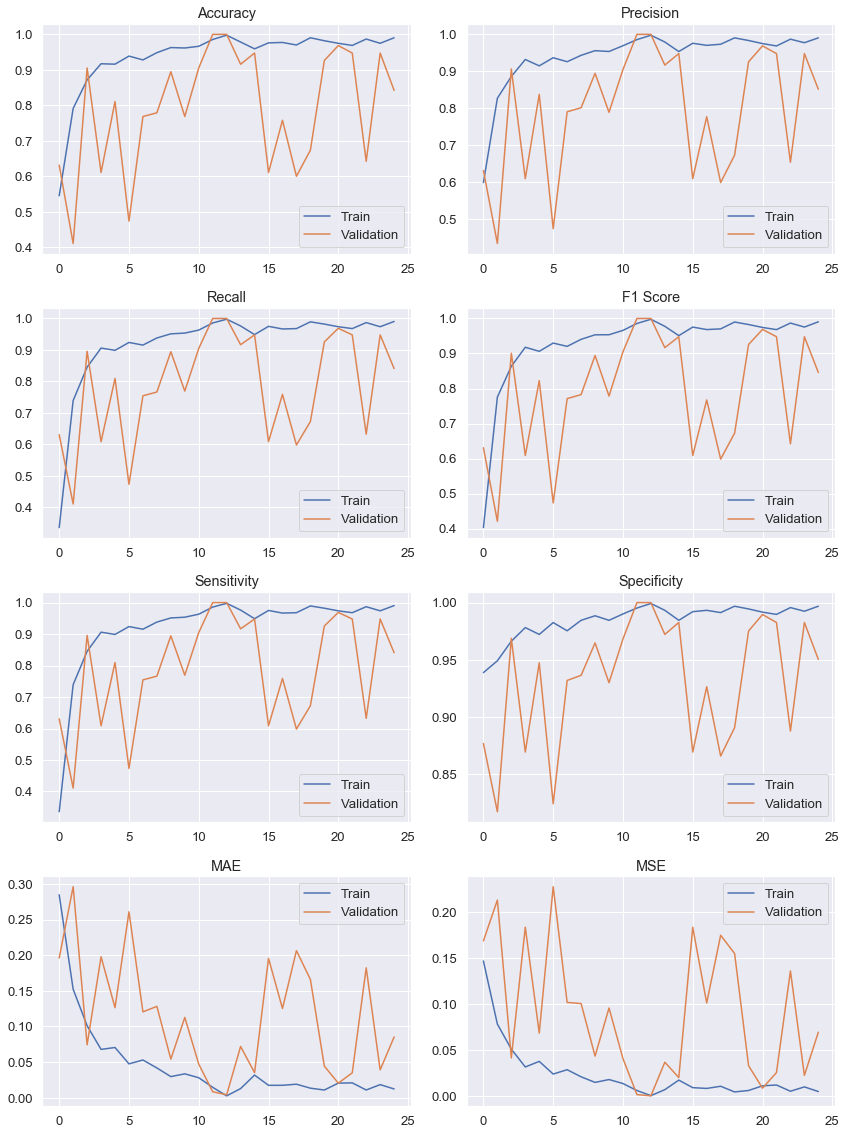

In [59]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

12/12 [==============================] - ETA: 10s - loss: 0.3085 - accuracy: 0.8750 - f1_score: 0.8750 - recall_m: 0.8750 - precision_m: 0.8750 - specificity_m: 0.9583 - sensitivity_m: 0.8750 - mae: 0.0766 - mse: 0.054 - ETA: 6s - loss: 0.1571 - accuracy: 0.9375 - f1_score: 0.9375 - recall_m: 0.9375 - precision_m: 0.9375 - specificity_m: 0.9792 - sensitivity_m: 0.9375 - mae: 0.0397 - mse: 0.027 - ETA: 5s - loss: 0.1944 - accuracy: 0.9167 - f1_score: 0.9361 - recall_m: 0.9167 - precision_m: 0.9583 - specificity_m: 0.9861 - sensitivity_m: 0.9167 - mae: 0.0502 - mse: 0.02 - ETA: 5s - loss: 0.1478 - accuracy: 0.9375 - f1_score: 0.9521 - recall_m: 0.9375 - precision_m: 0.9688 - specificity_m: 0.9896 - sensitivity_m: 0.9375 - mae: 0.0386 - mse: 0.02 - ETA: 5s - loss: 0.6353 - accuracy: 0.9000 - f1_score: 0.9117 - recall_m: 0.9000 - precision_m: 0.9250 - specificity_m: 0.9750 - sensitivity_m: 0.9000 - mae: 0.0559 - mse: 0.04 - ETA: 4s - loss: 1.0941 - accuracy: 0.8750 - f1_score: 0.8847 - rec

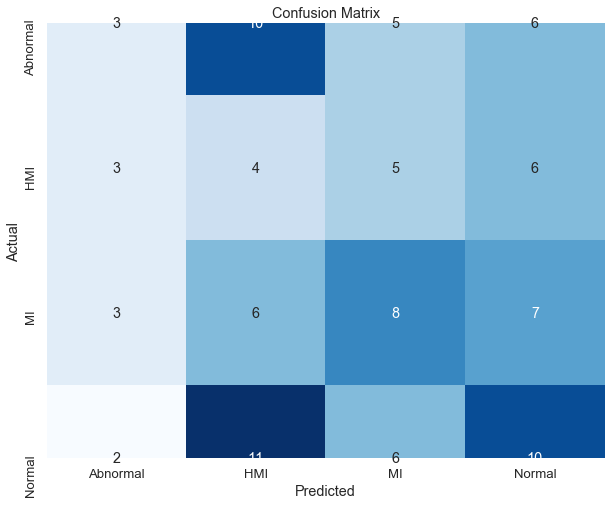

In [60]:
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [61]:
model.save('models/Xception.h5')

In [62]:
a3 = history.history['accuracy'][-1]
f3 = history.history['f1_score'][-1]
p3 = history.history['precision_m'][-1]
r3 = history.history['recall_m'][-1]
mae3 = history.history['mae'][-1]
mse3 = history.history['mse'][-1]
specificity3 = history.history['specificity_m'][-1]  
sensitivity3 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a3 * 100))
print('Precision = ' + str(p3 * 100))
print('F1 Score = ' + str(f3 * 100))
print('Recall = ' + str(r3 * 100))
print('MAE = ' + str(mae3))
print('MSE = ' + str(mse3))
print('Sensitivity = ' + str(sensitivity3 * 100))  
print('Specificity = ' + str(specificity3 * 100))

Accuracy = 99.03961420059204
Precision = 99.04761910438538
F1 Score = 99.04761910438538
Recall = 99.04761910438538
MAE = 0.012281457893550396
MSE = 0.005255479831248522
Sensitivity = 99.04761910438538
Specificity = 99.68255162239075


# comparion

In [71]:
results = {
    'Accuracy': [a, a1, a2, a3],
    'Recall': [r, r1, r2, r3],
    'Precision': [p, p1, p2, p3],
    'F1': [f, f1, f2, f3],
    'MAE': [mae, mae1, mae2, mae3],
    'MSE': [mse, mse1, mse2, mse3],
    'Specificity': [specificity, specificity1, specificity2, specificity3],
    'Sensitivity': [sensitivity, sensitivity1, sensitivity2, sensitivity3]
}

index = ['MobileNet','CNN','ANN','Xception']

In [72]:
results =pd.DataFrame(results,index=index)
print(results)

           Accuracy    Recall  Precision        F1  \
MobileNet  0.953181  0.945238   0.945238  0.945238   
CNN        0.997599  0.997619   0.997619  0.997619   
ANN        0.306122  0.000000   0.000000  0.000000   
Xception   0.990396  0.990476   0.990476  0.990476   

                                            MAE  \
MobileNet  <function mae at 0x000002768437B9D8>   
CNN                                   0.0119324   
ANN                                    0.370899   
Xception                              0.0122815   

                                            MSE  Specificity  Sensitivity  
MobileNet  <function mse at 0x000002768437BD38>     0.981746     0.945238  
CNN                                  0.00150008     0.999206     0.997619  
ANN                                     0.18545     1.000000     0.000000  
Xception                             0.00525548     0.996826     0.990476  


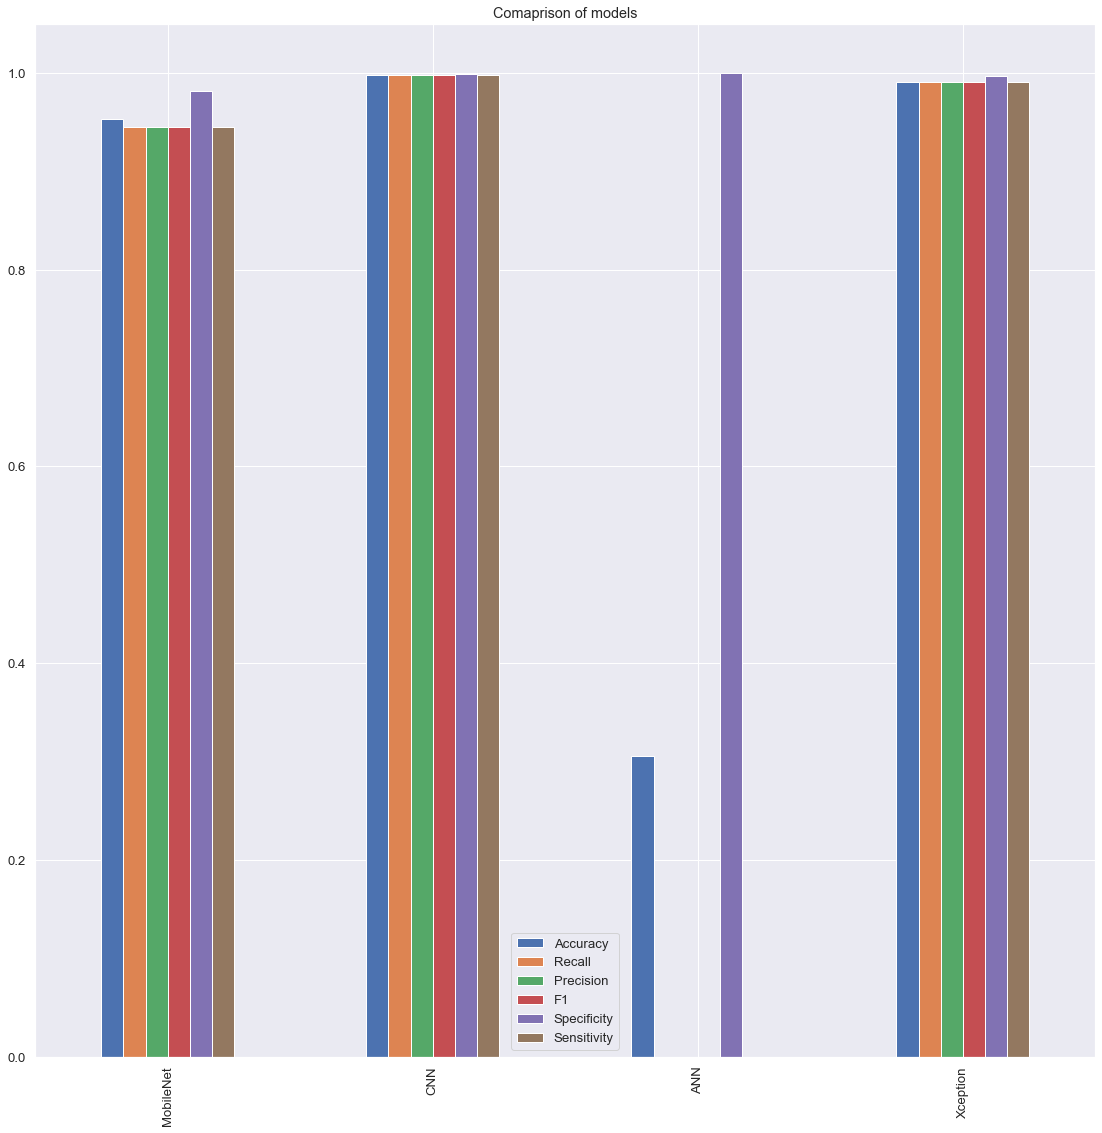

In [73]:
fig =results.plot(kind='bar',title='Comaprison of models',figsize =(19,19)).get_figure()
fig.savefig('Final Result.png')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000276686E44C8>,
      dtype=object)

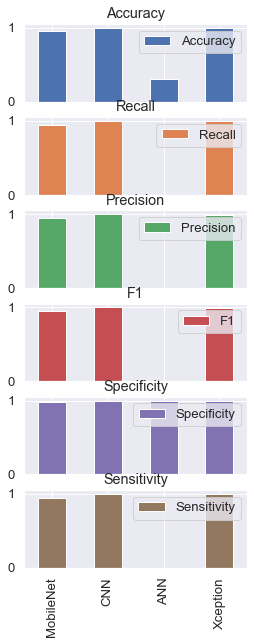

In [74]:
results.plot(subplots=True,kind ='bar',figsize=(4,10))

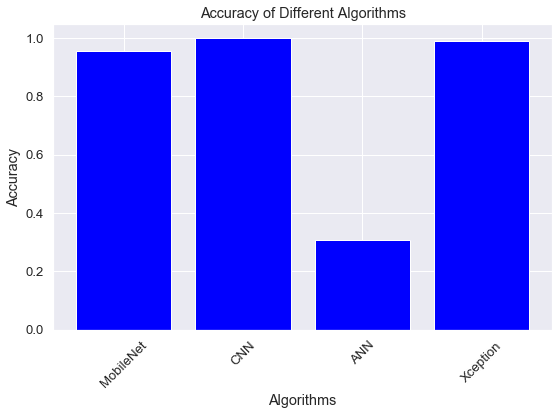

In [75]:
accuracy_values = results['Accuracy']
accuracy_df = pd.DataFrame({'Algorithms': index, 'Accuracy': accuracy_values})

plt.figure(figsize=(8, 6))
plt.bar(accuracy_df['Algorithms'], accuracy_df['Accuracy'], color='blue')
plt.title('Accuracy of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

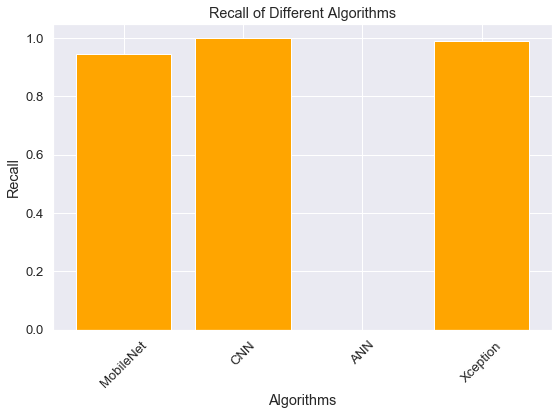

In [76]:
recall_values = results['Recall']
recall_df = pd.DataFrame({'Algorithms': index, 'Recall': recall_values})

plt.figure(figsize=(8, 6))
plt.bar(recall_df['Algorithms'], recall_df['Recall'], color='orange')
plt.title('Recall of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

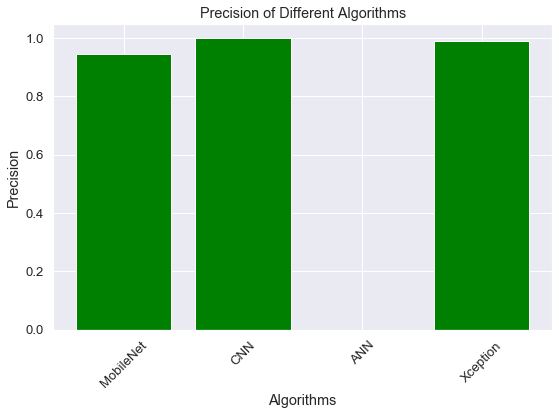

In [77]:
precision_values = results['Precision']
precision_df = pd.DataFrame({'Algorithms': index, 'Precision': precision_values})

plt.figure(figsize=(8, 6))
plt.bar(precision_df['Algorithms'], precision_df['Precision'], color='green')
plt.title('Precision of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Precision')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

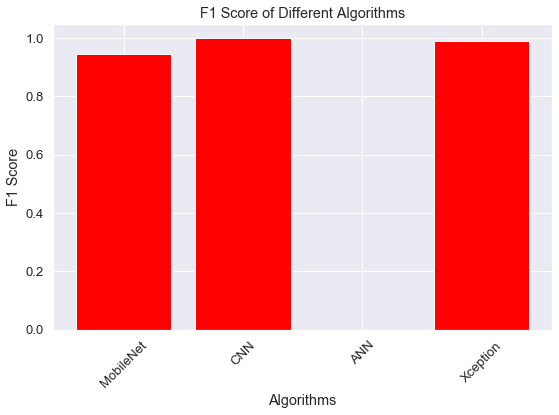

In [78]:
f1_values = results['F1']
f1_df = pd.DataFrame({'Algorithms': index, 'F1 Score': f1_values})

plt.figure(figsize=(8, 6))
plt.bar(f1_df['Algorithms'], f1_df['F1 Score'], color='red')
plt.title('F1 Score of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()